# 2.4.4 Compare Group individual models Version 3
## Goals:
### Question 1: Compare Group model and individual model
1. Train Models
+ Architecture: Surya's Model with 6 mins, slide = 5 sec for consistence in group model and individual models
+ Train one group model on CAD, train individual models on different personal dataset

2. Time Metrics
+ Use train/test split based on number of windows
+ Use WACC, Recall, F1, Precision  (ACC optional)on unbalanced test set. 
+ Test on One Group model,  N individual models

3. Episode Metrics
+ Use split by day 
+ Implement episode Metrics and hysteresis threshold
+ Use 5-fold Cross-validation for individual models for one dataset
+ Compare pre-trained Group model in step2 on individual test set with Cross-validation in individual models


In [1]:
import numpy as np
import pandas as pd
import torch
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
import sys
import numpy as np
from numpy.random import seed
### imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Turn off TensorFlow logging
import tensorflow as tf


import numpy as np
import pandas as pd
import random
#from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import loadfile
import addons

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, add
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import load_model, save_model, Model


from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices
from utils import *
from model import *


tf.__version__

'2.3.0'

In [3]:
# # import tensorflow as tf

# os.environ["CUDA_VISIBLE_DEVICES"]='0'
# print("Num GPUs Available: ", (tf.config.experimental.list_physical_devices('GPU')))
# tf.config.list_physical_devices()
# tf.test.is_gpu_available(), torch.cuda.is_available()

In [4]:

shimmer_global_mean = [-0.012359981,-0.0051663737,0.011612018,
                        0.05796114,0.1477952,-0.034395125 ]

shimmer_global_stddev = [0.05756385,0.040893298,0.043825723,
                        17.199743,15.311142,21.229317 ]

shimmer_trended_mean = [-0.000002,-0.000002,-0.000000,
                0.058144,0.147621,-0.033260 ]

shimmer_trended_stddev = [0.037592,0.034135,0.032263,
                17.209038,15.321441,21.242532 ]

all_zero_means = [0,0,0,0,0,0]

meanvals = all_zero_means
stdvals = shimmer_trended_stddev


random_seed  = 1000
# seed(random_seed)
# tf.random.set_seed(random_seed)
# np.random.seed(random_seed)



In [5]:
def seed_everything(seed= 1000):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed= random_seed)  

In [6]:
def acti_model(input_shape):
        
        model = Sequential()
        
        model.add(Conv1D(10, 44, strides=2,activation='relu', input_shape=input_shape))
        model.add(Conv1D(10, 20, strides=2, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
        model.add(Conv1D(10, 4, strides=2, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        return model


# def residual_module(layer_in, n_filters):
#             merge_input = layer_in
#             # check if the number of filters needs to be increase, assumes channels last format
#             if layer_in.shape[-1] != n_filters:
#                 merge_input = Conv1D(n_filters, (1,), padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l1(0.01))(layer_in)
#             # conv1
#             # L2 for avoiding overfitting
#             conv1 = Conv1D(n_filters, (5,), padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer_in)
#             # Batch normal for re-scaling data and better fit data
#             conv1 = tf.keras.layers.BatchNormalization(1)(conv1)
#             conv1 = tf.keras.layers.ReLU()(conv1)
#             # conv2
#             conv2 = Conv1D(n_filters, (5,), padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv1)
#             conv2 = tf.keras.layers.BatchNormalization(1)(conv2)
            
#             # add filters, assumes filters/channels last
#             #out = conv2
#             out = add([conv2, merge_input])
#             # activation function
#             layer_out = Activation('relu')(out)
#             return layer_out
        

# def res_model(input_shape):
#             in_layer = Input(shape = input_shape)
#             out = Conv1D(10, 40, strides=2)(in_layer)
#             out = residual_module(layer_in= out,  n_filters=10)
#             out = residual_module(layer_in= out,  n_filters=10)
#             out = GlobalAveragePooling1D()(out)
#             # L1 for feature selection
#             out = Dense(200, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(out)
#             out = Dense(1, activation='sigmoid')(out)
#             model = Model(inputs=in_layer, outputs=out)
#             return model
        
# def transfer_model(input_shape, tf_model):
#             in_layer = Input(shape = input_shape)
#             out = tf_model(in_layer)
#             out = Dense(1, activation='sigmoid')(out)
#             model = Model(inputs=in_layer, outputs=out)
#             return model
    
    
    
# def transfer_model_v2(input_shape, tf_model):
#             in_layer = Input(shape = input_shape)
            
#             model = Sequential()
#             model.add(in_layer)
#             for layer in tf_model.layers[1:-1]:  # 跳过最后一层 
#                 model.add(layer)
#             model.add(Dense(1, activation='sigmoid'))
#             return model
    

In [7]:
# name_ls = ["tianyi"]
# for name in name_ls:
#     create_train_test_file_list(file_name= "all_files_list.txt",person_name =name,
#                          out_path = "../data-file-indices/",root_path= "../",
#                          test_ratio = 0.2, print_flag = True, shuffle=True, random_state=random_seed)

# 0. Dataset Description

In [8]:
from collections import defaultdict
from data_loader import loadEvents
def get_meal_info(person_name = None,file_ls = [], file_ls_doc=None,root_path = "../data/",print_file=False,round_decimal=1):
        """
        if file_ls is not given, then get file_ls according to person_name
        file path = root_path + file name in all_files_list.txt

        return:
            meal event count, total minutes of all meals, total hours of all meals,total day counts

        """
        meal_counts = 0
        sec_counts = 0
        min_counts = 0
        hour_counts = 0
        total_hours = 0
        total_mins = 0
        total_sec = 0
        day_counts = 0 
        if person_name ==None:
            return meal_counts, min_counts,hour_counts, day_counts, total_hours

        data_indices_file = "../data-file-indices/" +person_name+"/all_files_list.txt"
        fp = open(data_indices_file,"r")
        txt = fp.read()
        fp.close()
        file_ls = txt.split("\n")
        while '' in file_ls:
            file_ls.remove('')
       
        day_counts = len(file_ls)
        
        for file_name in file_ls:
            file_name = root_path + file_name
            TotalEvents, EventStart, EventEnd, EventNames, TimeOffset,EndTime = loadEvents(file_name, debug_flag = False, print_file=print_file)
            meal_counts += TotalEvents
            total_sec +=  abs(EndTime - TimeOffset)
            for i in range(len(EventStart)):
                sec_counts += ( EventEnd[i]- EventStart[i])//15
                
        total_hours = total_sec/(60*60)
        min_counts = sec_counts/60
        hour_counts = min_counts/60
        average_meal_per_day = meal_counts/len(file_ls)
        average_hour_per_meal = hour_counts/meal_counts
        # round numbers
        total_hours = round(total_hours, round_decimal)
        min_counts = round(min_counts, round_decimal)
        hour_counts = round(hour_counts, round_decimal)
        average_meal_per_day = round(average_meal_per_day,round_decimal)
        average_hour_per_meal = round(average_hour_per_meal, round_decimal)
        
        no_eating_hours = total_hours - hour_counts
        weight_ratio = round(no_eating_hours/hour_counts, round_decimal)
        result = pd.DataFrame({"dataset": person_name,"Days":day_counts, 
                      "Total Hours":total_hours,"Meal Counts":meal_counts,
                      "Average Meal Counts Per Day":average_meal_per_day,"Average Hours Per Meal": average_hour_per_meal,
                      "Eating Hours":hour_counts, "No Eating Hours":no_eating_hours,
                     "Balance Ratio(no_eat/eat)":weight_ratio},index=[0])
    
        return result

          
def get_dataset_info(names= ["wenkanw"],winmin=6,stridesec=5):
    meal_info = defaultdict(list)
    dataset_results = pd.DataFrame()
    for name in names:
        result = get_meal_info(person_name=name)
        if dataset_results.empty:
            dataset_results = result
        else:
            dataset_results = dataset_results.append(result,ignore_index=True)
    
    # append total summary
#     print( dataset_results)
    total_result=pd.DataFrame({"dataset":"total"},columns = dataset_results.columns,index=[0])
    # append average summary
    average_result=pd.DataFrame({"dataset":"average"},columns = dataset_results.columns,index=[0])
    key_ls = ["Days","Total Hours","Meal Counts","Eating Hours","No Eating Hours"]
    for key in dataset_results.columns:
        if key in key_ls:
            total_result[key].at[0] = round(dataset_results[key].sum() ,1)
            average_result[key].at[0] = round(dataset_results[key].mean(),1)

    ls = [total_result, average_result]
    for df in ls:
        df["Average Meal Counts Per Day"].at[0] = round(df["Meal Counts"].values[0]/df["Days"].values[0], 1)
        df["Average Hours Per Meal"].at[0] =round( df["Eating Hours"].values[0]/df["Meal Counts"].values[0], 1)
        df["Balance Ratio(no_eat/eat)"].at[0] =round(df["No Eating Hours"].values[0]/df["Eating Hours"].values[0],1)
        dataset_results =dataset_results.append(df,ignore_index=True)

    return dataset_results

In [9]:
TotalEvents, EventStart, EventEnd, EventNames, TimeOffset,EndTime = loadEvents("../data/IndividualData/lawler-data/9.23/9.23_13hr-events.txt", 
                                                                               debug_flag = False, print_file=False)


EndTime//(3600),TimeOffset//(3600)   ,(EndTime - TimeOffset)//(3600),(EventEnd[2]-EventStart[2])/(3600*15),(EventEnd[0]-EventStart[0])/(3600*15)

(24, 11, 13, 0.55, 0.21666666666666667)

In [10]:
! cat ../data/IndividualData/lawler-data/9.23/9.23_13hr-events.txt

START	2020-09-23	11:33:14
breakfast	11:58:00	12:11:00		Seconds	Alone	CompanyNotEating	scrambled eggs | 
lunch	17:13:00	17:23:00		Seconds	Alone	CompanyNotEating	fetticini | 
late night snack	23:40:00	0:13:00		Seconds	Alone	CompanyNotEating	poptart, pretzels, peanuts | 
a single bite	0:48:00	0:48:30		NoSeconds	Alone	CompanyNotEating	ate a pretzel stick | 
END	2020-09-24	00:49:04





In [11]:
! cat  ../data/IndividualData/tianyi-data/1-25-21/Shimmer-Data-events.txt

START	2021-01-25	18:10:28
Lunch	19:36	19:56	Home	NoSeconds	Alone	CompanyNotEating	Burgers | TV
Dinner	3:48	3:58	Home	NoSeconds	Alone	CompanyNotEating	Rice noodle | Coding
END	2021-01-26	04:27:46





In [12]:
name_ls = ["wenkanw",'adam',"lawler","shaurya","tianyi"]
dataset_info = get_dataset_info(names= name_ls)
dataset_info

,dataset,Days,Total Hours,Meal Counts,Average Meal Counts Per Day,Average Hours Per Meal,Eating Hours,No Eating Hours,Balance Ratio(no_eat/eat)
0,wenkanw,17,129.2,32,1.9,0.2,7.7,121.5,15.8
1,adam,14,125.6,26,1.9,0.1,3.3,122.3,37.1
2,lawler,23,167.2,61,2.7,0.4,25.9,141.3,5.5
3,shaurya,13,134,38,2.9,0.2,9.3,124.7,13.4
4,tianyi,12,104.2,16,1.3,0.3,5.1,99.1,19.4
5,total,79,660.2,173,2.2,0.3,51.3,608.9,11.9
6,average,15.8,132,34.6,2.2,0.3,10.3,121.8,11.8


In [109]:
# old version
name_ls = ["wenkanw",'adam',"lawler","shaurya","tianyi"]
dataset_info = get_dataset_info(names= name_ls)
dataset_info

,dataset,Days,Total Hours,Meal Counts,Average Meal Counts Per Day,Average Hours Per Meal,Eating Hours,No Eating Hours,Balance Ratio(no_eat/eat)
0,wenkanw,17,129.2,32,1.9,0.2,7.7,121.5,15.8
1,adam,14,125.6,26,1.9,0.1,3.3,122.3,37.1
2,lawler,23,173.9,61,2.7,0.4,25.9,148,5.7
3,shaurya,13,134,38,2.9,0.2,9.3,124.7,13.4
4,tianyi,12,124.2,16,1.3,0.3,5.1,119.1,23.4
5,total,79,686.9,173,2.2,0.3,51.3,635.6,12.4
6,average,15.8,137.4,34.6,2.2,0.3,10.3,127.1,12.3


In [10]:
dataset_info.to_csv("../results/dataset_info.csv",index=False)

In [11]:
dataset_info[dataset_info["dataset"]=="total"]['Balance Ratio(no_eat/eat)'].values[0]

11.2

# 1. Train Models

In [13]:

from dataset import create_train_test_file_list,  balance_data_indices  #Person_MealsDataset,
from utils import *
from model import *
def train_models(model, win_ls = [],EPOCHS = 10,stridesec = 5,name = "wenkanw",model_name="acti_6min" ,
                 random_seed= 1000, split_day=False,test_balanced=False,
                create_file_ls = False):
    from numpy.random import seed
    seed(random_seed)
    random.seed(random_seed)
#     tf.set_random_seed(random_seed)
    from datetime  import datetime
    batch_size = 128
    outfile = sys.stdout
    perf = {"model":[],"data":[],"win(sec)":[], "wacc":[],"f1":[],"recall":[],"acc":[]}
    model_ls = []
    hist_ls = []
    for winsize in win_ls:
        tf.random.set_seed(random_seed)
        seed(random_seed)
        
        winmin = winsize
        winlength = int(winmin * 60 * 15)
        step = int(stridesec * 15)
        start_time = datetime.now()
        arr = ["echo -n 'PBS: node is '; cat $PBS_NODEFILE",\
              "echo PBS: job identifier is $PBS_JOBID",\
              "echo PBS: job name is $PBS_JOBNAME"]
        [os.system(cmd) for cmd in arr]
        print("*****************************************************************\n", file=outfile, flush=True)
        print("Execution Started at " + start_time.strftime("%m/%d/%Y, %H:%M:%S"), file=outfile, flush=True)
        print("WindowLength: {:.2f} min ({:d} datum)\tSlide: {:d} ({:d} datum)\tEpochs:{:d}\n".format(winmin, winlength, stridesec, step, EPOCHS), file=outfile, flush=True)


        if split_day:
            pathtemp = "../models/" + name+"_models" +"/"+model_name+"_split_day_M_F_"
        else:
            pathtemp = "../models/" + name+"_models" +"/"+model_name+"_M_F_"
            
        #pathtemp = "../models/" + name +"/"+model_name+"_M_F_"
        modelpath = pathtemp + "{:f}Min.h5".format(winmin)
        jsonpath = pathtemp + "{:f}Min.json".format(winmin)
        
        print("Model to Save: ",modelpath)
        print()
        ########### Load the dataset################
        person = name
        if create_file_ls:
            create_train_test_file_list(file_name= "all_files_list.txt",person_name =name,
                         out_path = "../data-file-indices/",root_path= "../",
                         test_ratio = 0.2, print_flag = True, shuffle=True, random_state=random_seed)
        
        if split_day:
            

            meal_data_train = Person_MealsDataset(person_name= person, file_name = "train_files", winmin = winmin,stridesec = stridesec)
            meal_data_test = Person_MealsDataset(person_name= person, file_name = "test_files", winmin = winmin,stridesec = stridesec)

            train_indices, valid_indices = split_train_test_indices(X= [i for i in range(len(meal_data_train.labels))],
                                                                    y = meal_data_train.labels, test_size = 0.2,
                                                                   random_seed = random_seed)
            #balanced train set
            trainset_labels = meal_data_train.labels[train_indices]
            train_indices = balance_data_indices(trainset_labels,data_indices= train_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)

            # balance test set
            testset_labels = meal_data_test.labels
            if test_balanced:
                test_indices = balance_data_indices(testset_labels,data_indices=[i for i in range(len(meal_data_test))] ,mode="under", shuffle=True,random_state = random_seed,replace= False)
            else:
                # without balancing data
                test_indices = [i for i in range(len(meal_data_test))] 
                
            # get numpy dataset
            balancedData, balancedLabels = meal_data_train.get_subset(train_indices)
            valid_balancedData, valid_balancedLabels = meal_data_train.get_subset(valid_indices)
            test_Data, test_Labels = meal_data_test.get_subset(test_indices)

        else:
        
            meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
            samples,labels =  meal_data.data_indices, meal_data.labels
            # split train set and test set
            train_indices, test_indices = split_train_test_indices(X= [i for i in range(len(labels))],
                                                                    y = labels, test_size = 0.2,
                                                                   random_seed = random_seed)
            # balance train set
            trainset_labels = labels[train_indices]
            train_indices_balanced = balance_data_indices(trainset_labels,data_indices= train_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            
            
            testset_labels = labels[test_indices]
            if test_balanced:
                #balance test set
                test_indices = balance_data_indices(testset_labels,data_indices= test_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            else:
                test_indices = test_indices 
            
            
            train_set_balanced = torch.utils.data.Subset(meal_data, train_indices_balanced)
            test_set = torch.utils.data.Subset(meal_data, test_indices)

            train_loader = torch.utils.data.DataLoader(train_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)
            test_loader = torch.utils.data.DataLoader(test_set ,batch_size=batch_size, shuffle=True,num_workers=2)

            print("Data Loader Created")            
            
            # split validation set
            balanced_trainset_labels = labels[train_indices_balanced]
            train_indices, valid_indices = split_train_test_indices(X= train_indices_balanced,
                                                                    y = balanced_trainset_labels, test_size = 0.2,
                                                                   random_seed = random_seed)
            valid_set_balanced = torch.utils.data.Subset(meal_data, valid_indices)
            valid_loader = torch.utils.data.DataLoader(valid_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)

            # Get numpy dataset: balanced trainset, validation set, test set
            balancedData, balancedLabels = meal_data.get_subset(train_indices)
            valid_balancedData, valid_balancedLabels = meal_data.get_subset(valid_indices)
            test_Data, test_Labels = meal_data.get_subset(test_indices)
        

        #training settings
        mcp_save = tf.keras.callbacks.ModelCheckpoint(modelpath, save_best_only=True, monitor='accuracy')
        

        scheduler = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=3, verbose=0,
                                             mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.)
        
        ##########train model ###############
        H = model.fit(x=balancedData, y = balancedLabels,
                       validation_data=(valid_balancedData, valid_balancedLabels),
                    epochs = EPOCHS, batch_size=batch_size, verbose=1,
                    callbacks=[mcp_save,scheduler]) # removed addons.LossHistory(jsonpath) for compatibility with TensorFlow 2.2.0, needs to be re-added at some point

        print("Max value: ", max(H.history['accuracy']), " at epoch", np.argmax(H.history['accuracy']) + 1)

        from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, balanced_accuracy_score, f1_score
        predictions = model.predict(x=test_Data)
        threshold = 0.5
        wacc =  balanced_accuracy_score(test_Labels,predictions>=threshold)
        f1 =  f1_score(test_Labels,predictions>=threshold)
        acc =  accuracy_score(test_Labels,predictions>=threshold)
        recall = recall_score(test_Labels,predictions>=threshold)
        
        #auc = roc_auc_score(test_Labels,predictions>=threshold)
        print("Weighted Accuracy:", wacc)
        print("Test Accuracy:", acc)
        print("F1-score:", f1)
        print("Recall Accuracy:", recall)
        #print("AUC Score:", auc)

        perf["model"].append("ActiModel")
        perf["data"].append(name)
        perf["win(sec)"].append(winmin*60)
        perf["wacc"].append(wacc)
        perf["f1"].append(f1)
        perf["acc"].append(acc)
        perf["recall"].append(recall)
        #perf["auc"].append(auc)
        model_ls.append(model)
        hist_ls.append(H)
    perf_df = pd.DataFrame(perf)
    print(perf_df)
    return perf_df, model_ls, hist_ls



## 1.1 Train Group Model

In [8]:
person="CAD"
winmin= 6
stridesec = 15
win_size = 15*winmin*60
model_g = acti_model(input_shape =(win_size,6) )
model_g.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_g, model_ls_g, hist_ls_g = train_models(model_g,win_ls = [winmin],EPOCHS = 20,stridesec = stridesec,model_name="acti_6min",name = person,split_day=False)


*****************************************************************

Execution Started at 01/13/2021, 11:45:11
WindowLength: 6.00 min (5400 datum)	Slide: 15 (225 datum)	Epochs:20

Model to Save:  ../models/CAD_models/acti_6min_M_F_6.000000Min.h5

Loading Dataset ...
Loading File:  ../data/ShimmerData/P2001/P2001.shm
Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../dat

In [37]:
# hist_df = pd.DataFrame(hist_ls_3[0].history)
hist_df = pd.DataFrame(hist_ls_g[0].history)
hist_df.to_csv("../results/train_results/group_model_6min_train_history.csv")
perf_train_df = pd.read_csv("../results/train_results/group_model_6min_train_history.csv",index_col=0)

perf_df_g.to_csv("../results/train_results/group_model_6min_train_time_metrics.csv")
time_metric_df = pd.read_csv("../results/train_results/group_model_6min_train_time_metrics.csv", index_col=0)

<AxesSubplot:>

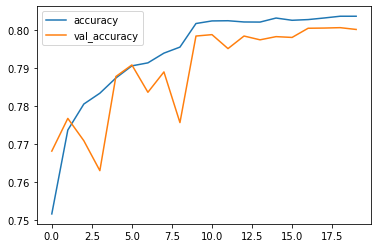

In [38]:
perf_train_df[['accuracy', 'val_accuracy']].plot()

In [36]:
# hist_ls_g = hist_ls_3
# perf_df_g = perf_df_3
# model_ls_g = model_ls_3

In [75]:
person="CAD"
winmin= 6
stridesec = 15
win_size = 15*winmin*60
model_g2 = acti_model(input_shape =(win_size,6) )
model_g2.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_g2, model_ls_g2, hist_ls_g2 = train_models(model_g2,win_ls = [winmin],EPOCHS = 20,
                                                stridesec = stridesec,model_name="acti_6min",name = person,split_day=True)


*****************************************************************

Execution Started at 01/13/2021, 23:20:59
WindowLength: 6.00 min (5400 datum)	Slide: 15 (225 datum)	Epochs:20

Model to Save:  ../models/CAD_models/acti_6min_split_day_M_F_6.000000Min.h5

Train: 284
ShimmerData/P2001/P2001.shm
ShimmerData/P2011/P2011.shm
ShimmerData/P2012/P2012.shm
ShimmerData/P2013/P2013.shm
ShimmerData/P2014/P2014.shm
ShimmerData/P2015/P2015.shm
ShimmerData/P2016/P2016.shm
ShimmerData/P2017/P2017.shm
ShimmerData/P2018/P2018.shm
ShimmerData/P2020/P2020.shm
ShimmerData/P2030/P2030.shm
ShimmerData/P2031/P2031.shm
ShimmerData/P2033/P2033.shm
ShimmerData/P2035/P2035.shm
ShimmerData/P2036/P2036.shm
ShimmerData/P2037/P2037.shm
ShimmerData/P2038/P2038.shm
ShimmerData/P2044/P2044.shm
ShimmerData/P2046/P2046.shm
ShimmerData/P2051/P2051.shm
ShimmerData/P2055/P2055.shm
ShimmerData/P2057/P2057.shm
ShimmerData/P2058/P2058.shm
ShimmerData/P2063/P2063.shm
ShimmerData/P2100/P2100.shm
ShimmerData/P2101/P2101.shm
Shimme

In [76]:
hist_df2 = pd.DataFrame(hist_ls_g2[0].history)
hist_df2.to_csv("../results/train_results/group_model_6min_split_day_train_history.csv")
perf_train_df2 = pd.read_csv("../results/train_results/group_model_6min_split_day_train_history.csv",index_col=0)

perf_df_g2.to_csv("../results/train_results/group_model_6min_split_day_train_time_metrics.csv")
time_metric_df2 = pd.read_csv("../results/train_results/group_model_6min_split_day_train_time_metrics.csv", index_col=0)

<AxesSubplot:>

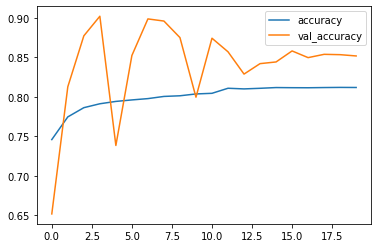

In [78]:
hist_df2[['accuracy', 'val_accuracy']].plot()

In [77]:
time_metric_df2

,model,data,win(sec),wacc,f1,recall,acc
0,ActiModel,CAD,360,0.785488,0.327188,0.728699,0.836064


## 1.2 Train individual models 

In [27]:
person="wenkanw"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_1 = acti_model(input_shape =(win_size,6) )
model_1.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_1, model_ls_1, hist_ls_1 = train_models(model_1,win_ls = [winmin],EPOCHS = 20,stridesec = stridesec,model_name="acti_6min",name = person,split_day=False)


*****************************************************************

Execution Started at 01/13/2021, 12:52:18
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/wenkanw_models/acti_6min_M_F_6.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm

In [39]:
path = "../results/train_results/individual_model_"+ person+"_6min_train_"
hist1_df = pd.DataFrame(hist_ls_1[0].history)
hist1_df.to_csv(path+"history.csv")
perf_df_1.to_csv(path+"time_metrics.csv")

hist1_df = pd.read_csv(path+"history.csv", index_col=0)
perf1_df = pd.read_csv(path+"time_metrics.csv", index_col=0)

In [68]:
perf1_df

,model,data,win(sec),wacc,f1,recall,acc
0,ActiModel,wenkanw,360,0.944229,0.696897,0.935897,0.951569


In [39]:
person="adam"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_2 = acti_model(input_shape =(win_size,6) )
model_2.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_2, model_ls_2, hist_ls_2 = train_models(model_2,win_ls = [winmin],EPOCHS = 20,
                                                stridesec = stridesec,model_name="acti_6min",name = person,split_day=False,create_file_ls=True)


*****************************************************************

Execution Started at 01/14/2021, 20:11:30
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/adam_models/acti_6min_M_F_6.000000Min.h5

Train:
IndividualData/adam-data/11-30-2020/11-30-2020.shm
IndividualData/adam-data/09-22-2020/09-22-2020.shm
IndividualData/adam-data/12-03-2020/12-03-2020.shm
IndividualData/adam-data/12-11-2020/12-11-2020.shm
IndividualData/adam-data/11-25-2020/11-25-2020.shm
IndividualData/adam-data/12-08-2020/12-08-2020.shm
IndividualData/adam-data/12-07-2020/12-07-2020.shm
IndividualData/adam-data/11-26-2020/11-26-2020.shm
IndividualData/adam-data/12-02-2020/12-02-2020.shm
IndividualData/adam-data/12-04-2020/12-04-2020.shm
IndividualData/adam-data/12-09-2020/12-09-2020.shm
IndividualData/adam-data/12-10-2020/12-10-2020.shm

test: 
IndividualData/adam-data/12-01-2020/12-01-2020.shm
IndividualData/adam-data/11-24-2020/11-24-2020.shm

All files: 
IndividualData

In [44]:
path = "../results/train_results/individual_model_"+ person+"_6min_train_"
hist2_df = pd.DataFrame(hist_ls_2[0].history)
hist2_df.to_csv(path+"history.csv")
perf_df_2.to_csv(path+"time_metrics.csv")

hist2_df = pd.read_csv(path+"history.csv", index_col=0)
perf2_df = pd.read_csv(path+"time_metrics.csv", index_col=0)

In [46]:
perf2_df

,model,data,win(sec),wacc,f1,recall,acc
0,ActiModel,adam,360,0.90895,0.317578,0.925697,0.893104


In [47]:
person="lawler"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_3 = acti_model(input_shape =(win_size,6) )
model_3.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_3, model_ls_3, hist_ls_3 = train_models(model_3,win_ls = [winmin],EPOCHS = 20,stridesec = stridesec,model_name="acti_6min",name = person,split_day=False)


*****************************************************************

Execution Started at 01/13/2021, 13:15:57
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/lawler_models/acti_6min_M_F_6.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/11.2/11.2.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/11.15/11.15.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.11/11.11.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.shm
Loading Fil

In [48]:
path = "../results/train_results/individual_model_"+ person+"_6min_train_"
hist3_df = pd.DataFrame(hist_ls_3[0].history)
hist3_df.to_csv(path+"history.csv")
perf_df_3.to_csv(path+"time_metrics.csv")

hist3_df = pd.read_csv(path+"history.csv", index_col=0)
perf3_df = pd.read_csv(path+"time_metrics.csv", index_col=0)

<AxesSubplot:>

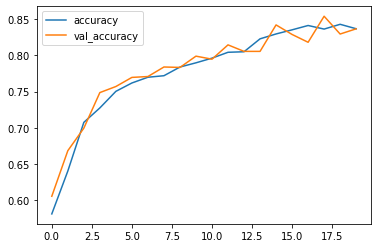

In [52]:
hist3_df[["accuracy","val_accuracy"]].plot()

In [13]:
person="shaurya"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_4 = acti_model(input_shape =(win_size,6) )
model_4.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_4, model_ls_4, hist_ls_4 = train_models(model_4,win_ls = [winmin],EPOCHS = 20,stridesec = stridesec,model_name="acti_6min",name = person,split_day=False)


*****************************************************************

Execution Started at 01/25/2021, 14:17:16
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/shaurya_models/acti_6min_M_F_6.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/sha

In [54]:
path = "../results/train_results/individual_model_"+ person+"_6min_train_"
hist4_df = pd.DataFrame(hist_ls_4[0].history)
hist4_df.to_csv(path+"history.csv")
perf_df_4.to_csv(path+"time_metrics.csv")

hist4_df = pd.read_csv(path+"history.csv", index_col=0)
perf4_df = pd.read_csv(path+"time_metrics.csv", index_col=0)

<AxesSubplot:>

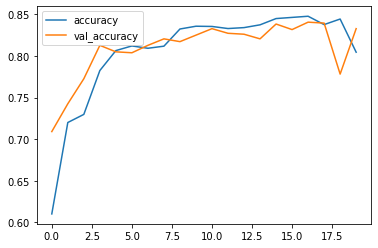

In [56]:
# perf4_df
hist4_df[["accuracy","val_accuracy"]].plot()

# 1.2 Train other inidividual  models in a for-loop here

## 1.3 Train models based on data splited by days 

In [40]:
person="wenkanw"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_day_1 = acti_model(input_shape =(win_size,6) )
model_day_1.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_day_1, model_ls_day_1, hist_ls_day_1 = train_models(model_day_1,win_ls = [winmin],EPOCHS = 20,
                                                stridesec = stridesec,model_name="acti_6min",name = person,split_day=True)


*****************************************************************

Execution Started at 01/13/2021, 19:32:52
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/wenkanw_models/acti_6min_split_day_M_F_6.000000Min.h5

Train:
IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
IndividualData/wenkanw-data/9-17-20/9-17-20.shm
IndividualData/wenkanw-data/9-29-20/9-29-20.shm
IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
IndividualData/wenkanw-data/10-9-20/10-9-20.shm
IndividualData/wenkanw-data/11-18-20/11-18-20.shm
IndividualData/wenkanw-data/10-14-20/10-14-20.shm
IndividualData/wenkanw-data/10-12-20/10-12-20.shm
IndividualData/wenkanw-data/11-16-20/11-16-20.shm
IndividualData/wenkanw-data/9-27-20/9-27-20.shm
IndividualData/wenkanw-data/10-3-20/10-3-20.shm
IndividualData/wenkanw-data/10-10-20/10-10-20.shm
IndividualData/wenkanw-data/11-22-20/Dinner/Dinner.shm

test: 
IndividualData/wenkanw

In [41]:
person="adam"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_day_2 = acti_model(input_shape =(win_size,6) )
model_day_2.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_day_2, model_ls_day_2, hist_ls_day_2 = train_models(model_day_2,win_ls = [winmin],EPOCHS = 20,
                                                stridesec = stridesec,model_name="acti_6min",name = person,split_day=True)


*****************************************************************

Execution Started at 01/13/2021, 19:38:07
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/adam_models/acti_6min_split_day_M_F_6.000000Min.h5

Train:
IndividualData/adam-data/12-02-2020/12-02-2020.shm
IndividualData/adam-data/12-10-2020/12-10-2020.shm
IndividualData/adam-data/09-22-2020/09-22-2020.shm
IndividualData/adam-data/11-25-2020/11-25-2020.shm
IndividualData/adam-data/11-12-2020/11-12-2020.shm
IndividualData/adam-data/11-26-2020/11-26-2020.shm
IndividualData/adam-data/11-17-2020/11-17-2020.shm
IndividualData/adam-data/10-28-2020/10-28-2020.shm
IndividualData/adam-data/12-07-2020/12-07-2020.shm
IndividualData/adam-data/12-04-2020/12-04-2020.shm
IndividualData/adam-data/12-03-2020/12-03-2020.shm
IndividualData/adam-data/11-11-2020/11-11-2020-1.shm
IndividualData/adam-data/12-11-2020/12-11-2020.shm
IndividualData/adam-data/11-16-2020/11-16-2020.shm
IndividualData/adam-dat

In [42]:
person="lawler"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_day_3 = acti_model(input_shape =(win_size,6) )
model_day_3.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_day_3, model_ls_day_3, hist_ls_day_3 = train_models(model_day_3,win_ls = [winmin],EPOCHS = 20,
                                                stridesec = stridesec,model_name="acti_6min",name = person,split_day=True)


*****************************************************************

Execution Started at 01/13/2021, 19:42:23
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/lawler_models/acti_6min_split_day_M_F_6.000000Min.h5

Train:
IndividualData/lawler-data/10.8/10.8.shm
IndividualData/lawler-data/11.15/11.15.shm
IndividualData/lawler-data/10.14/10.14.shm
IndividualData/lawler-data/9.23/9.23_13hr.shm
IndividualData/lawler-data/10.12/10.12.shm
IndividualData/lawler-data/11.11/11.11.shm
IndividualData/lawler-data/11.4/11.4.shm
IndividualData/lawler-data/9.25/9.25_1-46.shm
IndividualData/lawler-data/10.6/10.6.shm
IndividualData/lawler-data/10.4/10.4.shm
IndividualData/lawler-data/10.28/10.28.shm
IndividualData/lawler-data/11.3/11.3.shm
IndividualData/lawler-data/10.20/evening_2hr_20min/10.20.shm
IndividualData/lawler-data/10.26/10.26.shm
IndividualData/lawler-data/10.31/10.31.shm
IndividualData/lawler-data/10.31/evening-2hr_goodDinnerTemplate_CFAmeal/10.31.

In [43]:
person="shaurya"
winmin= 6
stridesec = 5
win_size = 15*winmin*60
model_day_4 = acti_model(input_shape =(win_size,6) )
model_day_4.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_day_4, model_ls_day_4, hist_ls_day_4 = train_models(model_day_4,win_ls = [winmin],EPOCHS = 20,
                                                stridesec = stridesec,model_name="acti_6min",name = person,split_day=True)


*****************************************************************

Execution Started at 01/13/2021, 19:48:20
WindowLength: 6.00 min (5400 datum)	Slide: 5 (75 datum)	Epochs:20

Model to Save:  ../models/shaurya_models/acti_6min_split_day_M_F_6.000000Min.h5

Train:
IndividualData/shaurya-data/10.22.2020/Data.shm
IndividualData/shaurya-data/11.15.2020/Data.shm
IndividualData/shaurya-data/11.17.2020/Data.shm
IndividualData/shaurya-data/11.1.2020/Data.shm
IndividualData/shaurya-data/11.18.2020/Data.shm

test: 
IndividualData/shaurya-data/10.25.2020/Data.shm

All files: 
IndividualData/shaurya-data/10.25.2020/Data.shm
IndividualData/shaurya-data/10.22.2020/Data.shm
IndividualData/shaurya-data/11.15.2020/Data.shm
IndividualData/shaurya-data/11.17.2020/Data.shm
IndividualData/shaurya-data/11.1.2020/Data.shm
IndividualData/shaurya-data/11.18.2020/Data.shm

Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-dat

# 2. Test Time-based Metric Performance

## 2.1 Test time metrics 

In [14]:
from collections import defaultdict

balance_ratio = dataset_info[dataset_info["dataset"]=="total"]['Balance Ratio(no_eat/eat)'].values[0]

def weight_accuracy(y_true, y_pred,weight= balance_ratio, print_flag=True):
    TP = sum( (y_true==1) &(y_pred==1) )
    FN = sum( (y_true==1) &(y_pred==0) )
    TN = sum( (y_true==0) &(y_pred==0) )
    FP = sum( (y_true==0) &(y_pred==1) )
    if print_flag:
        print("TP: ",TP, "FP: ",FP, "TN: ",TN, "FN: ",FN)
    return (weight*TP + TN)/(weight*(TP+FN) + (TN+FP))

def test_models_time_metric(winmin=1, stridesec = 5,names= ["wenkanw"],random_seed=1000, split_day=False, test_balance=False, test_CAD=False):
    perf = defaultdict(list)
    meal_info = defaultdict(list)
    # Don't test on CAD test set if it is not enabled
    if not test_CAD and "CAD" in names:
        names.remove("CAD")
        
    for name in names:
        person = name
        if split_day:
            meal_data = Person_MealsDataset(person_name= person, file_name = "test_files", winmin = winmin,stridesec = stridesec)

            # balance test set
            testset_labels = meal_data.labels
            if test_balance:
                test_indices = balance_data_indices(testset_labels,data_indices=[i for i in range(len(meal_data))] ,mode="under", shuffle=True,random_state = random_seed,replace= False)
            else:
                test_indices = [i for i in range(len(meal_data))]
            # get numpy dataset
            test_Data, test_Labels = meal_data.get_subset(test_indices)
        else:            
            meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
            samples,labels =  meal_data.data_indices, meal_data.labels
            # split train set and test set
            train_indices, test_indices = split_train_test_indices(X= [i for i in range(len(labels))],
                                                                            y = labels, test_size = 0.2,
                                                                           random_seed = random_seed)
            
            if test_balance:
                testset_labels = labels[test_indices]
                test_indices = balance_data_indices(testset_labels,data_indices= test_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            else:
                test_indices = test_indices
            testset_labels = labels[test_indices]
            print("Testing on : ", sum(testset_labels==1),"positive samples, ",sum(testset_labels==0)," negative samples" )
            test_Data, test_Labels = meal_data.get_subset(test_indices)
        if name !="CAD":
            meal_counts, min_counts,hour_counts, day_counts,total_hours = meal_data.get_mealdataset_info(person_name=name, file_ls_doc="all_files_list.txt")
        else:
            # data from paper
            meal_counts, min_counts,hour_counts, day_counts,total_hours = 1063, 250*60,250, 354, 4680
        meal_info["dataset"].append(name)
        meal_info["Days"].append(day_counts)
        meal_info["Meal_Hours"].append(round(hour_counts,1)) 
        meal_info["Meal_Counts"].append(meal_counts) 
        meal_info["Total_Hours"].append(total_hours) 
        
        perf["dataset"].append(name)
        perf["win(sec)"].append(winmin*60)
        
            
        
        
        from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score, precision_score
        group_model_W  = tf.keras.models.load_model('../models/CAD_models/acti_6min_M_F_6.000000Min.h5')
        
        if name != "CAD":
            if split_day:
                individual_model = tf.keras.models.load_model('../models/'+ name+ '_models/acti_6min_split_day_M_F_6.000000Min.h5')
            else:    
                individual_model = tf.keras.models.load_model('../models/'+ name+ '_models/acti_6min_M_F_6.000000Min.h5')
        models = {"suffix":['Individual-Model','GroupModel'],  "model":[individual_model,group_model_W]}
        
        for i in range(len(models["suffix"])):
            suffix = models["suffix"][i]
            model = models["model"][i]
            # if the dataset is CAD group dataset and model is individual model
            # we don't need to make prediction on that data
            if name == "CAD" and suffix =='Individual-Model':
                acc = None
                auc = None
                recall = None
            else:

                predictions = model.predict(x=test_Data).squeeze(1)
                threshold = 0.5
                prediction = (predictions>=threshold).astype(int)
                wacc =  balanced_accuracy_score(test_Labels,prediction)
                acc =  accuracy_score(test_Labels,prediction)
                recall = recall_score(test_Labels,prediction)
                f1 = f1_score(test_Labels,prediction)
                precision = precision_score(test_Labels,prediction)
                print("Test label: ",test_Labels)
                print("Predictions:",prediction)
                
                # weighted accuracy 2 is computed by (weight*TP +TN)/(weight*(TP+FN) + (TN+FP))
                wacc2 = weight_accuracy(test_Labels,prediction)
            
            
            print("Weighted Accuracy:", wacc)
            print("Weighted Accuracy2:", wacc2)
            print("Recall:", recall)
            print("Precision:", precision)
            print("F1:", f1)
            print("Test Accuracy:", acc)
            
            perf["WAcc: "+suffix].append(wacc)
            perf["WAcc2: "+suffix].append(wacc2)
            perf["Recall: "+suffix].append(recall)
            perf["Precision: "+suffix].append(precision)
            perf["F1: "+suffix].append(f1)
            perf["Acc: "+suffix].append(acc)

    meal_info = pd.DataFrame(meal_info)
    perf_df = pd.DataFrame(perf)
    return meal_info, perf_df

In [148]:
# ["wenkanw","adam","lawler","shaurya","CAD"]

%time meal_info_split_day, performance_split_day = test_models_time_metric(winmin=6, stridesec = 5,names= ["wenkanw","adam","lawler","shaurya","CAD"],split_day=False, test_balance=False)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [151]:
print_time_metrics(performance_split_day)

,dataset,win(sec),WAcc: Individual-Model,WAcc2: Individual-Model,WAcc: GroupModel,WAcc2: GroupModel,F1: Individual-Model,F1: GroupModel,Precision: Individual-Model,Precision: GroupModel,Recall: Individual-Model,Recall: GroupModel,Acc: Individual-Model,Acc: GroupModel
0,wenkanw,360,0.939,0.941,0.772,0.796,0.689,0.412,0.548,0.305,0.927,0.636,0.95,0.892
1,adam,360,0.977,0.979,0.961,0.945,0.703,0.425,0.549,0.27,0.975,0.991,0.979,0.933
2,lawler,360,0.828,0.798,0.583,0.628,0.24,0.119,0.138,0.068,0.923,0.443,0.742,0.71
3,shaurya,360,0.836,0.836,0.759,0.785,0.379,0.398,0.245,0.296,0.836,0.611,0.836,0.89
4,average performance,-,0.895,0.888,0.769,0.789,0.503,0.338,0.37,0.235,0.915,0.67,0.877,0.856


## 2.2 Save Time Metric Comparison Results

In [15]:
def print_time_metrics(result, old_result = None,round_decimal = 3,):
    perf_df = pd.DataFrame()
    mykeys = ["dataset","win(sec)","WAcc", "F1","Precision","Recall"]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']    
    for k in mykeys:
        for key in result.keys():
            if k in key:
                perf_df[key] = result[key]
                if result[key].dtype in numerics:
                    perf_df[key] = np.round(perf_df[key],round_decimal)
    for key in result.keys():
        if "WAcc" not in key and "Acc" in key:
            perf_df[key] = result[key].values.round(round_decimal)
    
    if not isinstance(old_result, type(None)):
        # remove average performance from old results and append new data to table
        idx =old_result[(old_result['dataset']=="average performance") | (old_result['dataset']==result["dataset"].values[0])].index
        print("index",idx)
        new_result = old_result.drop(index=idx,axis=0)
        perf_df= new_result.append(perf_df, ignore_index=True)
        
    mean_perf = pd.DataFrame(columns = perf_df.keys())
    mean_perf = mean_perf.append({"dataset":"average performance","win(sec)":"-"},ignore_index=True)
    for key in perf_df.keys():
        if key.lower() != "dataset" and  key.lower() != "win(sec)":
            mean_perf[key].at[0] = perf_df[key].mean().round(round_decimal)
    
    perf_df = perf_df.append(mean_perf,ignore_index=True)
            
    return perf_df

In [177]:

comparison_perf_df = print_time_metrics(performance_split_day)
num_subject = len(comparison_perf_df)-1
path = "../results/time_metrics/" +str(num_subject)+"_subjects_individuals_group_comparison_time_metrics.csv"
comparison_perf_df.to_csv(path)
comparison_perf_df = pd.read_csv(path,index_col=0)
comparison_perf_df

,dataset,win(sec),WAcc: Individual-Model,WAcc2: Individual-Model,WAcc: GroupModel,WAcc2: GroupModel,F1: Individual-Model,F1: GroupModel,Precision: Individual-Model,Precision: GroupModel,Recall: Individual-Model,Recall: GroupModel,Acc: Individual-Model,Acc: GroupModel
0,wenkanw,360,0.939,0.941,0.772,0.796,0.689,0.412,0.548,0.305,0.927,0.636,0.950,0.892
1,adam,360,0.977,0.979,0.961,0.945,0.703,0.425,0.549,0.270,0.975,0.991,0.979,0.933
2,lawler,360,0.828,0.798,0.583,0.628,0.240,0.119,0.138,0.068,0.923,0.443,0.742,0.710
3,shaurya,360,0.836,0.836,0.759,0.785,0.379,0.398,0.245,0.296,0.836,0.611,0.836,0.890
4,average performance,-,0.895,0.888,0.769,0.789,0.503,0.338,0.370,0.235,0.915,0.670,0.877,0.856


In [23]:
if not isinstance(performance_split_day, type(None)):
    print(type(performance_split_day))

# 2.3 Update individual performances here

In [54]:
time_metric_path = "../results/time_metrics/updated_subjects_individuals_group_comparison_time_metrics.csv"
comparison_perf_df = pd.read_csv(time_metric_path,index_col=0)
comparison_perf_df

,win(sec),WAcc: Individual-Model,WAcc2: Individual-Model,WAcc: GroupModel,WAcc2: GroupModel,F1: Individual-Model,F1: GroupModel,Precision: Individual-Model,Precision: GroupModel,Recall: Individual-Model,Recall: GroupModel,Acc: Individual-Model,Acc: GroupModel
dataset,,,,,,,,,,,,,
wenkanw,360,0.939,0.941,0.772,0.796,0.689,0.412,0.548,0.305,0.927,0.636,0.950,0.892
adam,360,0.977,0.979,0.961,0.945,0.703,0.425,0.549,0.270,0.975,0.991,0.979,0.933
lawler,360,0.828,0.798,0.583,0.628,0.240,0.119,0.138,0.068,0.923,0.443,0.742,0.710
shaurya,360,0.870,0.871,0.769,0.780,0.494,0.416,0.347,0.307,0.861,0.646,0.878,0.874
average performance,-,0.904,0.897,0.771,0.787,0.532,0.343,0.395,0.238,0.922,0.679,0.887,0.852


In [15]:
%time meal_info_split_day, performance_split_day = test_models_time_metric(winmin=6, stridesec = 5,names= ["shaurya"],split_day=False, test_balance=False)

Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.13.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.11.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.12.2021/Consensys Exported Data.shm
Loading File:  ../dat

In [53]:
update_perf_df = print_time_metrics(performance_split_day, old_result = comparison_perf_df)
time_metric_path = "../results/time_metrics/updated_subjects_individuals_group_comparison_time_metrics.csv"
update_perf_df.to_csv(time_metric_path,index= False)
update_perf_df = pd.read_csv(time_metric_path)
update_perf_df

index Int64Index([3, 4], dtype='int64')


,dataset,win(sec),WAcc: Individual-Model,WAcc2: Individual-Model,WAcc: GroupModel,WAcc2: GroupModel,F1: Individual-Model,F1: GroupModel,Precision: Individual-Model,Precision: GroupModel,Recall: Individual-Model,Recall: GroupModel,Acc: Individual-Model,Acc: GroupModel
0,wenkanw,360,0.939,0.941,0.772,0.796,0.689,0.412,0.548,0.305,0.927,0.636,0.950,0.892
1,adam,360,0.977,0.979,0.961,0.945,0.703,0.425,0.549,0.270,0.975,0.991,0.979,0.933
2,lawler,360,0.828,0.798,0.583,0.628,0.240,0.119,0.138,0.068,0.923,0.443,0.742,0.710
3,shaurya,360,0.870,0.871,0.769,0.780,0.494,0.416,0.347,0.307,0.861,0.646,0.878,0.874
4,average performance,-,0.904,0.897,0.771,0.787,0.532,0.343,0.395,0.238,0.922,0.679,0.887,0.852


In [73]:
dic = {"day":[1,2,3],"proba":[0,0,1],"label":[1,9,8]}
# x= list(dic.keys())
x =dic
# x.sort()
x = pd.DataFrame(x)
x["day"].unique().tolist()


[1, 2, 3]

# 3. Test Episode-Based Metric Performance

## 3.1 Hysteresis Threshold

In [16]:
def save_proba(result,path="proba.csv"):
    """
    Save predicted probability to csv files
    """
    df = pd.DataFrame(columns=["day","proba","labels"])
    for i, day in enumerate(result["day"].unique().tolist()):
        dat = {"day":[],"proba":[],"labels":[]}
        dat["proba"] = result["proba"].iloc[i]
        dat["day"] = [day]*len(result["proba"].iloc[i])
        dat["labels"] = result["labels"].iloc[i]
        dat = pd.DataFrame(dat)
        df =df.append(dat)
    df.to_csv(path, index=False)
    print("File "+path+" Saved")
    
def load_proba(path):
    """
    Load predicted probability on individual dataset
    """
    # key is day, value is possibility sequence
    proba_ls = {}
    labels_ls = {}
    df = pd.read_csv(path)
    for i in df['day'].unique():
        probas = df[df['day']==i]["proba"].values
        labels = df[df['day']==i]["labels"].values
        proba_ls[i] = probas
        labels_ls[i] = labels
    return proba_ls,labels_ls
    
def hysteresis_threshold(model, data,days_ls = [], start_threshold=0.8, end_threshold=0.3, winmin = 6,
                        stepsec=5, episode_min = 1.,t_pause = 900,load_proba_flag = True,
                         path ="../results/possibility_results/", file_name= None):
    """
    model: tensorflow model
    data:  This dataset must be the self-defined class of Person_MealsDataset  datasetset in my dataset.py/pytorch dataset without using shuffle. 
    Keep the order of dataset after extracting window samples!  You can also define your own dataset using class object to create the interface
    
    start_threshold: the high threshold of the beginning of segmentation
    
    end_threshold: the end threshold of the end of segmentation
    
    winmin: size of a window sample in unit of  minute
    
    stepsec: stride to move the window in unit of second / the number of second between two adjacent window samples
    
    episode_min: the minimum length of eating episode in unit of minute. If end of segmentation -start of segmentation < episode_min,
        then the episode will not be counted
    file_name: csv file that store predicted possibility of model
    path: path to load / save predicted probability
    
    load_proba_flag: if enabled,  load saved probability to do hysteresis threshold
    """
    result_ls = []
    proba_ls,labels_ls = {}, {}
    if file_name == None:
        file_name =path+"{}_{}min_{}slide_proba.csv".format(data.person_name, winmin,stepsec)
    
    if load_proba_flag and  os.path.isfile(file_name):
        # load generated probability if we already generate it
        proba_ls,labels_ls = load_proba(file_name)
        pass
    else:
        # generate possibility for hysteresis threshold if we have not done yet
        if not days_ls:
            days = set(data.data_indices[:,0])
        else:
            days = days_ls
        #pbar = tqdm(days, total=len(days))
        for day in days:
            # Select and Extract the data and labels of the corresponding day from the whole dataset
            sample_indices= np.where(data.data_indices[:,0]==day)[0]

            # get the numpy array of samples and labels
            import time
            start_time = time.time()
            samples, labels = data.get_subset(sample_indices)
            #print("--- Get data:  %s seconds ---" % (time.time() - start_time))
            probas = model(samples).numpy().squeeze()
            #print("--- Prediction %s seconds ---" % (time.time() - start_time))
            print("--- Day %d: %s seconds ---" % (day, time.time() - start_time))
            proba_ls[day] = probas
            labels_ls[day] = labels
        df = {}
        df["day"] = list(days)
#         day_key = list(proba_ls.keys())
#         day_key.sort()
        df["proba"]= [proba_ls[k] for k in days]
        df['labels'] = [labels_ls[k] for k in days]
        df = pd.DataFrame(df)
        save_proba(df,path=file_name)   

    if not days_ls:
        days = set(data.data_indices[:,0])
    else:
        days = days_ls
    pbar = tqdm(days, total=len(days))
    for day in pbar:
        
        # Select and Extract the data and labels of the corresponding day from the whole dataset
        sample_indices= np.where(data.data_indices[:,0]==day)[0]
        
        probas = proba_ls[day]
        labels = labels_ls[day]
        result = {'day':day,"stepsec": stepsec,'segment_start':[], 'segment_end':[],'proba':[],'predictions':np.zeros([len(sample_indices)]),'labels':[],"segment_count":0}
        state = 0
        start = 0
        end = 0 
        pause_counter = 0
        # one day data
        #print("Day: ",day)
        for i in range(len(sample_indices)):
            #print("i:",i)
            #sample, label = data[i][0].numpy(),data[i][1]
            #sample = np.expand_dims(sample,axis=0)
            #proba = model(sample).numpy()[0][0]
            #sample = samples[i]
            label = labels[i]
            proba = probas[i]
            
            result['proba'].append(proba)
            result['labels'].append(label)
            
            if state ==0 and proba > start_threshold:
                state = 1
                start = i
            elif state == 1 and proba <end_threshold:
                state = 2
                end = i+1
                pause_counter = 0
            elif state ==2:
                if proba > start_threshold:
                    state = 1
                else:
                    pause_counter += stepsec
                    if pause_counter >= t_pause:
                        # convert time to second and check threshold
                        if (end-start)*stepsec >= episode_min*60:
                            # save data
                            result['segment_start'].append(start)
                            result['segment_end'].append(end)
                            result['segment_count'] += 1
                            result['predictions'][start:end] = 1
                            pass
                        end = 0
                        state = 0
        if state != 0:
            # if segment ended at the end of data
            if end != 0:
                result['segment_start'].append(start)
                result['segment_end'].append(end)
                result['predictions'][start:end] = 1
            else:
                result['segment_count'] -= 1  
            result['segment_count'] += 1
#         print("--- One Day: %s seconds ---" % (time.time() - start_time))    
        result_ls.append(result)
    print("Segmentation Completed. ")
    result_ls = pd.DataFrame(result_ls)
                      
    return result_ls

In [17]:
def get_episode_metrics(result, meal_data,days_ls= None):
    """
    Obtain and format the episode metric results 
    
    result: result from  hysteresis threshold function
    meal_data: meal dataset of Person_MealData
    
    """
    
    from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
    total_preds = []
    total_labels = []
    perf = {"TPR":[],"FP/TP":[],"TP":[], "FP":[],"FN":[]}
    tpr = 0. 
    FP_TP = 0.
    TP = 0
    FP = 0
    FN = 0
    # get segmentation of ground truth labeled by user
    start_ls, end_ls = meal_data.get_GT_segment()
    if days_ls:
        start_ls = [start_ls[day] for day in days_ls]
        end_ls =  [end_ls[day] for day in days_ls]
    
    meal_counts, min_counts,hour_counts, day_counts,total_hours = meal_data.get_mealdataset_info()
    
    # iterate every day
    for i in range(len(start_ls)):
        #preds = result.iloc[i]['predictions']
        #labels =  result.iloc[i]['labels']
        event_start, event_end= start_ls[i], end_ls[i]
        detect_start, detect_end = result.iloc[i]['segment_start'],result.iloc[i]['segment_end']
        GT = np.array([-1]*len(event_start) )  # default all meals are missing -1, FN
        detect = np.array([-1]*len(detect_start)) # default all detected meals are wrong -1, FP
        for index in range(len(event_start)):
            # e_s: event start,  e_e: event end
            # d_s: detection start,  d_e: detection end
            e_s, e_e = event_start[index], event_end[index]
            for index2 in range(len(detect_start)):
                # convert segment from sec to index of data point
                d_s = detect_start[index2] * result.iloc[i]['stepsec']*15
                d_e = detect_end[index2]* result.iloc[i]['stepsec']*15
                #print("ds: {} d_e: {}, e_s:{}, e_e: {}".format(d_s,d_e, e_s, e_e))
                if (e_s>=d_s and e_s <= d_e) or (d_s>= e_s and d_s<= e_e):
                    GT[index] = index2
                    detect[index2] = index
        #print("GT:",GT, "Detect:", detect)
        TP += sum(GT!=-1)
        FN += sum(GT==-1)
        FP += sum(detect==-1)
                
    
    print("total_meal:",meal_counts, "TP: ", TP, "FP: ", FP, "FN: ", FN)
    perf['TPR'].append(TP/(TP+FN))
    if TP ==0:
        perf['FP/TP'].append(None)
    else:
        perf['FP/TP'].append(FP/TP)
    perf["TP"].append(TP)
    perf["FP"].append(FP)
    perf["FN"].append(FN)
    result_df = pd.DataFrame(perf)
        
    return pd.DataFrame(result_df)


## 3.2 Episode Metrics Function

In [18]:
from collections import defaultdict
hythreshold = {'wenkanw':[0.8, 0.3], 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}
def test_models_episode_metric(winmin=6, stridesec = 5,names= ["wenkanw"],random_seed=1000,
                               test_balance=False, test_CAD=False,
                               test_alldata=False,threshold= hythreshold,
                               load_proba_flag=True, use_group_threshold = 0,
                              proba_path ="../results/possibility_results/"):
    perf = defaultdict(list)
    meal_info = defaultdict(list)
    
    # Don't test on CAD test set if it is not enabled
    if not test_CAD and "CAD" in names:
        names.remove("CAD")
    group_threshold = {'wenkanw':[0.8, 0.3], 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}
    for name in names:
        person = name
        # test episode metrics that split dataset by days
        if not test_alldata:
            meal_data = Person_MealsDataset(person_name= person, file_name = "test_files", winmin = winmin,stridesec = stridesec)
        else:
            meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
        # balance test set    
        if test_balance:
            testset_labels = meal_data.labels
            test_indices = balance_data_indices(testset_labels,data_indices=[i for i in range(len(meal_data))] ,mode="under", shuffle=True,random_state = random_seed,replace= False)
        else:
            test_indices = [i for i in range(len(meal_data))]
        # get numpy dataset
        #test_Data, test_Labels = meal_data.get_subset(test_indices)
        
        
        meal_counts, min_counts,hour_counts, day_counts,total_hours = meal_data.get_mealdataset_info(person_name=name)
                
        
        perf["Days"].append(day_counts)
        perf["Meal_Hours"].append(round(hour_counts,1)) 
        perf["Meal_Counts"].append(meal_counts) 
        perf["dataset"].append(name)
        perf["win(sec)"].append(winmin*60)
        
            
        from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score, precision_score
        group_model_W  = tf.keras.models.load_model('../models/CAD_models/acti_6min_M_F_6.000000Min.h5')
        
        individual_model = tf.keras.models.load_model('../models/'+ name+ '_models/acti_6min_split_day_M_F_6.000000Min.h5')
            
        models = {"suffix":['Individual-Model','GroupModel'],  "model":[individual_model,group_model_W]}
        proba_path += person+"/"
        for i in range(len(models["suffix"])):
            suffix = models["suffix"][i]
            model = models["model"][i]
            # if the dataset is CAD group dataset and model is individual model
            # we don't need to make prediction on that data
            path= proba_path
            if use_group_threshold==0:
                high_th, low_th = threshold[name][0], threshold[name][1]
            elif use_group_threshold==1:
                if suffix == "GroupModel":
                    high_th, low_th = group_threshold[name][0], group_threshold[name][1]
                else:
                    high_th, low_th = threshold[name][0], threshold[name][1]
            else:
                high_th, low_th = group_threshold[name][0], group_threshold[name][1]
                
            
            if suffix == "GroupModel":
                path = proba_path +"group_"
                
                
            result = hysteresis_threshold(model, meal_data,start_threshold=high_th, end_threshold=low_th,
                                          winmin = 6, stepsec=5, episode_min = 1.,
                                         load_proba_flag=load_proba_flag, path =path)
            episode_perf_df = get_episode_metrics(result,meal_data)
            perf["TPR: "+suffix].append(episode_perf_df["TPR"].iloc[0])
            perf["FP/TP: "+suffix].append(episode_perf_df["FP/TP"].iloc[0])
            perf["TP: "+suffix].append(episode_perf_df["TP"].iloc[0])
            perf["FP: "+suffix].append(episode_perf_df["FP"].iloc[0])
            perf["FN: "+suffix].append(episode_perf_df["FN"].iloc[0])
            
            print(episode_perf_df)

    perf_df = pd.DataFrame(perf)
    return perf_df


def print_episode_metrics(result,old_result= None, round_decimal=3):
    """
    print the episode_perf_df result from test_models_episode_metric
    in suitable order
    """
    result_df= result[['dataset','Days' ,'Meal_Hours',"Meal_Counts","win(sec)",
            "TPR: Individual-Model","TPR: GroupModel","FP/TP: Individual-Model","FP/TP: GroupModel",
           "TP: Individual-Model","TP: GroupModel",
           "FP: Individual-Model","FP: GroupModel",
           "FN: Individual-Model","FN: GroupModel"]]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']   
    for key in result_df.columns:
        if result_df[key].dtype in numerics:
            result_df[key] = result_df[key].values.round(round_decimal) 
            
    if not isinstance(old_result, type(None)):
        # remove average performance from old results and append new data to table
        idx =old_result[(old_result['dataset']=="average performance") | (old_result['dataset'] in result["dataset"].values)].index
        print("index",idx)
        new_result = old_result.drop(index=idx,axis=0)
        result_df= new_result.append(result_df, ignore_index=True)
    
    mean_perf = pd.DataFrame(columns = result_df.keys())
    mean_perf = mean_perf.append({"dataset":"average performance","win(sec)":"-",'Days':"-" ,
                                  'Meal_Hours':"-","Meal_Counts":"-"},ignore_index=True)
    for key in mean_perf.keys():
        if key not in ['dataset','Days' ,'Meal_Hours',"Meal_Counts","win(sec)"]:
            mean_perf[key].at[0] = result_df[key].mean().round(round_decimal)
    
    result_df = result_df.append(mean_perf,ignore_index=True)
    return result_df

### Test on all days of data using Episode metrics

In [195]:
%time all_data_episode_perf_df = test_models_episode_metric(winmin=6, stridesec = 5,names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000, test_balance=False, test_CAD=False,test_alldata=True)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [200]:
all_data_episode_perf_df

,Days,Meal_Hours,Meal_Counts,dataset,win(sec),TPR: Individual-Model,FP/TP: Individual-Model,TP: Individual-Model,FP: Individual-Model,FN: Individual-Model,TPR: GroupModel,FP/TP: GroupModel,TP: GroupModel,FP: GroupModel,FN: GroupModel
0,17,7,32,wenkanw,360,0.968750,0.516129,31,16,1,0.625000,0.300000,20,6,12
1,14,3,26,adam,360,0.884615,0.217391,23,5,3,0.923077,0.333333,24,8,2
2,23,25,61,lawler,360,0.442623,0.962963,27,26,34,0.327869,2.600000,20,52,41
3,6,3,17,shaurya,360,0.823529,2.142857,14,30,3,0.823529,0.642857,14,9,3


In [199]:
episode_metrics = print_episode_metrics(all_data_episode_perf_df)
num_subject = len(episode_metrics )-1
episode_metrics.to_csv("../results/episode_metrics/"+str(num_subject)+"_subjects_alldata_episode_metrics.csv")
episode_df = pd.read_csv("../results/episode_metrics/"+str(num_subject)+"_subjects_alldata_episode_metrics.csv", index_col=0)
episode_df

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.625,0.516,0.300,31.00,20.0,16.00,6.00,1.00,12.0
1,adam,14,3,26,360,0.885,0.923,0.217,0.333,23.00,24.0,5.00,8.00,3.00,2.0
2,lawler,23,25,61,360,0.443,0.328,0.963,2.600,27.00,20.0,26.00,52.00,34.00,41.0
3,shaurya,6,3,17,360,0.824,0.824,2.143,0.643,14.00,14.0,30.00,9.00,3.00,3.0
4,average performance,-,-,-,-,0.780,0.675,0.960,0.969,23.75,19.5,19.25,18.75,10.25,14.5


In [167]:
%time all_data_episode_perf_df = test_models_episode_metric(winmin=6, stridesec = 5,names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000, test_balance=False, test_CAD=False,test_alldata=True)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [308]:
hythreshold2 = {'wenkanw':[0.6, 0.3], 'adam':[0.6,0.3],'lawler':[0.6,0.3], 'shaurya':[0.6,0.3]}

In [309]:
%time all_data_episode_perf_df = test_models_episode_metric(winmin=6, stridesec = 5,names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000, test_balance=False, test_CAD=False,test_alldata=True,threshold=hythreshold2)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [312]:
episode_metrics = print_episode_metrics(all_data_episode_perf_df)
episode_metrics 

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.844,1.29,1.519,31,27,40,41,1,5
1,adam,14,3,26,360,0.923,0.962,0.958,1.32,24,25,23,33,2,1
2,lawler,23,25,61,360,0.836,0.639,1.549,2.231,51,39,79,87,10,22
3,shaurya,6,3,17,360,0.882,0.882,2.333,1.533,15,15,35,23,2,2
4,average performance,-,-,-,-,0.902,0.832,1.533,1.651,30.25,26.5,44.25,46,3.75,7.5


# 4. Visualize generated probability sequence

In [18]:
def map_prediction_gt(meal_data, day,possib_result ):
    """
    Convert segmentation back to binary labels
    and Map the prediction possibility sequence  back to the same shape
    """
    day = int(day)
    res = possib_result 
    possib = np.array(res.proba.iloc[day])
    step= res["stepsec"].iloc[0] *15
    start_ls, end_ls = meal_data.get_GT_segment()
    start_ls = start_ls[day]
    end_ls = end_ls[day]
    proba = np.zeros([len(meal_data.data[day]), ] )
    labels = np.zeros([len(meal_data.data[day]), ] )
    preds = np.zeros([len(meal_data.data[day]), ] )
    
    #probability sequence
    for i in range(len(possib)):
        proba[i*step: (i+1)*step]= possib[i]
    
    # GT label
    for i in range(len(start_ls)):
        labels[start_ls[i]:end_ls[i]+1] = 1
        
    # prediction label by hysteresis threshold
    seg_start_ls = res["segment_start"].iloc[day]
    seg_end_ls = res["segment_end"].iloc[day]
    for i in range(len(seg_start_ls)):
        s = int(seg_start_ls[i] * step)
        e = int(seg_end_ls[i] * step)
        preds[s:e] =1
    return proba, labels, preds

def map_results(meal_data,possib_result):
    """
    Convert segmentation back to binary labels
    and Map the prediction possibility sequence  back to the same shape
    for all days of data
    """
    proba_ls, labels_ls, preds_ls = [],[],[]

    for day in range(len(possib_result)):
        proba, labels, preds = map_prediction_gt(meal_data, day,possib_result )
        proba_ls.append(proba)
        labels_ls.append(labels)
        preds_ls.append(preds)
    return  proba_ls, labels_ls, preds_ls

In [19]:

def get_episode_output(names= [], threshold= None, use_group_model= False,load_proba_flag=True):
    """
    Generate probability sequences for all days of data in all dataset
    """
    output_df = {"dataset":[],"proba_ls":[],"labels_ls":[],"preds_ls":[]}
    if not threshold:
        threshold = {'wenkanw':[0.8, 0.3], 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}
    for person in names:
        output_df["dataset"].append(person)
        meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = 6,stridesec = 5,smooth_flag = 1,
                         normalize_flag = 1)
        high_th, low_th = threshold[person][0], threshold[person][1]
        if use_group_model:
            model = tf.keras.models.load_model('../models/CAD_models/acti_6min_M_F_6.000000Min.h5')
            result = hysteresis_threshold(model, meal_data,start_threshold=high_th, end_threshold=low_th, winmin = 6, stepsec=5, episode_min = 1.,
                                     load_proba_flag=load_proba_flag,path="../results/possibility_results/group_")
        else:
            model = tf.keras.models.load_model('../models/'+ person + '_models/acti_6min_split_day_M_F_6.000000Min.h5')
            result = hysteresis_threshold(model, meal_data,start_threshold=high_th, end_threshold=low_th, winmin = 6, stepsec=5, episode_min = 1.,
                                     load_proba_flag=load_proba_flag)
            
        proba_ls, labels_ls, preds_ls =map_results(meal_data,result)
        output_df["proba_ls"].append(proba_ls)
        output_df["labels_ls"].append(labels_ls)
        output_df["preds_ls"].append(preds_ls)
    return pd.DataFrame(output_df)

In [20]:
def transform_output(proba_ls,labels_ls):
    """
    Concatenate probabilities, labels of all days
    """
    proba_df= np.array([])
    label_df= np.array([])
    for i in range(len(proba_ls)):
            proba_df = np.concatenate((proba_df,proba_ls[i]), axis=None)
            label_df = np.concatenate((label_df,labels_ls[i]), axis=None)
    return proba_df ,label_df

## 4.1 Obtain Probability sequence, episode predictions and GT label

In [66]:
persons =["wenkanw","adam","lawler","shaurya"]
output_df = get_episode_output(names= persons, threshold= None)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

100%|██████████| 17/17 [00:00<00:00, 399.93it/s]


Segmentation Completed. 
Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-02-2020/12-02-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-04-2020/12-04-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-09-2020/12-09-20

100%|██████████| 14/14 [00:00<00:00, 335.98it/s]


Segmentation Completed. 
Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/11.2/11.2.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/11.15/11.15.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.11/11.11.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.shm
Loading File:  ../data/IndividualData/lawler-data/9.25/9.25_1-46.shm
Loading File:  ../data/IndividualData/lawler-data/10.6/10.6.shm
Loading File:  ../data/IndividualData/lawler-data/10.4/10.4.shm
Loading File:  ../data/IndividualDa

100%|██████████| 23/23 [00:00<00:00, 422.18it/s]


Segmentation Completed. 
Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.13.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.11.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.12.2021/Consensys Exported Data.

100%|██████████| 13/13 [00:00<00:00, 80.03it/s]

File ../results/possibility_results/shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 


In [67]:
output_df

,dataset,proba_ls,labels_ls,preds_ls
0,wenkanw,"[[0.007257163499999999, 0.007257163499999999, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,adam,"[[0.30553532, 0.30553532, 0.30553532, 0.305535...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,lawler,"[[0.58255893, 0.58255893, 0.58255893, 0.582558...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,shaurya,"[[0.7323043346405029, 0.7323043346405029, 0.73...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## 4.2 Visualize possibility and GT

In [19]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt


def f(offset,winsize,day, model_result="I"    ):
    stride  = 5 *15 # 5 seconds between two adjacent labels/window samples
    
    day = int(day)
    if model_result =="I":
        proba_list=proba_ls
        labels_list= labels_ls
        preds_list=preds_ls
    else:
        proba_list=proba_ls_g
        labels_list= labels_ls_g
        preds_list=preds_ls_g
    proba, labels, preds = proba_list[day], labels_list[day], preds_list[day]    
    
    offset = offset *15
    if winsize == -1:
        winsize = len(labels)
        offset = 0
    else:
        winsize = winsize*15
    
    if  len(labels)-winsize <0:
        #offset = len(labels)-winsize
        offset =0
        winsize = len(labels)
        
    t = np.arange(start = offset, stop= offset+winsize, step=1)
    print("Offset: ",offset, "winszie: ",winsize,"t shape: ",t.shape, "label shape:", labels.shape, preds.shape)
    fig, ax = plt.subplots(3,1,figsize= (20,12))
    df1 = proba[offset:offset+winsize]
    df2 = np.array(preds[offset:offset+winsize]) #*10-5
    df3 = np.array(labels[offset:offset+winsize])#*10-5
    x1= sns.lineplot(x=t, y=df1 , ax =ax[0],color= 'grey',label="Possibility")
    x2 = sns.lineplot(t,df2 , ax =ax[1],color='g', linewidth=1.5,label="Prediction(Eat)")
    x3 = sns.lineplot(t,df3 , ax =ax[2],color='b', linewidth=1.5, label="Label(Eat)")
        
    ax[0].fill_between( t, df1, 
                interpolate=True, color='grey')
    
    ax[0].fill_between(t, df3, where=(df3==1), 
                interpolate=True, color='blue')
    ax[0].fill_between( t,df2, where=(df2==1), 
                interpolate=True, color='green')
    ax[0].set_ylim(0,1)
    print(offset,len(labels)-winsize )
    if offset >= len(labels)-winsize:
        title_txt ="Day: "+ str(day) + " Whole Day samples: "+str(len(labels)) +" . " + "Sample plotted: "+str(winsize)+". "
    else:
        title_txt = "Day: "+ str(day) + "Samples from "+str(offset) +"~" + str((offset+winsize)) +". "+ "Number of Sample plotted: "+str(winsize)+". "
    ax[0].set_title(title_txt)
    ax[2].set_xlabel("index of sample")
    ax[0].set_ylabel("Possibility")
    ax[1].set_ylabel("Predictions")
    ax[2].set_ylabel("Ground Truch")
    
    ax[0].legend(["Possibility"],loc='upper left')
    ax[1].legend(["1: Eat, 0:Other"],loc='upper left')
    ax[2].legend(["1: Eat, 0:Other"],loc='upper left')
        
    return 

In [158]:

style = {'description_width': 'initial'}
bound_text = widgets.BoundedIntText(
    value=0,
    min=0,
    max=10*3600,
    step=1,
    description='offset(sec):[0~'+ str(10*3600)+"]",
    disabled=False,
    style = {'description_width': 'initial'}
)
slidebar= widgets.IntSlider(min=0, max=len(result.proba.iloc[0]), step=1, value=0)
winsize = widgets.Dropdown(
    options=[-1, 60,60*60],
    value=-1,
    description='Num of sec plotted ',
    disabled=False,
    style = style
)
# interact(f, offset=bound_text, winsize= winsize, day = [i for i in range(len(result))]);

In [229]:
interact(f, offset=bound_text, winsize= winsize, day = 3,model_result= "I");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [230]:
interact(f, offset=bound_text, winsize= winsize, day = 3,model_result= "G");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [161]:
interact(f, offset=bound_text, winsize= winsize, day = 14,model_result= "I");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [162]:
interact(f, offset=bound_text, winsize= winsize, day = 14,model_result= "G");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [165]:
interact(f, offset=bound_text, winsize= winsize, day = 10,model_result= "I");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [166]:
interact(f, offset=bound_text, winsize= winsize, day = 10,model_result= "G");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [169]:
interact(f, offset=bound_text, winsize= winsize, day = 5,model_result= "I");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

In [170]:
interact(f, offset=bound_text, winsize= winsize, day = 5,model_result= "G");

interactive(children=(BoundedIntText(value=0, description='offset(sec):[0~36000]', max=36000, style=Descriptio…

## 4.3 Visualize distribution of generated probability

In [21]:
def plot_proba_dist(output_df, persons=[]):
    for person in persons:
        proba_df = output_df[output_df["dataset"]==person].proba_ls.values[0]
        label_df = output_df[output_df["dataset"]==person].labels_ls.values[0]
        proba_df,label_df = transform_output(proba_df,label_df)

        fig, ax = plt.subplots(1, figsize=(10,5))
        sns.histplot(x=proba_df[label_df==0],common_norm=False,bins=20,stat="probability",ax=ax,color="orange")
        sns.histplot(x=proba_df[label_df==1],common_norm=False,bins=20,stat="probability",ax=ax,color="blue")
        ax.legend(["No Eat","Eat"])
        _ =ax.set(title="Probability of predicted possibility in "+person+" dataset",xlabel="Predicted Possibility")

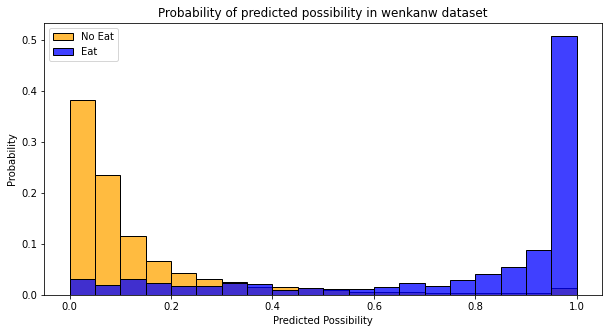

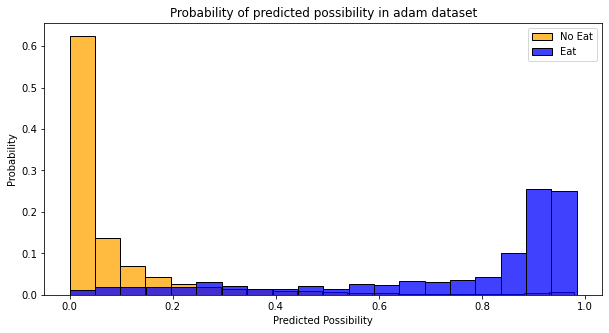

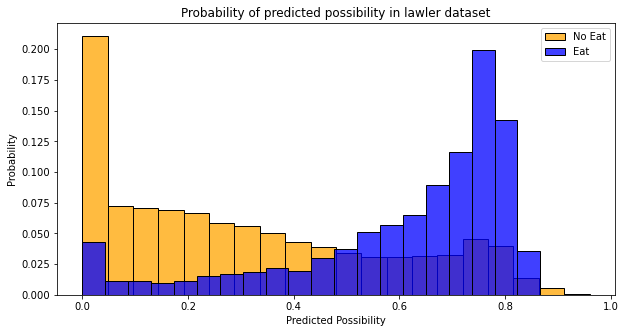

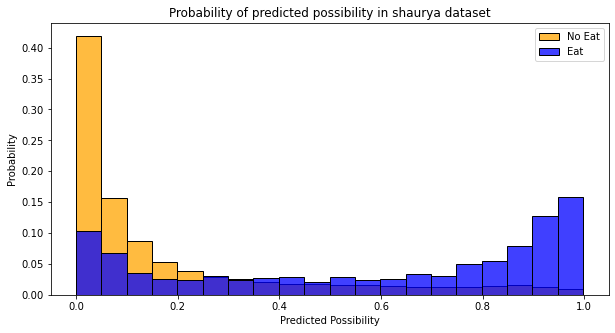

In [69]:
plot_proba_dist(output_df, persons=["wenkanw","adam","lawler","shaurya"])

## 4.4 Test Ts, Te for each individual  models

In [54]:
# person = 'lawler'
# meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = 6,stridesec = 5,smooth_flag = 1,
#                  normalize_flag = 1)
# model = tf.keras.models.load_model('../models/'+ person + '_models/acti_6min_split_day_M_F_6.000000Min.h5')
threshold = {'wenkanw':[0.8, 0.3], 'adam':[0.8,0.3],'lawler':[0.6,0.3], 'shaurya':[0.8,0.3]}
high_th, low_th = threshold[person][0], threshold[person][1]
result = hysteresis_threshold(model, meal_data,start_threshold=high_th, end_threshold=low_th, 
                              winmin = 6, stepsec=5, episode_min = 1., load_proba_flag=True)
episode_perf_df1 = get_episode_metrics(result,meal_data)
episode_perf_df1

100%|██████████| 23/23 [00:00<00:00, 403.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  79 FN:  10


,TPR,FP/TP,TP,FP,FN
0,0.836066,1.54902,51,79,10


In [70]:
def test_threshod(datasets ,ts_ls=[],te_ls=[]):
    res = pd.DataFrame()
    for person in datasets.keys():
        data = datasets[person]
        for ts in ts_ls:
            for te in te_ls:
                model = tf.keras.models.load_model('../models/'+ person + '_models/acti_6min_M_F_6.000000Min.h5')
                ht_result = hysteresis_threshold(model, data,start_threshold=ts, end_threshold=te, 
                              winmin = 6, stepsec=5, episode_min = 1., load_proba_flag=True)
                episode_perf = get_episode_metrics(ht_result,data)
                episode_perf["dataset"] = person
                episode_perf["Ts"] = ts
                episode_perf["Te"] = te
                
                res = res.append(episode_perf, ignore_index=True)
                
    return res  
    

In [42]:
def create_datasets(names=[]):
    datasets = {}
    for person in names:
        meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = 6,stridesec = 5,smooth_flag = 1,
                     normalize_flag = 1)
        datasets[person]  = meal_data
    return datasets

In [72]:
datasets = create_datasets(names = ["wenkanw","adam","lawler","shaurya"])

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [73]:
ts_ls = [0.5,0.55, 0.6,0.65, 0.7,0.75,0.8,0.85]
te_ls = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]
%time threshold_results =  test_threshod(datasets ,ts_ls,te_ls)

  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  53 FN:  2


100%|██████████| 17/17 [00:00<00:00, 391.11it/s]


Segmentation Completed. 
total_meal: 32 TP:  30 FP:  56 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  55 FN:  1


100%|██████████| 17/17 [00:00<00:00, 391.96it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  55 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  51 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  47 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  44 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  43 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  43 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  45 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  46 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  45 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  44 FN:  1


100%|██████████| 17/17 [00:00<00:00, 385.67it/s]


Segmentation Completed. 


100%|██████████| 17/17 [00:00<00:00, 238.94it/s]

total_meal: 32 TP:  31 FP:  43 FN:  1
Segmentation Completed. 



  0%|          | 0/17 [00:00<?, ?it/s]

total_meal: 32 TP:  31 FP:  38 FN:  1


100%|██████████| 17/17 [00:00<00:00, 212.66it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  37 FN:  1


100%|██████████| 17/17 [00:00<00:00, 386.29it/s]


Segmentation Completed. 
total_meal: 32 TP:  30 FP:  38 FN:  2


100%|██████████| 17/17 [00:00<00:00, 156.90it/s]


Segmentation Completed. 
total_meal: 32 TP:  30 FP:  40 FN:  2


100%|██████████| 17/17 [00:00<00:00, 354.72it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  40 FN:  1


100%|██████████| 17/17 [00:00<00:00, 243.59it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  40 FN:  1


100%|██████████| 17/17 [00:00<00:00, 207.17it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  40 FN:  1


100%|██████████| 17/17 [00:00<00:00, 143.17it/s]


Segmentation Completed. 


100%|██████████| 17/17 [00:00<00:00, 376.09it/s]

total_meal: 32 TP:  31 FP:  38 FN:  1
Segmentation Completed. 



100%|██████████| 17/17 [00:00<00:00, 374.27it/s]

total_meal: 32 TP:  31 FP:  34 FN:  1
Segmentation Completed. 



100%|██████████| 17/17 [00:00<00:00, 386.06it/s]

total_meal: 32 TP:  31 FP:  30 FN:  1
Segmentation Completed. 



100%|██████████| 17/17 [00:00<00:00, 383.12it/s]

total_meal: 32 TP:  30 FP:  26 FN:  2
Segmentation Completed. 



  0%|          | 0/17 [00:00<?, ?it/s]

total_meal: 32 TP:  30 FP:  30 FN:  2
Segmentation Completed. 
total_meal: 32 TP:  31 FP:  30 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  29 FN:  1


100%|██████████| 17/17 [00:00<00:00, 348.91it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  29 FN:  1


100%|██████████| 17/17 [00:00<00:00, 335.04it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  27 FN:  1


100%|██████████| 17/17 [00:00<00:00, 295.27it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  26 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  25 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  22 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  24 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  23 FN:  1


100%|██████████| 17/17 [00:00<00:00, 388.26it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  24 FN:  1



  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  24 FN:  1


100%|██████████| 17/17 [00:00<00:00, 337.67it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  24 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  25 FN:  1


100%|██████████| 17/17 [00:00<00:00, 387.29it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  24 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  16 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  17 FN:  2


100%|██████████| 17/17 [00:00<00:00, 265.07it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  18 FN:  1


100%|██████████| 17/17 [00:00<00:00, 389.76it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  19 FN:  1


100%|██████████| 17/17 [00:00<00:00, 331.86it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  19 FN:  1


100%|██████████| 17/17 [00:00<00:00, 367.54it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  19 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  19 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  19 FN:  1


100%|██████████| 17/17 [00:00<00:00, 386.92it/s]


Segmentation Completed. 
total_meal: 32 TP:  30 FP:  14 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  30 FP:  15 FN:  2


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1


100%|██████████| 17/17 [00:00<00:00, 378.42it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1


100%|██████████| 17/17 [00:00<00:00, 388.91it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1


100%|██████████| 17/17 [00:00<00:00, 267.16it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1


100%|██████████| 17/17 [00:00<00:00, 375.96it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1


  0%|          | 0/17 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1


100%|██████████| 17/17 [00:00<00:00, 383.59it/s]


Segmentation Completed. 
total_meal: 32 TP:  30 FP:  9 FN:  2


100%|██████████| 17/17 [00:00<00:00, 364.84it/s]


Segmentation Completed. 
total_meal: 32 TP:  30 FP:  9 FN:  2


100%|██████████| 17/17 [00:00<00:00, 138.22it/s]


Segmentation Completed. 


100%|██████████| 17/17 [00:00<00:00, 326.44it/s]

total_meal: 32 TP:  31 FP:  9 FN:  1
Segmentation Completed. 



  0%|          | 0/17 [00:00<?, ?it/s]

total_meal: 32 TP:  31 FP:  9 FN:  1


100%|██████████| 17/17 [00:00<00:00, 357.28it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  9 FN:  1


100%|██████████| 17/17 [00:00<00:00, 219.66it/s]


Segmentation Completed. 


100%|██████████| 17/17 [00:00<00:00, 390.89it/s]

total_meal: 32 TP:  31 FP:  9 FN:  1
Segmentation Completed. 



  0%|          | 0/17 [00:00<?, ?it/s]

total_meal: 32 TP:  31 FP:  8 FN:  1


100%|██████████| 17/17 [00:00<00:00, 258.72it/s]


Segmentation Completed. 


100%|██████████| 14/14 [00:00<00:00, 297.15it/s]


total_meal: 32 TP:  31 FP:  8 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  24 FP:  32 FN:  2


100%|██████████| 14/14 [00:00<00:00, 216.93it/s]


Segmentation Completed. 


  0%|          | 0/14 [00:00<?, ?it/s]

total_meal: 26 TP:  24 FP:  33 FN:  2


100%|██████████| 14/14 [00:00<00:00, 207.62it/s]


Segmentation Completed. 


  0%|          | 0/14 [00:00<?, ?it/s]

total_meal: 26 TP:  24 FP:  35 FN:  2


100%|██████████| 14/14 [00:00<00:00, 201.46it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  34 FN:  2


100%|██████████| 14/14 [00:00<00:00, 320.06it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  35 FN:  2


100%|██████████| 14/14 [00:00<00:00, 206.23it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  34 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  34 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  32 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  27 FN:  2


100%|██████████| 14/14 [00:00<00:00, 251.50it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  29 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  29 FN:  2


100%|██████████| 14/14 [00:00<00:00, 325.12it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  29 FN:  2


100%|██████████| 14/14 [00:00<00:00, 145.55it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  29 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  30 FN:  2


100%|██████████| 14/14 [00:00<00:00, 180.83it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  31 FN:  2


100%|██████████| 14/14 [00:00<00:00, 174.53it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  30 FN:  2


100%|██████████| 14/14 [00:00<00:00, 251.00it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  21 FN:  2


100%|██████████| 14/14 [00:00<00:00, 285.91it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  22 FN:  2


100%|██████████| 14/14 [00:00<00:00, 314.81it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  22 FN:  2


100%|██████████| 14/14 [00:00<00:00, 237.73it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  23 FN:  2


100%|██████████| 14/14 [00:00<00:00, 267.07it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  23 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  24 FN:  2


100%|██████████| 14/14 [00:00<00:00, 331.77it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  25 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  25 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  16 FN:  2


100%|██████████| 14/14 [00:00<00:00, 285.81it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  17 FN:  2


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  17 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  18 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  19 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  19 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  24 FP:  20 FN:  2


100%|██████████| 14/14 [00:00<00:00, 294.98it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  19 FN:  2


100%|██████████| 14/14 [00:00<00:00, 154.17it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  11 FN:  2


100%|██████████| 14/14 [00:00<00:00, 141.95it/s]


Segmentation Completed. 


100%|██████████| 14/14 [00:00<00:00, 206.80it/s]


total_meal: 26 TP:  24 FP:  12 FN:  2
Segmentation Completed. 
total_meal: 26 TP:  24 FP:  12 FN:  2


100%|██████████| 14/14 [00:00<00:00, 172.04it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  12 FN:  2


100%|██████████| 14/14 [00:00<00:00, 172.85it/s]


Segmentation Completed. 


  0%|          | 0/14 [00:00<?, ?it/s]

total_meal: 26 TP:  24 FP:  13 FN:  2


100%|██████████| 14/14 [00:00<00:00, 216.77it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  14 FN:  2


100%|██████████| 14/14 [00:00<00:00, 196.73it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  14 FN:  2


100%|██████████| 14/14 [00:00<00:00, 260.30it/s]


Segmentation Completed. 
total_meal: 26 TP:  24 FP:  15 FN:  2


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  8 FN:  3


100%|██████████| 14/14 [00:00<00:00, 304.11it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  9 FN:  3


100%|██████████| 14/14 [00:00<00:00, 179.90it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  9 FN:  3


100%|██████████| 14/14 [00:00<00:00, 258.40it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  9 FN:  3


100%|██████████| 14/14 [00:00<00:00, 193.25it/s]


Segmentation Completed. 


  0%|          | 0/14 [00:00<?, ?it/s]

total_meal: 26 TP:  23 FP:  10 FN:  3


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  11 FN:  3


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  12 FN:  3


100%|██████████| 14/14 [00:00<00:00, 331.46it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  12 FN:  3
Segmentation Completed. 


  0%|          | 0/14 [00:00<?, ?it/s]

total_meal: 26 TP:  23 FP:  4 FN:  3


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  4 FN:  3


100%|██████████| 14/14 [00:00<00:00, 311.10it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  4 FN:  3



  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  5 FN:  3


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  5 FN:  3


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  5 FN:  3


  0%|          | 0/14 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  6 FN:  3


100%|██████████| 14/14 [00:00<00:00, 333.92it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  6 FN:  3
Segmentation Completed. 


100%|██████████| 14/14 [00:00<00:00, 332.18it/s]

total_meal: 26 TP:  23 FP:  3 FN:  3
Segmentation Completed. 
total_meal: 26 TP:  23 FP:  3 FN:  3



100%|██████████| 14/14 [00:00<00:00, 327.50it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  3 FN:  3
Segmentation Completed. 


100%|██████████| 14/14 [00:00<00:00, 329.15it/s]

total_meal: 26 TP:  23 FP:  3 FN:  3
Segmentation Completed. 
total_meal: 26 TP:  23 FP:  3 FN:  3



100%|██████████| 14/14 [00:00<00:00, 316.25it/s]

Segmentation Completed. 
total_meal: 26 TP:  23 FP:  3 FN:  3



100%|██████████| 14/14 [00:00<00:00, 321.78it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  4 FN:  3
Segmentation Completed. 


  0%|          | 0/23 [00:00<?, ?it/s]

total_meal: 26 TP:  23 FP:  4 FN:  3


100%|██████████| 23/23 [00:00<00:00, 370.19it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  53 FN:  10


100%|██████████| 23/23 [00:00<00:00, 383.64it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  74 FN:  10


100%|██████████| 23/23 [00:00<00:00, 383.21it/s]


Segmentation Completed. 
total_meal: 61 TP:  52 FP:  80 FN:  9


100%|██████████| 23/23 [00:00<00:00, 384.42it/s]


Segmentation Completed. 
total_meal: 61 TP:  53 FP:  84 FN:  8


100%|██████████| 23/23 [00:00<00:00, 385.76it/s]


Segmentation Completed. 
total_meal: 61 TP:  53 FP:  87 FN:  8


100%|██████████| 23/23 [00:00<00:00, 374.69it/s]


Segmentation Completed. 
total_meal: 61 TP:  52 FP:  91 FN:  9


100%|██████████| 23/23 [00:00<00:00, 385.42it/s]


Segmentation Completed. 
total_meal: 61 TP:  52 FP:  94 FN:  9


100%|██████████| 23/23 [00:00<00:00, 386.99it/s]


Segmentation Completed. 
total_meal: 61 TP:  53 FP:  95 FN:  8


100%|██████████| 23/23 [00:00<00:00, 393.60it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  49 FN:  10


100%|██████████| 23/23 [00:00<00:00, 392.76it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  65 FN:  10


100%|██████████| 23/23 [00:00<00:00, 395.28it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  69 FN:  10


100%|██████████| 23/23 [00:00<00:00, 354.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  53 FP:  74 FN:  8


100%|██████████| 23/23 [00:00<00:00, 388.59it/s]


Segmentation Completed. 
total_meal: 61 TP:  53 FP:  83 FN:  8


100%|██████████| 23/23 [00:00<00:00, 383.34it/s]


Segmentation Completed. 
total_meal: 61 TP:  52 FP:  89 FN:  9


100%|██████████| 23/23 [00:00<00:00, 382.88it/s]


Segmentation Completed. 


100%|██████████| 23/23 [00:00<00:00, 386.91it/s]


total_meal: 61 TP:  52 FP:  91 FN:  9
Segmentation Completed. 


100%|██████████| 23/23 [00:00<00:00, 390.76it/s]


total_meal: 61 TP:  53 FP:  93 FN:  8
Segmentation Completed. 
total_meal: 61 TP:  49 FP:  56 FN:  12


100%|██████████| 23/23 [00:00<00:00, 395.08it/s]


Segmentation Completed. 
total_meal: 61 TP:  50 FP:  64 FN:  11


100%|██████████| 23/23 [00:00<00:00, 393.41it/s]


Segmentation Completed. 
total_meal: 61 TP:  50 FP:  69 FN:  11


100%|██████████| 23/23 [00:00<00:00, 378.76it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  73 FN:  10


100%|██████████| 23/23 [00:00<00:00, 392.41it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  79 FN:  10


100%|██████████| 23/23 [00:00<00:00, 391.74it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  82 FN:  10


100%|██████████| 23/23 [00:00<00:00, 389.82it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  82 FN:  10


100%|██████████| 23/23 [00:00<00:00, 393.04it/s]


Segmentation Completed. 
total_meal: 61 TP:  51 FP:  84 FN:  10


100%|██████████| 23/23 [00:00<00:00, 394.91it/s]


Segmentation Completed. 
total_meal: 61 TP:  47 FP:  54 FN:  14


100%|██████████| 23/23 [00:00<00:00, 381.28it/s]


Segmentation Completed. 
total_meal: 61 TP:  48 FP:  62 FN:  13


100%|██████████| 23/23 [00:00<00:00, 394.70it/s]


Segmentation Completed. 
total_meal: 61 TP:  48 FP:  67 FN:  13


100%|██████████| 23/23 [00:00<00:00, 395.10it/s]


Segmentation Completed. 
total_meal: 61 TP:  49 FP:  69 FN:  12


100%|██████████| 23/23 [00:00<00:00, 389.22it/s]


Segmentation Completed. 
total_meal: 61 TP:  49 FP:  76 FN:  12


100%|██████████| 23/23 [00:00<00:00, 394.78it/s]


Segmentation Completed. 
total_meal: 61 TP:  48 FP:  79 FN:  13


100%|██████████| 23/23 [00:00<00:00, 391.34it/s]


Segmentation Completed. 
total_meal: 61 TP:  48 FP:  81 FN:  13


100%|██████████| 23/23 [00:00<00:00, 388.80it/s]


Segmentation Completed. 
total_meal: 61 TP:  49 FP:  83 FN:  12


100%|██████████| 23/23 [00:00<00:00, 395.08it/s]


Segmentation Completed. 
total_meal: 61 TP:  45 FP:  50 FN:  16


100%|██████████| 23/23 [00:00<00:00, 394.82it/s]


Segmentation Completed. 
total_meal: 61 TP:  46 FP:  58 FN:  15


100%|██████████| 23/23 [00:00<00:00, 393.04it/s]


Segmentation Completed. 
total_meal: 61 TP:  46 FP:  64 FN:  15


100%|██████████| 23/23 [00:00<00:00, 393.00it/s]


Segmentation Completed. 
total_meal: 61 TP:  47 FP:  69 FN:  14


100%|██████████| 23/23 [00:00<00:00, 393.17it/s]


Segmentation Completed. 
total_meal: 61 TP:  47 FP:  71 FN:  14


100%|██████████| 23/23 [00:00<00:00, 379.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  46 FP:  75 FN:  15


100%|██████████| 23/23 [00:00<00:00, 392.71it/s]


Segmentation Completed. 
total_meal: 61 TP:  47 FP:  78 FN:  14


100%|██████████| 23/23 [00:00<00:00, 389.39it/s]


Segmentation Completed. 
total_meal: 61 TP:  47 FP:  80 FN:  14


100%|██████████| 23/23 [00:00<00:00, 397.50it/s]


Segmentation Completed. 
total_meal: 61 TP:  42 FP:  37 FN:  19


100%|██████████| 23/23 [00:00<00:00, 394.48it/s]


Segmentation Completed. 
total_meal: 61 TP:  41 FP:  47 FN:  20


100%|██████████| 23/23 [00:00<00:00, 396.07it/s]


Segmentation Completed. 
total_meal: 61 TP:  40 FP:  52 FN:  21


100%|██████████| 23/23 [00:00<00:00, 394.34it/s]


Segmentation Completed. 
total_meal: 61 TP:  41 FP:  56 FN:  20


100%|██████████| 23/23 [00:00<00:00, 396.10it/s]


Segmentation Completed. 
total_meal: 61 TP:  41 FP:  56 FN:  20


100%|██████████| 23/23 [00:00<00:00, 396.14it/s]


Segmentation Completed. 
total_meal: 61 TP:  39 FP:  60 FN:  22


100%|██████████| 23/23 [00:00<00:00, 395.81it/s]


Segmentation Completed. 
total_meal: 61 TP:  40 FP:  64 FN:  21


100%|██████████| 23/23 [00:00<00:00, 394.49it/s]


Segmentation Completed. 
total_meal: 61 TP:  41 FP:  66 FN:  20


100%|██████████| 23/23 [00:00<00:00, 399.03it/s]


Segmentation Completed. 
total_meal: 61 TP:  29 FP:  19 FN:  32


100%|██████████| 23/23 [00:00<00:00, 397.20it/s]


Segmentation Completed. 
total_meal: 61 TP:  28 FP:  24 FN:  33


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  27 FP:  26 FN:  34


100%|██████████| 23/23 [00:00<00:00, 391.52it/s]


Segmentation Completed. 
total_meal: 61 TP:  27 FP:  26 FN:  34


100%|██████████| 23/23 [00:00<00:00, 400.46it/s]


Segmentation Completed. 
total_meal: 61 TP:  27 FP:  26 FN:  34


100%|██████████| 23/23 [00:00<00:00, 397.24it/s]


Segmentation Completed. 
total_meal: 61 TP:  27 FP:  27 FN:  34


100%|██████████| 23/23 [00:00<00:00, 397.92it/s]


Segmentation Completed. 
total_meal: 61 TP:  27 FP:  28 FN:  34


100%|██████████| 23/23 [00:00<00:00, 396.81it/s]


Segmentation Completed. 
total_meal: 61 TP:  27 FP:  30 FN:  34


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  9 FP:  5 FN:  52


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  8 FP:  8 FN:  53


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  8 FP:  8 FN:  53


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  8 FP:  8 FN:  53


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  8 FP:  8 FN:  53


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  8 FP:  8 FN:  53


  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  54


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  54


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  68 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  71 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  74 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  75 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  75 FN:  6


100%|██████████| 13/13 [00:00<00:00, 280.72it/s]


Segmentation Completed. 
total_meal: 38 TP:  32 FP:  75 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  74 FN:  6


100%|██████████| 13/13 [00:00<00:00, 259.24it/s]


Segmentation Completed. 
total_meal: 38 TP:  32 FP:  74 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  63 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  68 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  71 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  72 FN:  6


100%|██████████| 13/13 [00:00<00:00, 275.48it/s]


Segmentation Completed. 
total_meal: 38 TP:  32 FP:  73 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  72 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  72 FN:  6


100%|██████████| 13/13 [00:00<00:00, 278.28it/s]


Segmentation Completed. 
total_meal: 38 TP:  32 FP:  73 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  63 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  66 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  69 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  70 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  70 FN:  6


100%|██████████| 13/13 [00:00<00:00, 269.36it/s]


Segmentation Completed. 
total_meal: 38 TP:  32 FP:  69 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  70 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  70 FN:  6


100%|██████████| 13/13 [00:00<00:00, 273.80it/s]


Segmentation Completed. 
total_meal: 38 TP:  32 FP:  61 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  62 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  65 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  66 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  66 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  66 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  67 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  32 FP:  68 FN:  6


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  59 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  60 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  62 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  63 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  63 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  64 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  64 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  65 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  54 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  54 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  56 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  59 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  59 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  60 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  61 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  63 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  49 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  50 FN:  7


100%|██████████| 13/13 [00:00<00:00, 282.72it/s]


Segmentation Completed. 
total_meal: 38 TP:  31 FP:  52 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  55 FN:  7


100%|██████████| 13/13 [00:00<00:00, 279.26it/s]


Segmentation Completed. 
total_meal: 38 TP:  31 FP:  55 FN:  7


100%|██████████| 13/13 [00:00<00:00, 282.40it/s]


Segmentation Completed. 
total_meal: 38 TP:  31 FP:  56 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  56 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  31 FP:  59 FN:  7


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  40 FN:  8


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  42 FN:  8


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  44 FN:  8


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  45 FN:  8


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  47 FN:  8


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  47 FN:  8


  0%|          | 0/13 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  47 FN:  8


100%|██████████| 13/13 [00:00<00:00, 285.54it/s]

Segmentation Completed. 
total_meal: 38 TP:  30 FP:  47 FN:  8
CPU times: user 1min 3s, sys: 1.2 s, total: 1min 4s
Wall time: 1min 18s


In [74]:
threshold_results

,TPR,FP/TP,TP,FP,FN,dataset,Ts,Te
0,0.937500,1.766667,30,53,2,wenkanw,0.50,0.10
1,0.937500,1.866667,30,56,2,wenkanw,0.50,0.15
2,0.968750,1.774194,31,55,1,wenkanw,0.50,0.20
3,0.968750,1.774194,31,55,1,wenkanw,0.50,0.25
4,0.968750,1.645161,31,51,1,wenkanw,0.50,0.30
...,...,...,...,...,...,...,...,...
251,0.789474,1.500000,30,45,8,shaurya,0.85,0.25
252,0.789474,1.566667,30,47,8,shaurya,0.85,0.30
253,0.789474,1.566667,30,47,8,shaurya,0.85,0.35
254,0.789474,1.566667,30,47,8,shaurya,0.85,0.40


In [63]:
threshold_results 

,TPR,FP/TP,TP,FP,FN,dataset,Ts,Te
0,0.937500,1.766667,30,53,2,wenkanw,0.50,0.10
1,0.937500,1.866667,30,56,2,wenkanw,0.50,0.15
2,0.968750,1.774194,31,55,1,wenkanw,0.50,0.20
3,0.968750,1.774194,31,55,1,wenkanw,0.50,0.25
4,0.968750,1.645161,31,51,1,wenkanw,0.50,0.30
...,...,...,...,...,...,...,...,...
251,0.823529,1.642857,14,23,3,shaurya,0.85,0.25
252,0.823529,1.785714,14,25,3,shaurya,0.85,0.30
253,0.823529,1.785714,14,25,3,shaurya,0.85,0.35
254,0.823529,1.785714,14,25,3,shaurya,0.85,0.40


In [173]:
threshold_results.to_csv("../results/hysteresis_results/threshold_results.csv", index = False)


In [24]:
threshold_results = pd.read_csv("../results/hysteresis_results/threshold_results.csv")


In [19]:
def plot_threshold_results(threshold_results):
    print("Fixed Te, Change Ts")
    fig, ax= plt.subplots(2,2, figsize=(12,10))
    te_val = 0.4
    th_df = threshold_results[(threshold_results['Te']==te_val)]
    _ = sns.lineplot(data=th_df, x="Ts", y= "TPR", hue="dataset",ax=ax[0,0])
    _ = sns.lineplot(data=th_df, x="Ts", y= "FP/TP", hue="dataset",ax=ax[0,1])
    _ = ax[0,0].set_title("Te = "+str(te_val))
    _ = ax[0,1].set_title("Te = "+str(te_val))

    te_val = 0.1
    th_df = threshold_results[(threshold_results['Te']==te_val)]
    _ = sns.lineplot(data=th_df, x="Ts", y= "TPR", hue="dataset",ax=ax[1,0])
    _ = sns.lineplot(data=th_df, x="Ts", y= "FP/TP", hue="dataset",ax=ax[1,1])
    _ = ax[1,0].set_title("Te = "+str(te_val))
    _ = ax[1,1].set_title("Te = "+str(te_val))
    
    print("Fixed Ts, Change Te")
    fig, ax= plt.subplots(2,2, figsize=(12,10))
    ts_val = 0.5
    th_df = threshold_results[(threshold_results['Ts']==ts_val)]
    _ = sns.lineplot(data=th_df, x="Te", y= "TPR", hue="dataset",ax=ax[0,0])
    _ = sns.lineplot(data=th_df, x="Te", y= "FP/TP", hue="dataset",ax=ax[0,1])
    _ = ax[0,0].set_title("Ts = "+str(ts_val))
    _ = ax[0,1].set_title("Ts = "+str(ts_val))

    ts_val = 0.6
    th_df = threshold_results[(threshold_results['Ts']==ts_val)]
    _ = sns.lineplot(data=th_df, x="Te", y= "TPR", hue="dataset",ax=ax[1,0])
    _ = sns.lineplot(data=th_df, x="Te", y= "FP/TP", hue="dataset",ax=ax[1,1])
    _ = ax[1,0].set_title("Ts = "+str(ts_val))
    _ = ax[1,1].set_title("Ts = "+str(ts_val))
    

Fixed Te, Change Ts
Fixed Ts, Change Te


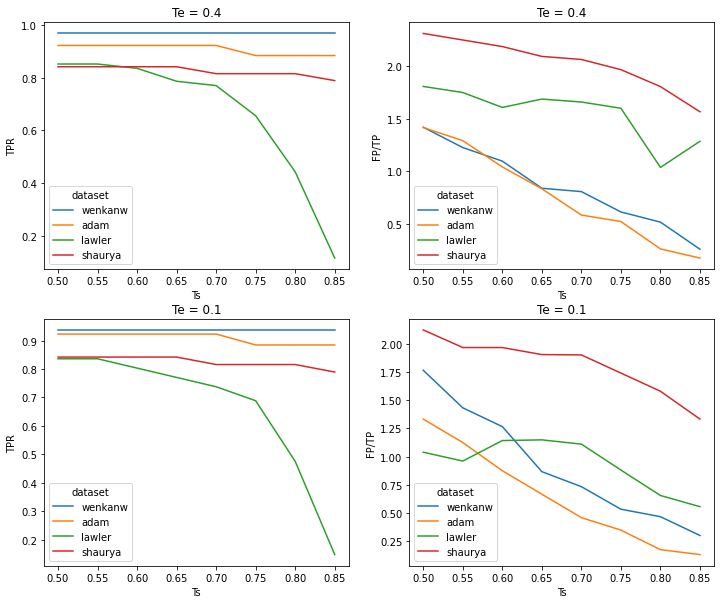

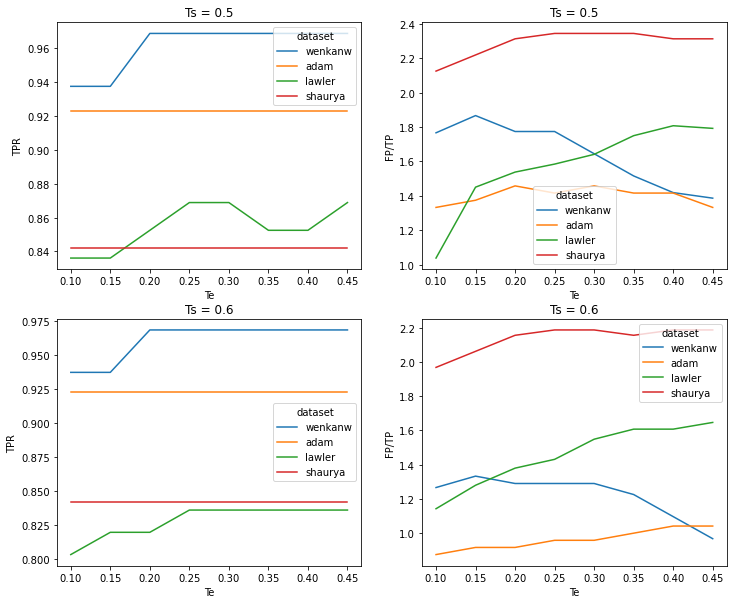

In [78]:
plot_threshold_results(threshold_results)

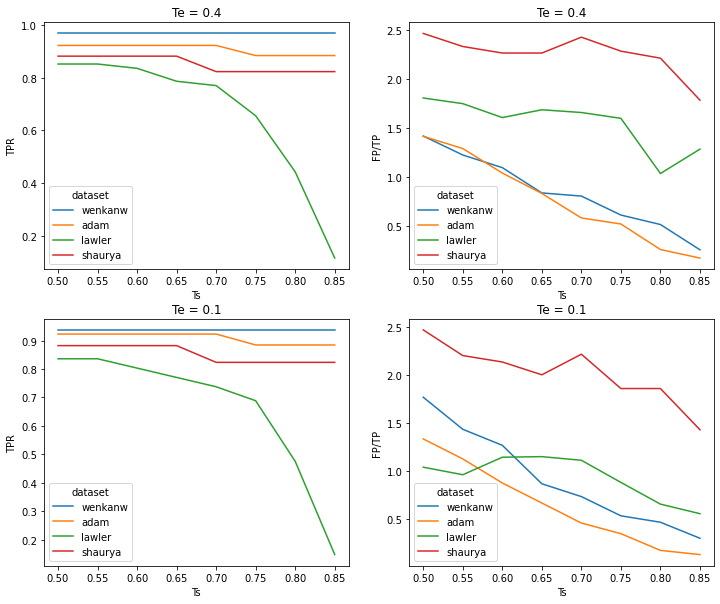

In [25]:
fig, ax= plt.subplots(2,2, figsize=(12,10))
te_val = 0.4
th_df = threshold_results[(threshold_results['Te']==te_val)]
_ = sns.lineplot(data=th_df, x="Ts", y= "TPR", hue="dataset",ax=ax[0,0])
_ = sns.lineplot(data=th_df, x="Ts", y= "FP/TP", hue="dataset",ax=ax[0,1])
_ = ax[0,0].set_title("Te = "+str(te_val))
_ = ax[0,1].set_title("Te = "+str(te_val))

te_val = 0.1
th_df = threshold_results[(threshold_results['Te']==te_val)]
_ = sns.lineplot(data=th_df, x="Ts", y= "TPR", hue="dataset",ax=ax[1,0])
_ = sns.lineplot(data=th_df, x="Ts", y= "FP/TP", hue="dataset",ax=ax[1,1])
_ = ax[1,0].set_title("Te = "+str(te_val))
_ = ax[1,1].set_title("Te = "+str(te_val))

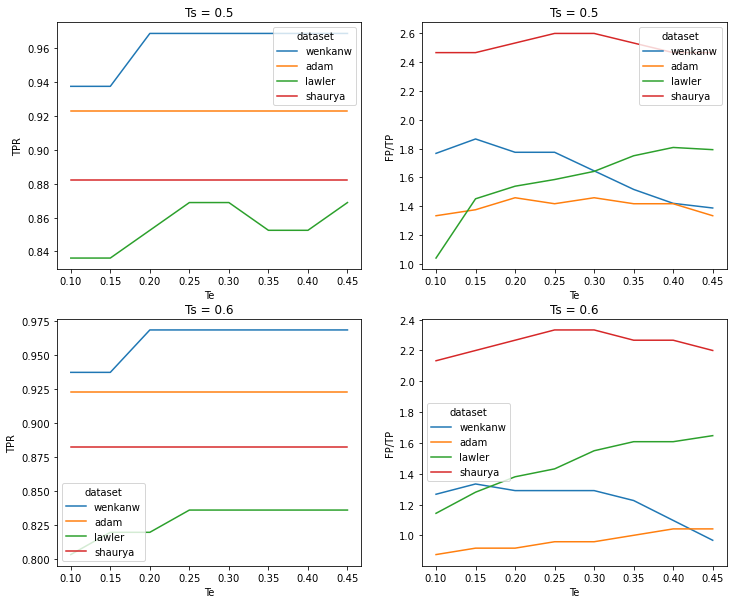

In [26]:
fig, ax= plt.subplots(2,2, figsize=(12,10))
ts_val = 0.5
th_df = threshold_results[(threshold_results['Ts']==ts_val)]
_ = sns.lineplot(data=th_df, x="Te", y= "TPR", hue="dataset",ax=ax[0,0])
_ = sns.lineplot(data=th_df, x="Te", y= "FP/TP", hue="dataset",ax=ax[0,1])
_ = ax[0,0].set_title("Ts = "+str(ts_val))
_ = ax[0,1].set_title("Ts = "+str(ts_val))

ts_val = 0.6
th_df = threshold_results[(threshold_results['Ts']==ts_val)]
_ = sns.lineplot(data=th_df, x="Te", y= "TPR", hue="dataset",ax=ax[1,0])
_ = sns.lineplot(data=th_df, x="Te", y= "FP/TP", hue="dataset",ax=ax[1,1])
_ = ax[1,0].set_title("Ts = "+str(ts_val))
_ = ax[1,1].set_title("Ts = "+str(ts_val))

In [77]:
def find_optimal_threshold(threshold_results,mode="min_fp", min_tpr= 0.85, max_fp=1.):
    best_threshold = pd.DataFrame()
    for person in threshold_results["dataset"].unique():
        df= threshold_results.loc[threshold_results['dataset']==person]
        if mode =="min_fp":
            # find min FP/TP with TPR inside range
            df= df.loc[threshold_results["TPR"]>min_tpr]
            df = df.iloc[df["FP/TP"].argmin()]
        else:
            # find max TPR with FP/TP inside range
            df = df.loc[df["FP/TP"]<max_fp]
            df= df.iloc[threshold_results["TPR"].argmax()]
            
        best_threshold = best_threshold.append(df)
        thresholds = {}
        for name in best_threshold['dataset'].values:
            thresholds[name] = [ best_threshold[best_threshold['dataset']==name]['Ts'].values[0] ,
                                best_threshold[best_threshold['dataset']==name]['Te'].values[0] ]
        #best_threshold[["dataset","Ts","Te"]]
    best_threshold = best_threshold[["dataset","Ts","Te","TPR","FP/TP","TP","FP","FN"]]
    return best_threshold , thresholds



In [122]:
# best_threshold ,hythreshold2  = find_optimal_threshold(threshold_results,min_tpr= 0.8, max_fp=2.5, mode= "min_fp")
best_threshold ,hythreshold2  = find_optimal_threshold(threshold_results,min_tpr= 0.8, max_fp=1.5, mode= "max")
best_threshold #, hythreshold2 

,FN,FP,FP/TP,TP,TPR,Te,Ts,dataset
8,2.0,43.0,1.433333,30.0,0.937500,0.1,0.55,wenkanw
66,2.0,35.0,1.458333,24.0,0.923077,0.2,0.50,adam
136,10.0,49.0,0.960784,51.0,0.836066,0.1,0.55,lawler
250,8.0,44.0,1.466667,30.0,0.789474,0.2,0.85,shaurya


In [102]:
# hythreshold2 = {'wenkanw':[0.85, 0.4], 'adam':[0.85,0.1],'lawler':[0.55,0.25], 'shaurya':[0.65,0.1]}

In [115]:
%time all_data_episode_perf_df = test_models_episode_metric(winmin=6, stridesec = 5,\
                                                            names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000, \
                                                            test_balance=False, test_CAD=False,test_alldata=True, \
                                                            threshold=hythreshold2,  use_group_threshold=2)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

100%|██████████| 17/17 [00:00<00:00, 404.54it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  16 FN:  1
       TPR     FP/TP  TP  FP  FN
0  0.96875  0.516129  31  16   1
Segmentation Completed. 
total_meal: 32 TP:  20 FP:  6 FN:  12
     TPR  FP/TP  TP  FP  FN
0  0.625    0.3  20   6  12
Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2

100%|██████████| 14/14 [00:00<00:00, 342.35it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  5 FN:  3
        TPR     FP/TP  TP  FP  FN
0  0.884615  0.217391  23   5   3
Segmentation Completed. 
total_meal: 26 TP:  24 FP:  8 FN:  2
        TPR     FP/TP  TP  FP  FN
0  0.923077  0.333333  24   8   2
Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/11.2/11.2.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/11.15/11.15.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.11/11.11.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.s

100%|██████████| 23/23 [00:00<00:00, 408.94it/s]

Segmentation Completed. 
total_meal: 61 TP:  27 FP:  26 FN:  34
        TPR     FP/TP  TP  FP  FN
0  0.442623  0.962963  27  26  34


Segmentation Completed. 
total_meal: 61 TP:  20 FP:  52 FN:  41
        TPR  FP/TP  TP  FP  FN
0  0.327869    2.6  20  52  41
Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.13.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.11.2021/Consensys Ex

100%|██████████| 13/13 [00:00<00:00, 290.24it/s]


Segmentation Completed. 
total_meal: 38 TP:  31 FP:  55 FN:  7
        TPR     FP/TP  TP  FP  FN
0  0.815789  1.774194  31  55   7
Segmentation Completed. 
total_meal: 38 TP:  30 FP:  25 FN:  8
        TPR     FP/TP  TP  FP  FN
0  0.789474  0.833333  30  25   8
CPU times: user 14.4 s, sys: 351 ms, total: 14.8 s
Wall time: 14.9 s


In [116]:
episode_metrics = print_episode_metrics(all_data_episode_perf_df)
episode_metrics

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.625,0.516,0.3,31,20,16,6,1,12
1,adam,14,3,26,360,0.885,0.923,0.217,0.333,23,24,5,8,3,2
2,lawler,23,25,61,360,0.443,0.328,0.963,2.6,27,20,26,52,34,41
3,shaurya,13,9,38,360,0.816,0.789,1.774,0.833,31,30,55,25,7,8
4,average performance,-,-,-,-,0.778,0.666,0.867,1.016,28,23.5,25.5,22.75,11.25,15.75


In [117]:
episode_metrics.to_csv("../results/episode_metrics/updated_subjects_alldata_best_thresholds_episode_metrics_group_paramters.csv")

In [118]:
%time all_data_episode_perf_df = test_models_episode_metric(winmin=6, stridesec = 5,\
                                                            names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000, \
                                                            test_balance=False, test_CAD=False,test_alldata=True, \
                                                            threshold=hythreshold2,  use_group_threshold=1)

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

100%|██████████| 17/17 [00:00<00:00, 396.65it/s]


Segmentation Completed. 
total_meal: 32 TP:  31 FP:  8 FN:  1
       TPR     FP/TP  TP  FP  FN
0  0.96875  0.258065  31   8   1
Segmentation Completed. 
total_meal: 32 TP:  20 FP:  6 FN:  12
     TPR  FP/TP  TP  FP  FN
0  0.625    0.3  20   6  12
Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-20

100%|██████████| 14/14 [00:00<00:00, 344.43it/s]


Segmentation Completed. 
total_meal: 26 TP:  23 FP:  3 FN:  3
        TPR     FP/TP  TP  FP  FN
0  0.884615  0.130435  23   3   3
Segmentation Completed. 
total_meal: 26 TP:  24 FP:  8 FN:  2
        TPR     FP/TP  TP  FP  FN
0  0.923077  0.333333  24   8   2
Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/11.2/11.2.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/11.15/11.15.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.11/11.11.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.s

  0%|          | 0/23 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 61 TP:  51 FP:  49 FN:  10
        TPR     FP/TP  TP  FP  FN
0  0.836066  0.960784  51  49  10


100%|██████████| 23/23 [00:00<00:00, 410.09it/s]


Segmentation Completed. 
total_meal: 61 TP:  20 FP:  52 FN:  41
        TPR  FP/TP  TP  FP  FN
0  0.327869    2.6  20  52  41
Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.13.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.11.2021/Consensys Ex

100%|██████████| 13/13 [00:00<00:00, 292.82it/s]


Segmentation Completed. 
total_meal: 38 TP:  31 FP:  49 FN:  7
        TPR     FP/TP  TP  FP  FN
0  0.815789  1.580645  31  49   7
Segmentation Completed. 
total_meal: 38 TP:  30 FP:  25 FN:  8
        TPR     FP/TP  TP  FP  FN
0  0.789474  0.833333  30  25   8
CPU times: user 14.5 s, sys: 472 ms, total: 14.9 s
Wall time: 15.6 s


In [119]:
episode_metrics = print_episode_metrics(all_data_episode_perf_df)
episode_metrics.to_csv("../results/episode_metrics/updated_subjects_alldata_best_thresholds_episode_metrics_individual_paramters.csv")

In [120]:
episode_metrics

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.625,0.258,0.3,31,20,8,6,1,12
1,adam,14,3,26,360,0.885,0.923,0.13,0.333,23,24,3,8,3,2
2,lawler,23,25,61,360,0.836,0.328,0.961,2.6,51,20,49,52,10,41
3,shaurya,13,9,38,360,0.816,0.789,1.581,0.833,31,30,49,25,7,8
4,average performance,-,-,-,-,0.876,0.666,0.732,1.016,34,23.5,27.25,22.75,5.25,15.75


## 4.5 update data 

In [113]:
pd.read_csv("../results/episode_metrics/"+str(4)+"_subjects_alldata_best_thresholds_episode_metrics.csv")

,Unnamed: 0,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,0,wenkanw,17,7,32,360,0.969,0.500,0.258,0.188,31.0,16.00,8.00,3.00,1.0,16.00
1,1,adam,14,3,26,360,0.885,0.808,0.130,0.095,23.0,21.00,3.00,2.00,3.0,5.00
2,2,lawler,23,25,61,360,0.869,0.721,1.396,1.659,53.0,44.00,74.00,73.00,8.0,17.00
3,3,shaurya,6,3,17,360,0.882,0.824,2.000,0.786,15.0,14.00,30.00,11.00,2.0,3.00
4,4,average performance,-,-,-,-,0.901,0.713,0.946,0.682,30.5,23.75,28.75,22.25,3.5,10.25


In [37]:
# np.quantile(proba_df[label_df==1], q= [0.4,0.5])
# np.histogram(proba_df[label_df==1], bins=[0.1*i for i in range(10)])
# y, x = np.histogram(proba_df[label_df==0], bins=[0.05*i for i in range(20)])
# y = y/(sum(y))
# y2, x2 = np.histogram(proba_df[label_df==1], bins=[0.05*i for i in range(20)])
# y2 = y2/(sum(y2))
# x_axis = []
# for i in range(1,len(x)):
#     x_axis.append((x[i-1]+x[i])/2)
# fig,ax = plt.subplots(1,1,figsize=(10,5))
# # plt.plot(x=x_axis,height=y, width = 0.15)
# # plt.plot(x=x_axis,height=y2, width = 0.15)
# # plt.plot(x_axis, y)
# # plt.plot(x_axis, y2)
# plt.hist([y], bins = 20, 
#          color = ['b'], label=x_axis)
# # x_axis,y

## 3.3 Cross-Validation for individual model and compare with group model

In [20]:

def cross_validation_metrics(model_arch,names= ["wenkanw"], fold_num = 5, winmin=6, stridesec = 5,model_name= "acti_model",epochs = 20,
                                 random_seed=1000, split_day=False, test_balance=False, re_train = False,load_data=True,
                                 test_CAD=False, metrics =['time','episode'], ind_threshold= None,load_proba_flag=True):
    
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score, precision_score
    batch_size = 128
    time_perf = defaultdict(list)
    episode_perf = defaultdict(list)
    meal_info = defaultdict(list)
    time_individual_perf = defaultdict(list)
    episode_individual_perf = defaultdict(list)
    time_group_perf = defaultdict(list)
    episode_group_perf = defaultdict(list)
    
    group_threshold = [0.8,0.3] #{'wenkanw':, 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}
                
    model = None
    kf = KFold(n_splits=5, random_state= 1000,shuffle=False)
    # Don't test on CAD test set if it is not enabled
    if not test_CAD and "CAD" in names:
        names.remove("CAD")
    
    
    for name in names:
        #load individual whole dataset
        person = name
        meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
        samples,labels =  meal_data.data_indices, meal_data.labels
            
        if name !="CAD":
            meal_counts, min_counts,hour_counts, day_counts,total_hours = meal_data.get_mealdataset_info(person_name=name, file_ls_doc="all_files_list.txt")
        else:
            # data from paper
            meal_counts, min_counts,hour_counts, day_counts,total_hours = 1063, 250*60,250, 354, 4680
        meal_info["dataset"].append(name)
        meal_info["Days"].append(day_counts)
        meal_info["Meal_Hours"].append(round(hour_counts,1)) 
        meal_info["Meal_Counts"].append(meal_counts) 
        meal_info["Total_Hours"].append(total_hours) 
        
        time_perf["dataset"].append(name)
        time_perf["win(sec)"].append(winmin*60)
        
        episode_perf["dataset"].append(name)
        episode_perf["win(sec)"].append(winmin*60)
        
        days = np.unique(meal_data.data_indices[:,0])
        samples,labels =  meal_data.data_indices, meal_data.labels
#         samples,labels = meal_data.get_subset([i for i in range(len(meal_data.labels))])

        # K-fold cross validation
        for fold, (day_train_idx, day_test_idx) in enumerate(kf.split(days)):
            print("Fold: %d"%(fold),"Train on days: ",day_train_idx, "Test on days: ",day_test_idx)
            day_train_idx = day_train_idx.tolist()
            day_test_idx = day_test_idx.tolist()
            train_indices = []
            test_indices = []
            # partition dataset by days
            for i, day in enumerate(meal_data.data_indices[:,0]):
                if day in day_train_idx:
                    train_indices.append(i)
                else:
                    test_indices.append(i)
#             print("Train indices: ", train_indices)
#             print("Test indices: ", test_indices)
#             assert False
            # balance train set
            trainset_labels = labels[train_indices]
            train_indices_balanced = balance_data_indices(trainset_labels,data_indices= train_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            
            testset_labels = labels[test_indices]
            if test_balance:
                #balance test set
                test_indices = balance_data_indices(testset_labels,data_indices= test_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            else:
                test_indices = test_indices 
                   
            
            # split validation set
            balanced_trainset_labels = labels[train_indices_balanced]
            train_indices, valid_indices = split_train_test_indices(X= train_indices_balanced,
                                                                    y = balanced_trainset_labels, test_size = 0.2,
                                                                   random_seed = random_seed)
                    
            if not load_data and "time" not in metrics:
                balancedData, balancedLabels = meal_data.get_subset([])
                valid_balancedData, valid_balancedLabels = meal_data.get_subset([])
                test_Data, test_Labels = meal_data.get_subset([])
            else:
                # Get numpy dataset: balanced trainset, validation set, test set
                balancedData, balancedLabels = meal_data.get_subset(train_indices)
                valid_balancedData, valid_balancedLabels = meal_data.get_subset(valid_indices)
                test_Data, test_Labels = meal_data.get_subset(test_indices)

                # balancedData, balancedLabels = samples[train_indices],labels[train_indices]  
                # valid_balancedData, valid_balancedLabels = samples[valid_indices],labels[valid_indices] 
                # test_Data, test_Labels = samples[test_indices],labels[test_indices]

                print("Train on : ", sum(balancedLabels==1),"positive samples, ",sum(balancedLabels==0)," negative samples" )
                print("Testing on : ", sum(valid_balancedLabels==1),"positive samples, ",sum(valid_balancedLabels==0)," negative samples" )
                print("Testing on : ", sum(test_Labels==1),"positive samples, ",sum(test_Labels==0)," negative samples" )
            
            
            #train models
            pathtemp = "../models/" + name+"_models" +"/"+"cv_fold_"+str(fold) +"_"+model_name+"_M_F_"
            modelpath = pathtemp + "{:f}Min.h5".format(winmin)
            jsonpath = pathtemp + "{:f}Min.json".format(winmin)
            
            # if model doesn't exist or re_train is enabled, then re_trian
            # otherwise, just load model
            if not os.path.isfile(modelpath) or re_train:
                #training settings
                win_size = 15*winmin*60
                model =model_arch(input_shape =(win_size,6) )
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
                
                mcp_save = tf.keras.callbacks.ModelCheckpoint(modelpath, save_best_only=True, monitor='val_accuracy')
                scheduler = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=3, verbose=0,
                                                     mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.)
                ##########train model ###############
                H = model.fit(x=balancedData, y = balancedLabels,
                               validation_data=(valid_balancedData, valid_balancedLabels),
                            epochs = epochs, batch_size=batch_size, verbose=1,
                            callbacks=[mcp_save,scheduler]) # removed addons.LossHistory(jsonpath) for compatibility with TensorFlow 2.2.0, needs to be re-added at some point

                print("Max value: ", max(H.history['accuracy']), " at epoch", np.argmax(H.history['accuracy']) + 1)
                print("Model saved to path: ",modelpath)
            else:
                model  = tf.keras.models.load_model(modelpath)
                
            # obtain individual model and pre-trained group model
            individual_model = model
            group_model_W  = tf.keras.models.load_model('../models/CAD_models/acti_6min_M_F_6.000000Min.h5')
            models = {"suffix":['Individual-Model','GroupModel'],  "model":[individual_model,group_model_W]}
            
            ##### Test models####
            ############ Time metrics ##########
            if 'time' in metrics:
                for i in range(len(models["suffix"])):
                    suffix = models["suffix"][i]
                    model = models["model"][i]
                    # if the dataset is CAD group dataset and model is individual model
                    # we don't need to make prediction on that data
                    if name == "CAD" and suffix =='Individual-Model':
                        acc = None
                        auc = None
                        recall = None
                    else:

                        predictions = model.predict(x=test_Data).squeeze(1)
                        threshold = 0.5
                        prediction = (predictions>=threshold).astype(int)
                        wacc =  balanced_accuracy_score(test_Labels,prediction)
                        acc =  accuracy_score(test_Labels,prediction)
                        recall = recall_score(test_Labels,prediction)
                        f1 = f1_score(test_Labels,prediction)
                        precision = precision_score(test_Labels,prediction)
                        # weighted accuracy 2 is computed by (weight*TP +TN)/(weight*(TP+FN) + (TN+FP))
                        wacc2 = weight_accuracy(test_Labels,prediction,print_flag=False)
                        
                        # store performance for one fold 
                        if suffix == "GroupModel":
                            time_group_perf["WAcc: "+suffix].append(wacc)
                            time_group_perf["WAcc2: "+suffix].append(wacc2)
                            time_group_perf["Recall: "+suffix].append(recall)
                            time_group_perf["Precision: "+suffix].append(precision)
                            time_group_perf["F1: "+suffix].append(f1)
                            time_group_perf["Acc: "+suffix].append(acc)
                        else:
                            time_individual_perf["WAcc: "+suffix].append(wacc)
                            time_individual_perf["WAcc2: "+suffix].append(wacc2)
                            time_individual_perf["Recall: "+suffix].append(recall)
                            time_individual_perf["Precision: "+suffix].append(precision)
                            time_individual_perf["F1: "+suffix].append(f1)
                            time_individual_perf["Acc: "+suffix].append(acc)
                            

            ######## episode metric ############
            if "episode" in metrics:
                proba_path ="../results/possibility_results/"+person +"/cv_fold_"+str(fold)+"_"
                for i in range(len(models["suffix"])):
                    suffix = models["suffix"][i]
                    model = models["model"][i]
                    result_path = proba_path
                    if suffix == "GroupModel":
                        result_path += "group_"
                        high_th, low_th  = group_threshold[0],group_threshold[1]
                    else:
                        if ind_threshold:
                            high_th, low_th  = ind_threshold[name][0],ind_threshold[name][1] 
                        else:
                            high_th, low_th  = group_threshold[0],group_threshold[1]
                        
                    result = hysteresis_threshold(model, meal_data,days_ls = day_test_idx,start_threshold=high_th, end_threshold=low_th,
                                                  winmin = winmin, stepsec=stridesec, episode_min = 1.,
                                                 load_proba_flag=load_proba_flag, path =result_path)
                    episode_perf_df = get_episode_metrics(result,meal_data,days_ls = day_test_idx)
                    
                    TP = episode_perf_df["TP"].iloc[0]
                    FP = episode_perf_df["FP"].iloc[0]
                    FN = episode_perf_df["FN"].iloc[0]
                    if suffix == "GroupModel":
                        episode_group_perf["TP: "+suffix].append(TP)
                        episode_group_perf["FP: "+suffix].append(FP)
                        episode_group_perf["FN: "+suffix].append(FN)
                    else:
                        episode_individual_perf["TP: "+suffix].append(TP)
                        episode_individual_perf["FP: "+suffix].append(FP)
                        episode_individual_perf["FN: "+suffix].append(FN)

        if 'time' in metrics:
            for key in  time_group_perf.keys():
                time_perf[key].append(  np.mean(time_group_perf[key])) 
                time_group_perf[key].clear()
                
            for key in  time_individual_perf.keys():
                time_perf[key].append(  np.mean(time_individual_perf[key])) 
                time_individual_perf[key].clear()
                
        if 'episode' in metrics:
            for key in episode_group_perf.keys():
                episode_perf[key].append(  np.sum(episode_group_perf[key])) 
                episode_group_perf[key].clear()
            for key in episode_individual_perf.keys():
                episode_perf[key].append(  np.sum(episode_individual_perf[key])) 
                episode_individual_perf[key].clear()
            
    meal_info = pd.DataFrame(meal_info)
    episode_perf = pd.DataFrame(episode_perf)
    time_perf = pd.DataFrame(time_perf)
    # Compute TPR, FP/TP for all models
    for suffix in ['Individual-Model','GroupModel']:
            episode_perf["TPR: "+suffix] = episode_perf['TP: '+suffix]/(episode_perf['TP: '+suffix] + episode_perf['FN: '+suffix])
            episode_perf['FP/TP: '+suffix] = episode_perf['FP: '+suffix]/episode_perf['TP: '+suffix]
            
    return meal_info, time_perf,episode_perf

In [30]:
hy_threshold = {'wenkanw':[0.8,0.3], 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}

%time meal_info, time_perf,episode_perf = cross_validation_metrics(acti_model, fold_num = 5, winmin=6, stridesec = 5, \
                                                             names= ["adam"],model_name= "acti_model", load_proba_flag=False,\
                                                             random_seed=random_seed,  test_balance=False, re_train = False, load_data=False,\
                                                             test_CAD=False, metrics =['time','episode'], ind_threshold =hy_threshold)

/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-02-2020/12-02-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-04-2020/12-04-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-09-2020/12-09-2020.shm
Loading File:  ../

100%|██████████| 3/3 [00:00<00:00, 69.44it/s]

--- Day 2: 8.141347646713257 seconds ---
File ../results/possibility_results/cv_fold_0_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


--- Day 0: 14.116262435913086 seconds ---
--- Day 1: 11.037872791290283 seconds ---


100%|██████████| 3/3 [00:00<00:00, 57.01it/s]

--- Day 2: 8.357845067977905 seconds ---
File ../results/possibility_results/cv_fold_0_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]


Train set size: 3008, with 1504 positive samples and 1504 negative samples
Test set size: 752, with 376 positive samples and 376 negative samples
Train on :  1504 positive samples,  1504  negative samples
Testing on :  376 positive samples,  376  negative samples
Testing on :  351 positive samples,  13121  negative samples
Epoch 1/20
24/24 [==============================] - 8s 320ms/step - loss: 2.2046 - accuracy: 0.5941 - val_loss: 1.8907 - val_accuracy: 0.6582
Epoch 2/20
24/24 [==============================] - 8s 325ms/step - loss: 1.5936 - accuracy: 0.8059 - val_loss: 1.3073 - val_accuracy: 0.8471
Epoch 3/20
24/24 [==============================] - 7s 308ms/step - loss: 1.0850 - accuracy: 0.9033 - val_loss: 0.9177 - val_accuracy: 0.9109
Epoch 4/20
24/24 [==============================] - 8s 320ms/step - loss: 0.7643 - accuracy: 0.9468 - val_loss: 0.6572 - val_accuracy: 0.9455
Epoch 5/20
24/24 [==============================] - 7s 307ms/step - loss: 0.5762 - accuracy: 0.9598 - val_l

100%|██████████| 3/3 [00:00<00:00, 108.19it/s]

--- Day 5: 4.590133190155029 seconds ---
File ../results/possibility_results/cv_fold_1_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0


--- Day 3: 6.79994535446167 seconds ---
--- Day 4: 9.668309688568115 seconds ---


100%|██████████| 3/3 [00:00<00:00, 113.86it/s]

--- Day 5: 4.425886631011963 seconds ---
File ../results/possibility_results/cv_fold_1_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]


Train set size: 2892, with 1446 positive samples and 1446 negative samples
Test set size: 724, with 362 positive samples and 362 negative samples
Train on :  1446 positive samples,  1446  negative samples
Testing on :  362 positive samples,  362  negative samples
Testing on :  423 positive samples,  19063  negative samples
Epoch 1/20
23/23 [==============================] - 7s 313ms/step - loss: 2.1955 - accuracy: 0.5557 - val_loss: 1.9108 - val_accuracy: 0.7928
Epoch 2/20
23/23 [==============================] - 7s 319ms/step - loss: 1.6416 - accuracy: 0.8216 - val_loss: 1.3256 - val_accuracy: 0.8702
Epoch 3/20
23/23 [==============================] - 7s 304ms/step - loss: 1.0947 - accuracy: 0.9084 - val_loss: 0.9128 - val_accuracy: 0.9171
Epoch 4/20
23/23 [==============================] - 7s 324ms/step - loss: 0.7789 - accuracy: 0.9350 - val_loss: 0.7012 - val_accuracy: 0.9240
Epoch 5/20
23/23 [==============================] - 7s 305ms/step - loss: 0.6293 - accuracy: 0.9357 - val_l

100%|██████████| 3/3 [00:00<00:00, 75.39it/s]

--- Day 8: 8.232221364974976 seconds ---
File ../results/possibility_results/cv_fold_2_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


--- Day 6: 10.35539984703064 seconds ---
--- Day 7: 9.929852962493896 seconds ---


100%|██████████| 3/3 [00:00<00:00, 73.57it/s]

--- Day 8: 8.275865316390991 seconds ---
File ../results/possibility_results/cv_fold_2_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]


Train set size: 3051, with 1525 positive samples and 1526 negative samples
Test set size: 763, with 382 positive samples and 381 negative samples
Train on :  1525 positive samples,  1526  negative samples
Testing on :  382 positive samples,  381  negative samples
Testing on :  324 positive samples,  16527  negative samples
Epoch 1/20
24/24 [==============================] - 8s 329ms/step - loss: 2.2158 - accuracy: 0.4979 - val_loss: 1.9126 - val_accuracy: 0.5714
Epoch 2/20
24/24 [==============================] - 8s 331ms/step - loss: 1.6320 - accuracy: 0.7322 - val_loss: 1.2514 - val_accuracy: 0.9161
Epoch 3/20
24/24 [==============================] - 8s 318ms/step - loss: 1.0088 - accuracy: 0.9295 - val_loss: 0.7839 - val_accuracy: 0.9567
Epoch 4/20
24/24 [==============================] - 8s 321ms/step - loss: 0.6904 - accuracy: 0.9518 - val_loss: 0.5806 - val_accuracy: 0.9646
Epoch 5/20
24/24 [==============================] - 8s 327ms/step - loss: 0.5169 - accuracy: 0.9662 - val_l

100%|██████████| 3/3 [00:00<00:00, 88.29it/s]

--- Day 11: 9.62473750114441 seconds ---
File ../results/possibility_results/cv_fold_3_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  1


--- Day 9: 4.712034702301025 seconds ---
--- Day 10: 11.147453784942627 seconds ---


100%|██████████| 3/3 [00:00<00:00, 89.33it/s]

--- Day 11: 10.589156866073608 seconds ---
File ../results/possibility_results/cv_fold_3_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  1
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]


Train set size: 2790, with 1395 positive samples and 1395 negative samples
Test set size: 698, with 349 positive samples and 349 negative samples
Train on :  1395 positive samples,  1395  negative samples
Testing on :  349 positive samples,  349  negative samples
Testing on :  487 positive samples,  16366  negative samples
Epoch 1/20
22/22 [==============================] - 7s 320ms/step - loss: 2.2583 - accuracy: 0.5498 - val_loss: 1.9703 - val_accuracy: 0.6547
Epoch 2/20
22/22 [==============================] - 7s 312ms/step - loss: 1.7279 - accuracy: 0.7434 - val_loss: 1.4327 - val_accuracy: 0.8610
Epoch 3/20
22/22 [==============================] - 7s 338ms/step - loss: 1.1895 - accuracy: 0.9065 - val_loss: 0.9607 - val_accuracy: 0.9241
Epoch 4/20
22/22 [==============================] - 7s 301ms/step - loss: 0.8281 - accuracy: 0.9606 - val_loss: 0.7180 - val_accuracy: 0.9427
Epoch 5/20
22/22 [==============================] - 7s 322ms/step - loss: 0.6512 - accuracy: 0.9584 - val_l

100%|██████████| 2/2 [00:00<00:00, 57.48it/s]

--- Day 13: 13.068859338760376 seconds ---
File ../results/possibility_results/cv_fold_4_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0


--- Day 12: 12.34238338470459 seconds ---


100%|██████████| 2/2 [00:00<00:00, 61.01it/s]

--- Day 13: 12.741510391235352 seconds ---
File ../results/possibility_results/cv_fold_4_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  0 FN:  0
CPU times: user 46min 40s, sys: 2min 18s, total: 48min 58s
Wall time: 20min 25s


In [31]:
episode_perf

,dataset,win(sec),TP: GroupModel,FP: GroupModel,FN: GroupModel,TP: Individual-Model,FP: Individual-Model,FN: Individual-Model,TPR: Individual-Model,FP/TP: Individual-Model,TPR: GroupModel,FP/TP: GroupModel
0,adam,360,24,8,2,24,8,2,0.923077,0.333333,0.923077,0.333333


In [53]:
#meal_info 
#time_perf
episode_perf

,dataset,win(sec),TP: GroupModel,FP: GroupModel,FN: GroupModel,TP: Individual-Model,FP: Individual-Model,FN: Individual-Model,TPR: Individual-Model,FP/TP: Individual-Model,TPR: GroupModel,FP/TP: GroupModel
0,adam,360,24,8,2,23,12,3,0.884615,0.521739,0.923077,0.333333


In [54]:
time_perf

,dataset,win(sec),WAcc: GroupModel,WAcc2: GroupModel,Recall: GroupModel,Precision: GroupModel,F1: GroupModel,Acc: GroupModel,WAcc: Individual-Model,WAcc2: Individual-Model,Recall: Individual-Model,Precision: Individual-Model,F1: Individual-Model,Acc: Individual-Model
0,adam,360,0.95635,0.941543,0.983465,0.28442,0.433046,0.930626,0.953326,0.964728,0.931514,0.554658,0.670284,0.973953


In [32]:

hy_threshold = {'wenkanw':[0.8,0.3], 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}

%time meal_info, time_perf1,episode_perf1 = cross_validation_metrics(acti_model, fold_num = 5, winmin=6, stridesec = 5, \
                                                             names= ["wenkanw","adam","lawler","shaurya"],model_name= "acti_model", \
                                                             random_seed=random_seed,  test_balance=False, re_train = False, \
                                                             test_CAD=False, metrics =['time','episode'], load_data =True, ind_threshold =hy_threshold)

episode_perf1 = pd.merge(left=meal_info,right=episode_perf1,on="dataset")

/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

100%|██████████| 4/4 [00:00<00:00, 270.02it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  4 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  3 FP:  2 FN:  4
Fold: 1 Train on days:  [ 0  1  2  3  8  9 10 11 12 13 14 15 16] Test on days:  [4 5 6 7]
Train set size: 7209, with 3604 positive samples and 3605 negative samples
Test set size: 1803, with 902 positive samples and 901 negative samples
Train on :  3604 positive samples,  3605  negative samples
Testing on :  902 positive samples,  901  negative samples
Testing on :  956 positive samples,  14209  negative samples


100%|██████████| 4/4 [00:00<00:00, 407.14it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  4 FP:  1 FN:  3
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16] Test on days:  [ 8  9 10]
Train set size: 7222, with 3611 positive samples and 3611 negative samples
Test set size: 1806, with 903 positive samples and 903 negative samples
Train on :  3611 positive samples,  3611  negative samples
Testing on :  903 positive samples,  903  negative samples
Testing on :  948 positive samples,  21106  negative samples


100%|██████████| 3/3 [00:00<00:00, 242.21it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  7 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  3 FN:  1
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 14 15 16] Test on days:  [11 12 13]
Train set size: 6971, with 3485 positive samples and 3486 negative samples
Test set size: 1743, with 872 positive samples and 871 negative samples
Train on :  3485 positive samples,  3486  negative samples
Testing on :  872 positive samples,  871  negative samples
Testing on :  1105 positive samples,  16007  negative samples


100%|██████████| 3/3 [00:00<00:00, 233.48it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  0 FN:  2
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] Test on days:  [14 15 16]
Train set size: 6923, with 3461 positive samples and 3462 negative samples
Test set size: 1731, with 866 positive samples and 865 negative samples
Train on :  3461 positive samples,  3462  negative samples
Testing on :  866 positive samples,  865  negative samples
Testing on :  1135 positive samples,  13705  negative samples


100%|██████████| 3/3 [00:00<00:00, 319.18it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  3 FP:  0 FN:  2
Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-02-2020/12-02-2020.shm
Loading File:  ../data/IndividualData/adam-d

100%|██████████| 3/3 [00:00<00:00, 49.49it/s]

--- Day 2: 10.21653699874878 seconds ---
File ../results/possibility_results/cv_fold_0_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 26 TP:  6 FP:  6 FN:  0
--- Day 0: 15.713119745254517 seconds ---
--- Day 1: 12.712241649627686 seconds ---


100%|██████████| 3/3 [00:00<00:00, 61.99it/s]

--- Day 2: 11.58244276046753 seconds ---
File ../results/possibility_results/cv_fold_0_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]


Train set size: 3008, with 1504 positive samples and 1504 negative samples
Test set size: 752, with 376 positive samples and 376 negative samples
Train on :  1504 positive samples,  1504  negative samples
Testing on :  376 positive samples,  376  negative samples
Testing on :  351 positive samples,  13121  negative samples
--- Day 3: 7.209411859512329 seconds ---
--- Day 4: 10.740944862365723 seconds ---


100%|██████████| 3/3 [00:00<00:00, 57.76it/s]

--- Day 5: 5.387242317199707 seconds ---
File ../results/possibility_results/cv_fold_1_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 26 TP:  3 FP:  0 FN:  1
--- Day 3: 8.053856611251831 seconds ---
--- Day 4: 11.321402072906494 seconds ---


100%|██████████| 3/3 [00:00<00:00, 73.42it/s]

--- Day 5: 5.104472637176514 seconds ---
File ../results/possibility_results/cv_fold_1_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]


Train set size: 2892, with 1446 positive samples and 1446 negative samples
Test set size: 724, with 362 positive samples and 362 negative samples
Train on :  1446 positive samples,  1446  negative samples
Testing on :  362 positive samples,  362  negative samples
Testing on :  423 positive samples,  19063  negative samples
--- Day 6: 12.847230911254883 seconds ---
--- Day 7: 11.35723614692688 seconds ---


100%|██████████| 3/3 [00:00<00:00, 66.66it/s]

--- Day 8: 8.987218141555786 seconds ---
File ../results/possibility_results/cv_fold_2_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


--- Day 6: 11.349854469299316 seconds ---
--- Day 7: 10.503172397613525 seconds ---


100%|██████████| 3/3 [00:00<00:00, 68.96it/s]

--- Day 8: 8.72013521194458 seconds ---
File ../results/possibility_results/cv_fold_2_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]


Train set size: 3051, with 1525 positive samples and 1526 negative samples
Test set size: 763, with 382 positive samples and 381 negative samples
Train on :  1525 positive samples,  1526  negative samples
Testing on :  382 positive samples,  381  negative samples
Testing on :  324 positive samples,  16527  negative samples
--- Day 9: 5.1176018714904785 seconds ---
--- Day 10: 12.250155210494995 seconds ---


100%|██████████| 3/3 [00:00<00:00, 87.08it/s]

--- Day 11: 11.495940923690796 seconds ---
File ../results/possibility_results/cv_fold_3_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


--- Day 9: 5.046202659606934 seconds ---
--- Day 10: 11.466514348983765 seconds ---


100%|██████████| 3/3 [00:00<00:00, 85.72it/s]

--- Day 11: 11.74047303199768 seconds ---
File ../results/possibility_results/cv_fold_3_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  1
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]


Train set size: 2790, with 1395 positive samples and 1395 negative samples
Test set size: 698, with 349 positive samples and 349 negative samples
Train on :  1395 positive samples,  1395  negative samples
Testing on :  349 positive samples,  349  negative samples
Testing on :  487 positive samples,  16366  negative samples
--- Day 12: 14.031123161315918 seconds ---


100%|██████████| 2/2 [00:00<00:00, 59.77it/s]

--- Day 13: 14.727800607681274 seconds ---
File ../results/possibility_results/cv_fold_4_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0


--- Day 12: 13.901410818099976 seconds ---


100%|██████████| 2/2 [00:00<00:00, 59.97it/s]

--- Day 13: 14.217175006866455 seconds ---
File ../results/possibility_results/cv_fold_4_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  0 FN:  0
Loading Dataset ...


Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/11.2/11.2.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/11.15/11.15.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.11/11.11.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.shm
Loading File:  ../data/IndividualData/lawler-data/9.25/9.25_1-46.shm
Loading File:  ../data/IndividualData/lawler-data/10.6/10.6.shm
Loading File:  ../data/IndividualData/lawler-data/10.4/10.4.shm
Loading File:  ../data/IndividualData/lawler-data/10.28/10.28.shm
Loading File: 

100%|██████████| 5/5 [00:00<00:00, 278.08it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  8 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  15 FN:  8
Fold: 1 Train on days:  [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22] Test on days:  [5 6 7 8 9]
Train set size: 5915, with 2957 positive samples and 2958 negative samples
Test set size: 1479, with 740 positive samples and 739 negative samples
Train on :  2957 positive samples,  2958  negative samples
Testing on :  740 positive samples,  739  negative samples
Testing on :  1533 positive samples,  35087  negative samples


100%|██████████| 5/5 [00:00<00:00, 241.46it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  14 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  2 FP:  13 FN:  11
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22] Test on days:  [10 11 12 13 14]
Train set size: 7139, with 3569 positive samples and 3570 negative samples
Test set size: 1785, with 893 positive samples and 892 negative samples
Train on :  3569 positive samples,  3570  negative samples
Testing on :  893 positive samples,  892  negative samples
Testing on :  768 positive samples,  18814  negative samples


100%|██████████| 5/5 [00:00<00:00, 392.62it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  8 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  2 FP:  10 FN:  8
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 19 20 21 22] Test on days:  [15 16 17 18]
Train set size: 6206, with 3103 positive samples and 3103 negative samples
Test set size: 1552, with 776 positive samples and 776 negative samples
Train on :  3103 positive samples,  3103  negative samples
Testing on :  776 positive samples,  776  negative samples
Testing on :  1351 positive samples,  17858  negative samples


100%|██████████| 4/4 [00:00<00:00, 257.85it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  6 FN:  7
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] Test on days:  [19 20 21 22]
Train set size: 7318, with 3659 positive samples and 3659 negative samples
Test set size: 1830, with 915 positive samples and 915 negative samples
Train on :  3659 positive samples,  3659  negative samples
Testing on :  915 positive samples,  915  negative samples
Testing on :  656 positive samples,  13442  negative samples


100%|██████████| 4/4 [00:00<00:00, 480.85it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  9 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  4 FP:  8 FN:  7
Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.13.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.11.2021/Consensys Export

100%|██████████| 3/3 [00:00<00:00, 199.69it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  8 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  8 FN:  1
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12] Test on days:  [3 4 5]
Train set size: 8523, with 4261 positive samples and 4262 negative samples
Test set size: 2131, with 1066 positive samples and 1065 negative samples
Train on :  4261 positive samples,  4262  negative samples
Testing on :  1066 positive samples,  1065  negative samples
Testing on :  1308 positive samples,  19774  negative samples


100%|██████████| 3/3 [00:00<00:00, 248.36it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  5 FN:  2
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12] Test on days:  [6 7 8]
Train set size: 8411, with 4205 positive samples and 4206 negative samples
Test set size: 2103, with 1052 positive samples and 1051 negative samples
Train on :  4205 positive samples,  4206  negative samples
Testing on :  1052 positive samples,  1051  negative samples
Testing on :  1378 positive samples,  22864  negative samples


100%|██████████| 3/3 [00:00<00:00, 186.80it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  5 FN:  0
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 11 12] Test on days:  [ 9 10]
Train set size: 8438, with 4219 positive samples and 4219 negative samples
Test set size: 2110, with 1055 positive samples and 1055 negative samples
Train on :  4219 positive samples,  4219  negative samples
Testing on :  1055 positive samples,  1055  negative samples
Testing on :  1361 positive samples,  12770  negative samples


100%|██████████| 2/2 [00:00<00:00, 236.19it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  3 FN:  1
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10] Test on days:  [11 12]
Train set size: 9217, with 4608 positive samples and 4609 negative samples
Test set size: 2305, with 1153 positive samples and 1152 negative samples
Train on :  4608 positive samples,  4609  negative samples
Testing on :  1153 positive samples,  1152  negative samples
Testing on :  874 positive samples,  11729  negative samples


100%|██████████| 2/2 [00:00<00:00, 274.87it/s]


Segmentation Completed. 
total_meal: 38 TP:  2 FP:  10 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  4 FN:  4
CPU times: user 30min 40s, sys: 3min 8s, total: 33min 48s
Wall time: 24min 13s


In [33]:
episode_comparison_perf = print_episode_metrics(episode_perf1)
episode_comparison_perf 

<ipython-input-17-08c974abd35a>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[key] = result_df[key].values.round(round_decimal)


,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.938,0.625,0.6,0.3,30,20,18,6,2,12
1,adam,14,3,26,360,0.885,0.923,0.565,0.333,23,24,13,8,3,2
2,lawler,23,25,61,360,0.656,0.328,1.125,2.6,40,20,45,52,21,41
3,shaurya,13,9,38,360,0.816,0.789,1.581,0.833,31,30,49,25,7,8
4,average performance,-,-,-,-,0.824,0.666,0.968,1.016,31,23.5,31.25,22.75,8.25,15.75


In [34]:

time_comparison_perf = print_time_metrics(time_perf1)
time_comparison_perf

,dataset,win(sec),WAcc: GroupModel,WAcc2: GroupModel,WAcc: Individual-Model,WAcc2: Individual-Model,F1: GroupModel,F1: Individual-Model,Precision: GroupModel,Precision: Individual-Model,Recall: GroupModel,Recall: Individual-Model,Acc: GroupModel,Acc: Individual-Model
0,wenkanw,360,0.779,0.796,0.901,0.906,0.423,0.655,0.319,0.547,0.649,0.848,0.893,0.946
1,adam,360,0.956,0.942,0.948,0.961,0.433,0.641,0.284,0.533,0.983,0.925,0.931,0.97
2,lawler,360,0.605,0.644,0.698,0.752,0.132,0.255,0.076,0.175,0.494,0.512,0.707,0.866
3,shaurya,360,0.759,0.769,0.751,0.756,0.409,0.382,0.308,0.286,0.624,0.624,0.874,0.859
4,average performance,-,0.775,0.788,0.824,0.844,0.349,0.483,0.247,0.385,0.688,0.727,0.851,0.91


In [35]:
save_path = "../results/"
time_comparison_perf.to_csv(save_path+"time_metrics/cv_fold5_time_metrics.csv",index=False)
episode_comparison_perf.to_csv(save_path+"episode_metrics/cv_fold5_episode_metrics.csv",index=False)

In [36]:
time_comparison_perf = pd.read_csv(save_path+"time_metrics/cv_fold5_time_metrics.csv")
episode_comparison_perf =pd.read_csv(save_path+"episode_metrics/cv_fold5_episode_metrics.csv")

In [37]:
time_comparison_perf 

,dataset,win(sec),WAcc: GroupModel,WAcc2: GroupModel,WAcc: Individual-Model,WAcc2: Individual-Model,F1: GroupModel,F1: Individual-Model,Precision: GroupModel,Precision: Individual-Model,Recall: GroupModel,Recall: Individual-Model,Acc: GroupModel,Acc: Individual-Model
0,wenkanw,360,0.779,0.796,0.901,0.906,0.423,0.655,0.319,0.547,0.649,0.848,0.893,0.946
1,adam,360,0.956,0.942,0.948,0.961,0.433,0.641,0.284,0.533,0.983,0.925,0.931,0.970
2,lawler,360,0.605,0.644,0.698,0.752,0.132,0.255,0.076,0.175,0.494,0.512,0.707,0.866
3,shaurya,360,0.759,0.769,0.751,0.756,0.409,0.382,0.308,0.286,0.624,0.624,0.874,0.859
4,average performance,-,0.775,0.788,0.824,0.844,0.349,0.483,0.247,0.385,0.688,0.727,0.851,0.910


In [38]:
episode_comparison_perf

,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.938,0.625,0.600,0.300,30.0,20.0,18.00,6.00,2.00,12.00
1,adam,14,3,26,360,0.885,0.923,0.565,0.333,23.0,24.0,13.00,8.00,3.00,2.00
2,lawler,23,25,61,360,0.656,0.328,1.125,2.600,40.0,20.0,45.00,52.00,21.00,41.00
3,shaurya,13,9,38,360,0.816,0.789,1.581,0.833,31.0,30.0,49.00,25.00,7.00,8.00
4,average performance,-,-,-,-,0.824,0.666,0.968,1.016,31.0,23.5,31.25,22.75,8.25,15.75


# Updated results

In [21]:

hy_threshold = {'wenkanw':[0.8,0.3], 'adam':[0.8,0.3],'lawler':[0.8,0.3], 'shaurya':[0.8,0.3]}

%time meal_info, time_perf1,episode_perf1 = cross_validation_metrics(acti_model, fold_num = 5, winmin=6, stridesec = 5, \
                                                             names= ["wenkanw","adam","lawler","shaurya"],model_name= "acti_model", \
                                                             random_seed=random_seed,  test_balance=False, re_train =False, \
                                                             test_CAD=False, metrics =['time','episode'], load_data =True, ind_threshold =hy_threshold)

episode_perf1 = pd.merge(left=meal_info,right=episode_perf1,on="dataset")

/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

100%|██████████| 4/4 [00:00<00:00, 92.95it/s]

--- Day 2: 12.991854906082153 seconds ---
--- Day 3: 0.0352787971496582 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_0_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 32 TP:  6 FP:  3 FN:  1
--- Day 0: 8.205554723739624 seconds ---
--- Day 1: 11.63015103340149 seconds ---
--- Day 2: 12.800669193267822 seconds ---
--- Day 3: 0.03974199295043945 seconds ---


100%|██████████| 4/4 [00:00<00:00, 95.18it/s]

File ../results/possibility_results/wenkanw/cv_fold_0_group_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  3 FP:  2 FN:  4
Fold: 1 Train on days:  [ 0  1  2  3  8  9 10 11 12 13 14 15 16] Test on days:  [4 5 6 7]


Train set size: 7209, with 3604 positive samples and 3605 negative samples
Test set size: 1803, with 902 positive samples and 901 negative samples
Train on :  3604 positive samples,  3605  negative samples
Testing on :  902 positive samples,  901  negative samples
Testing on :  956 positive samples,  14209  negative samples
Epoch 1/20
57/57 [==============================] - 18s 319ms/step - loss: 1.8559 - accuracy: 0.6911 - val_loss: 1.2742 - val_accuracy: 0.8258
Epoch 2/20
57/57 [==============================] - 17s 297ms/step - loss: 0.9050 - accuracy: 0.8734 - val_loss: 0.6612 - val_accuracy: 0.9013
Epoch 3/20
57/57 [==============================] - 16s 285ms/step - loss: 0.5763 - accuracy: 0.9090 - val_loss: 0.5111 - val_accuracy: 0.9218
Epoch 4/20
57/57 [==============================] - 16s 282ms/step - loss: 0.4602 - accuracy: 0.9219 - val_loss: 0.4057 - val_accuracy: 0.9318
Epoch 5/20
57/57 [==============================] - 16s 283ms/step - loss: 0.3764 - accuracy: 0.9334 -

100%|██████████| 4/4 [00:00<00:00, 140.70it/s]

--- Day 6: 0.41507625579833984 seconds ---
--- Day 7: 0.27298998832702637 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_1_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 32 TP:  7 FP:  2 FN:  0
--- Day 4: 10.262964248657227 seconds ---
--- Day 5: 11.111684083938599 seconds ---
--- Day 6: 0.43851327896118164 seconds ---


100%|██████████| 4/4 [00:00<00:00, 133.30it/s]

--- Day 7: 0.2778770923614502 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_1_group_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  4 FP:  1 FN:  3
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7 11 12 13 14 15 16] Test on days:  [ 8  9 10]


Train set size: 7222, with 3611 positive samples and 3611 negative samples
Test set size: 1806, with 903 positive samples and 903 negative samples
Train on :  3611 positive samples,  3611  negative samples
Testing on :  903 positive samples,  903  negative samples
Testing on :  948 positive samples,  21106  negative samples
Epoch 1/20
57/57 [==============================] - 17s 300ms/step - loss: 1.8842 - accuracy: 0.6788 - val_loss: 1.2634 - val_accuracy: 0.8112
Epoch 2/20
57/57 [==============================] - 17s 290ms/step - loss: 0.8906 - accuracy: 0.8838 - val_loss: 0.6593 - val_accuracy: 0.8987
Epoch 3/20
57/57 [==============================] - 17s 291ms/step - loss: 0.5871 - accuracy: 0.9050 - val_loss: 0.5123 - val_accuracy: 0.9097
Epoch 4/20
57/57 [==============================] - 16s 287ms/step - loss: 0.4745 - accuracy: 0.9082 - val_loss: 0.4437 - val_accuracy: 0.8959
Epoch 5/20
57/57 [==============================] - 17s 290ms/step - loss: 0.4093 - accuracy: 0.9130 -

100%|██████████| 3/3 [00:00<00:00, 70.90it/s]

--- Day 10: 9.103948593139648 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_2_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0


--- Day 8: 12.250683784484863 seconds ---
--- Day 9: 8.468679666519165 seconds ---


100%|██████████| 3/3 [00:00<00:00, 73.27it/s]

--- Day 10: 9.405783653259277 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_2_group_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  3 FN:  1
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 14 15 16] Test on days:  [11 12 13]


Train set size: 6971, with 3485 positive samples and 3486 negative samples
Test set size: 1743, with 872 positive samples and 871 negative samples
Train on :  3485 positive samples,  3486  negative samples
Testing on :  872 positive samples,  871  negative samples
Testing on :  1105 positive samples,  16007  negative samples
Epoch 1/20
55/55 [==============================] - 17s 304ms/step - loss: 1.8538 - accuracy: 0.6491 - val_loss: 1.3087 - val_accuracy: 0.8353
Epoch 2/20
55/55 [==============================] - 17s 316ms/step - loss: 0.9099 - accuracy: 0.8794 - val_loss: 0.6205 - val_accuracy: 0.9225
Epoch 3/20
55/55 [==============================] - 16s 282ms/step - loss: 0.5274 - accuracy: 0.9273 - val_loss: 0.4839 - val_accuracy: 0.9260
Epoch 4/20
55/55 [==============================] - 15s 281ms/step - loss: 0.4170 - accuracy: 0.9340 - val_loss: 0.3827 - val_accuracy: 0.9334
Epoch 5/20
55/55 [==============================] - 16s 290ms/step - loss: 0.3492 - accuracy: 0.9402 

100%|██████████| 3/3 [00:00<00:00, 93.33it/s]

--- Day 13: 6.442485570907593 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_3_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


--- Day 11: 8.754306316375732 seconds ---
--- Day 12: 6.509029865264893 seconds ---


100%|██████████| 3/3 [00:00<00:00, 92.87it/s]

--- Day 13: 6.442766427993774 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_3_group_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  0 FN:  2
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] Test on days:  [14 15 16]


Train set size: 6923, with 3461 positive samples and 3462 negative samples
Test set size: 1731, with 866 positive samples and 865 negative samples
Train on :  3461 positive samples,  3462  negative samples
Testing on :  866 positive samples,  865  negative samples
Testing on :  1135 positive samples,  13705  negative samples
Epoch 1/20
55/55 [==============================] - 16s 287ms/step - loss: 1.8872 - accuracy: 0.7045 - val_loss: 1.3460 - val_accuracy: 0.8088
Epoch 2/20
55/55 [==============================] - 16s 284ms/step - loss: 0.9906 - accuracy: 0.8389 - val_loss: 0.7591 - val_accuracy: 0.8053
Epoch 3/20
55/55 [==============================] - 15s 279ms/step - loss: 0.6245 - accuracy: 0.8706 - val_loss: 0.5494 - val_accuracy: 0.8966
Epoch 4/20
55/55 [==============================] - 15s 278ms/step - loss: 0.4929 - accuracy: 0.9038 - val_loss: 0.4449 - val_accuracy: 0.9122
Epoch 5/20
55/55 [==============================] - 15s 274ms/step - loss: 0.4250 - accuracy: 0.9087 

100%|██████████| 3/3 [00:00<00:00, 110.94it/s]

--- Day 16: 0.32955098152160645 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_4_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0


--- Day 14: 9.773456811904907 seconds ---
--- Day 15: 8.698843717575073 seconds ---


100%|██████████| 3/3 [00:00<00:00, 108.75it/s]

--- Day 16: 0.32401394844055176 seconds ---
File ../results/possibility_results/wenkanw/cv_fold_4_group_wenkanw_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 32 TP:  3 FP:  0 FN:  2
Loading Dataset ...


Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-02-2020/12-02-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-04-2020/12-04-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-09-2020/12-09-2020.shm
Loading File:  ../data/IndividualData/

100%|██████████| 3/3 [00:00<00:00, 69.18it/s]

--- Day 2: 7.24814248085022 seconds ---
File ../results/possibility_results/adam/cv_fold_0_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


--- Day 0: 11.713676929473877 seconds ---
--- Day 1: 10.111284017562866 seconds ---


100%|██████████| 3/3 [00:00<00:00, 72.43it/s]

--- Day 2: 7.253544092178345 seconds ---
File ../results/possibility_results/adam/cv_fold_0_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12 13] Test on days:  [3 4 5]


Train set size: 3008, with 1504 positive samples and 1504 negative samples
Test set size: 752, with 376 positive samples and 376 negative samples
Train on :  1504 positive samples,  1504  negative samples
Testing on :  376 positive samples,  376  negative samples
Testing on :  351 positive samples,  13121  negative samples
Epoch 1/20
24/24 [==============================] - 7s 274ms/step - loss: 2.2136 - accuracy: 0.5608 - val_loss: 1.9064 - val_accuracy: 0.6117
Epoch 2/20
24/24 [==============================] - 6s 266ms/step - loss: 1.5968 - accuracy: 0.7919 - val_loss: 1.2659 - val_accuracy: 0.8737
Epoch 3/20
24/24 [==============================] - 6s 263ms/step - loss: 0.9910 - accuracy: 0.9272 - val_loss: 0.8040 - val_accuracy: 0.9535
Epoch 4/20
24/24 [==============================] - 6s 263ms/step - loss: 0.6652 - accuracy: 0.9651 - val_loss: 0.5798 - val_accuracy: 0.9601
Epoch 5/20
24/24 [==============================] - 7s 285ms/step - loss: 0.4928 - accuracy: 0.9691 - val_l

100%|██████████| 3/3 [00:00<00:00, 120.91it/s]

--- Day 5: 3.587261915206909 seconds ---
File ../results/possibility_results/adam/cv_fold_1_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


--- Day 3: 5.755890607833862 seconds ---
--- Day 4: 7.925996780395508 seconds ---


100%|██████████| 3/3 [00:00<00:00, 119.37it/s]

--- Day 5: 3.6328482627868652 seconds ---
File ../results/possibility_results/adam/cv_fold_1_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12 13] Test on days:  [6 7 8]


Train set size: 2892, with 1446 positive samples and 1446 negative samples
Test set size: 724, with 362 positive samples and 362 negative samples
Train on :  1446 positive samples,  1446  negative samples
Testing on :  362 positive samples,  362  negative samples
Testing on :  423 positive samples,  19063  negative samples
Epoch 1/20
23/23 [==============================] - 7s 284ms/step - loss: 2.2436 - accuracy: 0.5304 - val_loss: 1.9376 - val_accuracy: 0.6133
Epoch 2/20
23/23 [==============================] - 6s 271ms/step - loss: 1.6873 - accuracy: 0.7365 - val_loss: 1.3998 - val_accuracy: 0.8605
Epoch 3/20
23/23 [==============================] - 7s 289ms/step - loss: 1.1527 - accuracy: 0.9125 - val_loss: 0.9072 - val_accuracy: 0.9682
Epoch 4/20
23/23 [==============================] - 6s 270ms/step - loss: 0.7851 - accuracy: 0.9561 - val_loss: 0.6832 - val_accuracy: 0.9558
Epoch 5/20
23/23 [==============================] - 6s 271ms/step - loss: 0.6238 - accuracy: 0.9554 - val_l

100%|██████████| 3/3 [00:00<00:00, 84.75it/s]

--- Day 8: 7.189262866973877 seconds ---
File ../results/possibility_results/adam/cv_fold_2_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


--- Day 6: 9.023786306381226 seconds ---
--- Day 7: 9.15934133529663 seconds ---


100%|██████████| 3/3 [00:00<00:00, 82.44it/s]

--- Day 8: 7.399710655212402 seconds ---
File ../results/possibility_results/adam/cv_fold_2_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 12 13] Test on days:  [ 9 10 11]


Train set size: 3051, with 1525 positive samples and 1526 negative samples
Test set size: 763, with 382 positive samples and 381 negative samples
Train on :  1525 positive samples,  1526  negative samples
Testing on :  382 positive samples,  381  negative samples
Testing on :  324 positive samples,  16527  negative samples
Epoch 1/20
24/24 [==============================] - 7s 289ms/step - loss: 2.2051 - accuracy: 0.6359 - val_loss: 1.8923 - val_accuracy: 0.9201
Epoch 2/20
24/24 [==============================] - 6s 267ms/step - loss: 1.5744 - accuracy: 0.8748 - val_loss: 1.2014 - val_accuracy: 0.9201
Epoch 3/20
24/24 [==============================] - 7s 271ms/step - loss: 1.0377 - accuracy: 0.9210 - val_loss: 0.8341 - val_accuracy: 0.9528
Epoch 4/20
24/24 [==============================] - 7s 284ms/step - loss: 0.7456 - accuracy: 0.9564 - val_loss: 0.6452 - val_accuracy: 0.9554
Epoch 5/20
24/24 [==============================] - 6s 269ms/step - loss: 0.5831 - accuracy: 0.9590 - val_l

100%|██████████| 3/3 [00:00<00:00, 95.94it/s]

--- Day 11: 8.852336406707764 seconds ---
File ../results/possibility_results/adam/cv_fold_3_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


--- Day 9: 3.861689805984497 seconds ---
--- Day 10: 9.455316543579102 seconds ---


100%|██████████| 3/3 [00:00<00:00, 95.73it/s]

--- Day 11: 9.186516046524048 seconds ---
File ../results/possibility_results/adam/cv_fold_3_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  1
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11] Test on days:  [12 13]


Train set size: 2790, with 1395 positive samples and 1395 negative samples
Test set size: 698, with 349 positive samples and 349 negative samples
Train on :  1395 positive samples,  1395  negative samples
Testing on :  349 positive samples,  349  negative samples
Testing on :  487 positive samples,  16366  negative samples
Epoch 1/20
22/22 [==============================] - 6s 273ms/step - loss: 2.2307 - accuracy: 0.5674 - val_loss: 1.9536 - val_accuracy: 0.6533
Epoch 2/20
22/22 [==============================] - 6s 274ms/step - loss: 1.7288 - accuracy: 0.7093 - val_loss: 1.4696 - val_accuracy: 0.7923
Epoch 3/20
22/22 [==============================] - 6s 286ms/step - loss: 1.2167 - accuracy: 0.8792 - val_loss: 0.9352 - val_accuracy: 0.9140
Epoch 4/20
22/22 [==============================] - 6s 274ms/step - loss: 0.7785 - accuracy: 0.9502 - val_loss: 0.6709 - val_accuracy: 0.9427
Epoch 5/20
22/22 [==============================] - 6s 271ms/step - loss: 0.5851 - accuracy: 0.9566 - val_l

100%|██████████| 2/2 [00:00<00:00, 65.03it/s]

--- Day 13: 11.55299186706543 seconds ---
File ../results/possibility_results/adam/cv_fold_4_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0


--- Day 12: 11.165239334106445 seconds ---


100%|██████████| 2/2 [00:00<00:00, 59.65it/s]

--- Day 13: 11.673020362854004 seconds ---
File ../results/possibility_results/adam/cv_fold_4_group_adam_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  0 FN:  0
Loading Dataset ...


Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/11.2/11.2.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/11.15/11.15.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.11/11.11.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.shm
Loading File:  ../data/IndividualData/lawler-data/9.25/9.25_1-46.shm
Loading File:  ../data/IndividualData/lawler-data/10.6/10.6.shm
Loading File:  ../data/IndividualData/lawler-data/10.4/10.4.shm
Loading File:  ../data/IndividualData/lawler-data/10.28/10.28.shm
Loading File: 

100%|██████████| 5/5 [00:00<00:00, 89.87it/s]

--- Day 4: 2.9325883388519287 seconds ---
File ../results/possibility_results/lawler/cv_fold_0_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 61 TP:  7 FP:  10 FN:  6
--- Day 0: 10.69971227645874 seconds ---
--- Day 1: 13.21106481552124 seconds ---
--- Day 2: 0.8638570308685303 seconds ---
--- Day 3: 9.942400455474854 seconds ---


100%|██████████| 5/5 [00:00<00:00, 93.32it/s]

--- Day 4: 3.039052963256836 seconds ---
File ../results/possibility_results/lawler/cv_fold_0_group_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 61 TP:  5 FP:  15 FN:  8
Fold: 1 Train on days:  [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22] Test on days:  [5 6 7 8 9]
Train set size: 5915, with 2957 positive samples and 2958 negative samples
Test set size: 1479, with 740 positive samples and 739 negative samples
Train on :  2957 positive samples,  2958  negative samples
Testing on :  740 positive samples,  739  negative samples
Testing on :  1533 positive samples,  35087  negative samples
Epoch 1/20
47/47 [==============================] - 15s 309ms/step - loss: 1.9685 - accuracy: 0.5858 - val_loss: 1.5026 - val_accuracy: 0.6579
Epoch 2/20
47/47 [==============================] - 14s 292ms/step - loss: 1.2154 - accuracy: 0.6766 - val_loss: 0.9650 - val_accuracy: 0.7099
Epoch 3/20
47/47 [==============================] - 15s 311ms/step - loss: 0.8556 - accuracy: 0.7361 - val_loss: 0.7864 - val_accuracy: 0.7106
Epoch 4/20
47/47 [==============================] - 14s 291ms/step - loss: 0.7191 - accuracy: 0.7593

100%|██████████| 5/5 [00:00<00:00, 73.44it/s]

--- Day 9: 1.7968192100524902 seconds ---
File ../results/possibility_results/lawler/cv_fold_1_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 61 TP:  9 FP:  23 FN:  4
--- Day 5: 11.514394998550415 seconds ---
--- Day 6: 13.399460077285767 seconds ---
--- Day 7: 12.736483812332153 seconds ---
--- Day 8: 8.70203685760498 seconds ---


100%|██████████| 5/5 [00:00<00:00, 73.23it/s]

--- Day 9: 1.8049044609069824 seconds ---
File ../results/possibility_results/lawler/cv_fold_1_group_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 


total_meal: 61 TP:  2 FP:  13 FN:  11
Fold: 2 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22] Test on days:  [10 11 12 13 14]
Train set size: 7139, with 3569 positive samples and 3570 negative samples
Test set size: 1785, with 893 positive samples and 892 negative samples
Train on :  3569 positive samples,  3570  negative samples
Testing on :  893 positive samples,  892  negative samples
Testing on :  768 positive samples,  18814  negative samples
Epoch 1/20
56/56 [==============================] - 16s 289ms/step - loss: 1.9045 - accuracy: 0.5943 - val_loss: 1.3703 - val_accuracy: 0.7042
Epoch 2/20
56/56 [==============================] - 16s 281ms/step - loss: 1.0701 - accuracy: 0.7159 - val_loss: 0.8449 - val_accuracy: 0.7574
Epoch 3/20
56/56 [==============================] - 16s 282ms/step - loss: 0.7737 - accuracy: 0.7442 - val_loss: 0.7097 - val_accuracy: 0.7535
Epoch 4/20
56/56 [==============================] - 16s 290ms/step - loss: 0.6712 - accuracy: 0

100%|██████████| 5/5 [00:00<00:00, 135.17it/s]

--- Day 14: 9.86940336227417 seconds ---
File ../results/possibility_results/lawler/cv_fold_2_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  8 FN:  5


--- Day 10: 6.958593368530273 seconds ---
--- Day 11: 1.5775601863861084 seconds ---
--- Day 12: 5.270787477493286 seconds ---
--- Day 13: 2.9498813152313232 seconds ---


100%|██████████| 5/5 [00:00<00:00, 136.67it/s]

--- Day 14: 10.011674404144287 seconds ---
File ../results/possibility_results/lawler/cv_fold_2_group_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 61 TP:  2 FP:  10 FN:  8
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 19 20 21 22] Test on days:  [15 16 17 18]


Train set size: 6206, with 3103 positive samples and 3103 negative samples
Test set size: 1552, with 776 positive samples and 776 negative samples
Train on :  3103 positive samples,  3103  negative samples
Testing on :  776 positive samples,  776  negative samples
Testing on :  1351 positive samples,  17858  negative samples
Epoch 1/20
49/49 [==============================] - 14s 283ms/step - loss: 1.9494 - accuracy: 0.5756 - val_loss: 1.4926 - val_accuracy: 0.6082
Epoch 2/20
49/49 [==============================] - 13s 274ms/step - loss: 1.1953 - accuracy: 0.6473 - val_loss: 0.9498 - val_accuracy: 0.7062
Epoch 3/20
49/49 [==============================] - 14s 281ms/step - loss: 0.8390 - accuracy: 0.7177 - val_loss: 0.7382 - val_accuracy: 0.7835
Epoch 4/20
49/49 [==============================] - 13s 275ms/step - loss: 0.6908 - accuracy: 0.7565 - val_loss: 0.6309 - val_accuracy: 0.7938
Epoch 5/20
49/49 [==============================] - 14s 280ms/step - loss: 0.6094 - accuracy: 0.7820 

100%|██████████| 4/4 [00:00<00:00, 106.31it/s]

--- Day 18: 4.000895023345947 seconds ---
File ../results/possibility_results/lawler/cv_fold_3_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  7 FN:  3


--- Day 15: 14.883471250534058 seconds ---
--- Day 16: 2.147090435028076 seconds ---
--- Day 17: 5.242255210876465 seconds ---


100%|██████████| 4/4 [00:00<00:00, 109.74it/s]

--- Day 18: 3.7064292430877686 seconds ---
File ../results/possibility_results/lawler/cv_fold_3_group_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  6 FN:  7
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] Test on days:  [19 20 21 22]


Train set size: 7318, with 3659 positive samples and 3659 negative samples
Test set size: 1830, with 915 positive samples and 915 negative samples
Train on :  3659 positive samples,  3659  negative samples
Testing on :  915 positive samples,  915  negative samples
Testing on :  656 positive samples,  13442  negative samples
Epoch 1/20
58/58 [==============================] - 17s 287ms/step - loss: 1.9025 - accuracy: 0.6125 - val_loss: 1.3738 - val_accuracy: 0.6842
Epoch 2/20
58/58 [==============================] - 16s 278ms/step - loss: 1.1158 - accuracy: 0.7054 - val_loss: 0.9503 - val_accuracy: 0.7016
Epoch 3/20
58/58 [==============================] - 16s 280ms/step - loss: 0.8282 - accuracy: 0.7527 - val_loss: 0.7852 - val_accuracy: 0.7475
Epoch 4/20
58/58 [==============================] - 16s 282ms/step - loss: 0.7010 - accuracy: 0.7744 - val_loss: 0.7630 - val_accuracy: 0.7060
Epoch 5/20
58/58 [==============================] - 16s 279ms/step - loss: 0.6515 - accuracy: 0.7677 -

100%|██████████| 4/4 [00:00<00:00, 146.79it/s]

--- Day 22: 2.3235294818878174 seconds ---
File ../results/possibility_results/lawler/cv_fold_4_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  13 FN:  4


--- Day 19: 2.194796562194824 seconds ---
--- Day 20: 2.4996213912963867 seconds ---
--- Day 21: 11.79898977279663 seconds ---


100%|██████████| 4/4 [00:00<00:00, 148.62it/s]

--- Day 22: 2.2988975048065186 seconds ---
File ../results/possibility_results/lawler/cv_fold_4_group_lawler_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 61 TP:  4 FP:  8 FN:  7
Loading Dataset ...


Loading File:  ../data/IndividualData/shaurya-data/12.3.2020/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.16.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.10.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.13.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.11.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/shaurya-data/1.12.2021/Consensys Exported Data.shm
Loading File:  ../data/IndividualData/sha

100%|██████████| 3/3 [00:00<00:00, 66.96it/s]

--- Day 2: 9.830134391784668 seconds ---
File ../results/possibility_results/shaurya/cv_fold_0_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2


--- Day 0: 11.360343933105469 seconds ---
--- Day 1: 11.521064043045044 seconds ---


100%|██████████| 3/3 [00:00<00:00, 65.82it/s]

--- Day 2: 10.678883790969849 seconds ---
File ../results/possibility_results/shaurya/cv_fold_0_group_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  8 FN:  1
Fold: 1 Train on days:  [ 0  1  2  6  7  8  9 10 11 12] Test on days:  [3 4 5]


Train set size: 8523, with 4261 positive samples and 4262 negative samples
Test set size: 2131, with 1066 positive samples and 1065 negative samples
Train on :  4261 positive samples,  4262  negative samples
Testing on :  1066 positive samples,  1065  negative samples
Testing on :  1308 positive samples,  19774  negative samples
Epoch 1/20
67/67 [==============================] - 21s 317ms/step - loss: 1.7732 - accuracy: 0.6592 - val_loss: 1.1925 - val_accuracy: 0.7565
Epoch 2/20
67/67 [==============================] - 20s 301ms/step - loss: 0.8832 - accuracy: 0.7847 - val_loss: 0.6776 - val_accuracy: 0.8301
Epoch 3/20
67/67 [==============================] - 20s 305ms/step - loss: 0.6162 - accuracy: 0.8161 - val_loss: 0.5397 - val_accuracy: 0.8250
Epoch 4/20
67/67 [==============================] - 19s 288ms/step - loss: 0.5125 - accuracy: 0.8283 - val_loss: 0.4653 - val_accuracy: 0.8536
Epoch 5/20
67/67 [==============================] - 19s 283ms/step - loss: 0.4709 - accuracy: 0.8

100%|██████████| 3/3 [00:00<00:00, 74.20it/s]

--- Day 5: 9.881546258926392 seconds ---
File ../results/possibility_results/shaurya/cv_fold_1_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  9 FN:  1


--- Day 3: 10.647329807281494 seconds ---
--- Day 4: 8.757509469985962 seconds ---


100%|██████████| 3/3 [00:00<00:00, 72.47it/s]

--- Day 5: 9.088986158370972 seconds ---
File ../results/possibility_results/shaurya/cv_fold_1_group_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  5 FN:  2
Fold: 2 Train on days:  [ 0  1  2  3  4  5  9 10 11 12] Test on days:  [6 7 8]


Train set size: 8411, with 4205 positive samples and 4206 negative samples
Test set size: 2103, with 1052 positive samples and 1051 negative samples
Train on :  4205 positive samples,  4206  negative samples
Testing on :  1052 positive samples,  1051  negative samples
Testing on :  1378 positive samples,  22864  negative samples
Epoch 1/20
66/66 [==============================] - 19s 285ms/step - loss: 1.7818 - accuracy: 0.6256 - val_loss: 1.2264 - val_accuracy: 0.6576
Epoch 2/20
66/66 [==============================] - 18s 277ms/step - loss: 0.9478 - accuracy: 0.6931 - val_loss: 0.7883 - val_accuracy: 0.7004
Epoch 3/20
66/66 [==============================] - 19s 293ms/step - loss: 0.7197 - accuracy: 0.7118 - val_loss: 0.6600 - val_accuracy: 0.7171
Epoch 4/20
66/66 [==============================] - 18s 272ms/step - loss: 0.6276 - accuracy: 0.7268 - val_loss: 0.6016 - val_accuracy: 0.7256
Epoch 5/20
66/66 [==============================] - 18s 273ms/step - loss: 0.5796 - accuracy: 0.7

100%|██████████| 3/3 [00:00<00:00, 67.06it/s]

--- Day 8: 7.220996379852295 seconds ---
File ../results/possibility_results/shaurya/cv_fold_2_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  13 FN:  0


--- Day 6: 12.545419454574585 seconds ---
--- Day 7: 11.318685054779053 seconds ---


100%|██████████| 3/3 [00:00<00:00, 64.07it/s]

--- Day 8: 7.30984902381897 seconds ---
File ../results/possibility_results/shaurya/cv_fold_2_group_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  5 FN:  0
Fold: 3 Train on days:  [ 0  1  2  3  4  5  6  7  8 11 12] Test on days:  [ 9 10]


Train set size: 8438, with 4219 positive samples and 4219 negative samples
Test set size: 2110, with 1055 positive samples and 1055 negative samples
Train on :  4219 positive samples,  4219  negative samples
Testing on :  1055 positive samples,  1055  negative samples
Testing on :  1361 positive samples,  12770  negative samples
Epoch 1/20
66/66 [==============================] - 18s 279ms/step - loss: 1.7537 - accuracy: 0.6385 - val_loss: 1.1835 - val_accuracy: 0.7014
Epoch 2/20
66/66 [==============================] - 18s 276ms/step - loss: 0.9250 - accuracy: 0.7424 - val_loss: 0.7464 - val_accuracy: 0.7877
Epoch 3/20
66/66 [==============================] - 18s 277ms/step - loss: 0.6948 - accuracy: 0.7783 - val_loss: 0.6233 - val_accuracy: 0.7957
Epoch 4/20
66/66 [==============================] - 18s 274ms/step - loss: 0.6191 - accuracy: 0.7823 - val_loss: 0.5611 - val_accuracy: 0.8270
Epoch 5/20
66/66 [==============================] - 18s 273ms/step - loss: 0.5636 - accuracy: 0.8

100%|██████████| 2/2 [00:00<00:00, 76.39it/s]

--- Day 10: 9.614065885543823 seconds ---
File ../results/possibility_results/shaurya/cv_fold_3_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2


--- Day 9: 10.394425630569458 seconds ---


100%|██████████| 2/2 [00:00<00:00, 76.75it/s]

--- Day 10: 9.416818380355835 seconds ---
File ../results/possibility_results/shaurya/cv_fold_3_group_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  3 FN:  1
Fold: 4 Train on days:  [ 0  1  2  3  4  5  6  7  8  9 10] Test on days:  [11 12]


Train set size: 9217, with 4608 positive samples and 4609 negative samples
Test set size: 2305, with 1153 positive samples and 1152 negative samples
Train on :  4608 positive samples,  4609  negative samples
Testing on :  1153 positive samples,  1152  negative samples
Testing on :  874 positive samples,  11729  negative samples
Epoch 1/20
73/73 [==============================] - 20s 273ms/step - loss: 1.7316 - accuracy: 0.6910 - val_loss: 1.1581 - val_accuracy: 0.7302
Epoch 2/20
73/73 [==============================] - 20s 273ms/step - loss: 0.8802 - accuracy: 0.7877 - val_loss: 0.7227 - val_accuracy: 0.8130
Epoch 3/20
73/73 [==============================] - 22s 305ms/step - loss: 0.6472 - accuracy: 0.8195 - val_loss: 0.5919 - val_accuracy: 0.8252
Epoch 4/20
73/73 [==============================] - 22s 305ms/step - loss: 0.5364 - accuracy: 0.8319 - val_loss: 0.5590 - val_accuracy: 0.7770
Epoch 5/20
73/73 [==============================] - 23s 310ms/step - loss: 0.4948 - accuracy: 0.83

100%|██████████| 2/2 [00:00<00:00, 85.17it/s]

--- Day 12: 8.338821649551392 seconds ---
File ../results/possibility_results/shaurya/cv_fold_4_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4


--- Day 11: 9.408730030059814 seconds ---


100%|██████████| 2/2 [00:00<00:00, 86.10it/s]

--- Day 12: 8.367995738983154 seconds ---
File ../results/possibility_results/shaurya/cv_fold_4_group_shaurya_6min_5slide_proba.csv Saved
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  4 FN:  4
CPU times: user 5h 35min 40s, sys: 8min 37s, total: 5h 44min 18s
Wall time: 2h 8min 42s


In [22]:
episode_comparison_perf = print_episode_metrics(episode_perf1)
episode_comparison_perf 

<ipython-input-18-841305bd1e73>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[key] = result_df[key].values.round(round_decimal)


,dataset,Days,Meal_Hours,Meal_Counts,win(sec),TPR: Individual-Model,TPR: GroupModel,FP/TP: Individual-Model,FP/TP: GroupModel,TP: Individual-Model,TP: GroupModel,FP: Individual-Model,FP: GroupModel,FN: Individual-Model,FN: GroupModel
0,wenkanw,17,7,32,360,0.969,0.625,0.613,0.3,31,20,19,6,1,12
1,adam,14,3,26,360,0.923,0.923,0.417,0.333,24,24,10,8,2,2
2,lawler,23,25,61,360,0.639,0.328,1.564,2.6,39,20,61,52,22,41
3,shaurya,13,9,38,360,0.763,0.789,1.759,0.833,29,30,51,25,9,8
4,average performance,-,-,-,-,0.823,0.666,1.088,1.016,30.75,23.5,35.25,22.75,8.5,15.75


In [23]:

time_comparison_perf = print_time_metrics(time_perf1)
time_comparison_perf

,dataset,win(sec),WAcc: GroupModel,WAcc2: GroupModel,WAcc: Individual-Model,WAcc2: Individual-Model,F1: GroupModel,F1: Individual-Model,Precision: GroupModel,Precision: Individual-Model,Recall: GroupModel,Recall: Individual-Model,Acc: GroupModel,Acc: Individual-Model
0,wenkanw,360,0.779,0.792,0.891,0.894,0.423,0.601,0.319,0.492,0.649,0.848,0.893,0.928
1,adam,360,0.956,0.942,0.959,0.966,0.433,0.669,0.284,0.547,0.983,0.944,0.931,0.973
2,lawler,360,0.605,0.641,0.7,0.742,0.132,0.243,0.076,0.159,0.494,0.565,0.707,0.823
3,shaurya,360,0.759,0.765,0.766,0.769,0.409,0.402,0.308,0.295,0.624,0.654,0.874,0.862
4,average performance,-,0.775,0.785,0.829,0.843,0.349,0.479,0.247,0.373,0.688,0.753,0.851,0.897


In [25]:
save_path = "../results/"
time_comparison_perf.to_csv(save_path+"time_metrics/updated_cv_fold5_time_metrics.csv",index=False)
episode_comparison_perf.to_csv(save_path+"episode_metrics/updated_cv_fold5_episode_metrics.csv",index=False)

In [28]:
def create_datasets(names=[]):
    datasets = {}
    for person in names:
        meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = 6,stridesec = 5,smooth_flag = 1,
                     normalize_flag = 1)
        datasets[person]  = meal_data
    return datasets

In [33]:
def test_threshold_cv(datasets ,ts_ls=[],te_ls=[], fold_num=5,round_num = 3,path_name = "../results/possibility_results/"):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, random_state= 1000,shuffle=False)
    res = pd.DataFrame()
    
    for person in datasets.keys():
        data = datasets[person]
        for ts in ts_ls:
            for te in te_ls:
                TP,FN, FP = 0,0,0
                df= {'dataset':[],'Ts':[],"Te":[],'TP':[],'FN':[],"FP":[],'TPR':[],'FP/TP':[]}
                days = np.unique(data.data_indices[:,0])
                samples,labels =  data.data_indices,data.labels
                # K-fold cross validation
                for fold, (day_train_idx, day_test_idx) in enumerate(kf.split(days)):
                    day_train_idx, day_test_idx =day_train_idx.tolist(), day_test_idx.tolist()
                    result_path =path_name +person+"/cv_fold_"+str(fold)+"_"
                    model = tf.keras.models.load_model('../models/'+ person + '_models/acti_6min_M_F_6.000000Min.h5')
                    ht_result = hysteresis_threshold(model, data,days_ls= day_test_idx,start_threshold=ts, end_threshold=te, 
                                  winmin = 6, stepsec=5, episode_min = 1., load_proba_flag=True,path =result_path)
                    episode_perf = get_episode_metrics(ht_result,data,days_ls= day_test_idx)
                    TP += episode_perf["TP"].iloc[0]
                    FP += episode_perf["FP"].iloc[0]
                    FN += episode_perf["FN"].iloc[0]
                    
                df["dataset"].append(person)
                df["Ts"].append(ts)
                df["Te"].append(te)
                df["TP"].append(TP)
                df["FN"].append(FN)
                df["FP"].append(FP)
                df["TPR"].append(round(TP/(TP+FN),round_num))
                df["FP/TP"].append(round(FP/TP, round_num))
                df = pd.DataFrame(df)
                print(df)
                res = res.append(df, ignore_index=True)
                
    return res  
    

In [30]:
datasets = create_datasets(names = ["wenkanw","adam","lawler","shaurya"])

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-29-20/9-29-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/Indi

In [34]:
ts_ls = [0.5,0.55, 0.6,0.65, 0.7,0.75,0.8,0.85]
te_ls = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]

%time threshold_results =  test_threshold_cv(datasets ,ts_ls,te_ls)

100%|██████████| 4/4 [00:00<00:00, 389.89it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 219.25it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  16 FN:  0


100%|██████████| 3/3 [00:00<00:00, 299.64it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 275.38it/s]


total_meal: 32 TP:  5 FP:  6 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.1  31   1  38  0.969  1.226
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  1


100%|██████████| 3/3 [00:00<00:00, 233.70it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 284.28it/s]


total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 4/4 [00:00<00:00, 296.89it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  6 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.15  31   1  39  0.969  1.258
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 419.98it/s]


total_meal: 32 TP:  6 FP:  8 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 284.03it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  18 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 319.70it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  6 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.2  31   1  40  0.969   1.29


100%|██████████| 4/4 [00:00<00:00, 412.61it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 231.13it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  18 FN:  0


100%|██████████| 3/3 [00:00<00:00, 330.42it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0


100%|██████████| 4/4 [00:00<00:00, 295.40it/s]


   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.25  31   1  39  0.969  1.258
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 227.93it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 291.26it/s]


total_meal: 32 TP:  6 FP:  18 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 4/4 [00:00<00:00, 299.36it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.3  31   1  37  0.969  1.194
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 418.46it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 275.30it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  18 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 276.52it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.35  31   1  37  0.969  1.194


100%|██████████| 4/4 [00:00<00:00, 425.89it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 280.17it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 321.14it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.4  31   1  34  0.969  1.097


100%|██████████| 4/4 [00:00<00:00, 408.03it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 229.31it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  18 FN:  0


100%|██████████| 3/3 [00:00<00:00, 325.64it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0


100%|██████████| 4/4 [00:00<00:00, 286.15it/s]


   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.5  0.45  31   1  35  0.969  1.129
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1


100%|██████████| 3/3 [00:00<00:00, 228.41it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 292.93it/s]


total_meal: 32 TP:  6 FP:  16 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 293.95it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.1  31   1  35  0.969  1.129
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 401.55it/s]


total_meal: 32 TP:  6 FP:  7 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 285.51it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 330.62it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.15  31   1  36  0.969  1.161


100%|██████████| 4/4 [00:00<00:00, 418.55it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 293.18it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 325.03it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.2  31   1  36  0.969  1.161


100%|██████████| 4/4 [00:00<00:00, 436.93it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 277.11it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 334.24it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.25  31   1  35  0.969  1.129


100%|██████████| 4/4 [00:00<00:00, 414.39it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 275.11it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 312.22it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.3  31   1  34  0.969  1.097


100%|██████████| 4/4 [00:00<00:00, 374.29it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 254.37it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 283.21it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.35  31   1  33  0.969  1.065
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 373.29it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 289.92it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 320.28it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.4  31   1  31  0.969    1.0


100%|██████████| 4/4 [00:00<00:00, 383.62it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 229.39it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0


100%|██████████| 3/3 [00:00<00:00, 339.40it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.55  0.45  31   1  31  0.969    1.0


100%|██████████| 4/4 [00:00<00:00, 442.96it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 290.48it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 329.16it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.1  31   1  33  0.969  1.065


100%|██████████| 4/4 [00:00<00:00, 429.73it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 275.99it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  16 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 301.84it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.15  31   1  34  0.969  1.097


100%|██████████| 4/4 [00:00<00:00, 392.55it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 198.24it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0


100%|██████████| 3/3 [00:00<00:00, 271.04it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0


100%|██████████| 4/4 [00:00<00:00, 266.96it/s]


   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.2  31   1  35  0.969  1.129
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  7 FN:  1


100%|██████████| 3/3 [00:00<00:00, 220.87it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 278.66it/s]


total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 294.66it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.25  31   1  34  0.969  1.097
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 393.59it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 286.95it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 322.09it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.3  31   1  33  0.969  1.065


100%|██████████| 4/4 [00:00<00:00, 414.70it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 208.95it/s]


total_meal: 32 TP:  7 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0


100%|██████████| 3/3 [00:00<00:00, 323.65it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.35  31   1  33  0.969  1.065


100%|██████████| 4/4 [00:00<00:00, 426.56it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 288.04it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  16 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 325.94it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.4  31   1  30  0.969  0.968


100%|██████████| 4/4 [00:00<00:00, 416.98it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 288.79it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 338.03it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.6  0.45  31   1  29  0.969  0.935


100%|██████████| 4/4 [00:00<00:00, 432.49it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 296.15it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  13 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 310.08it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.1  31   1  28  0.969  0.903
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 425.00it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 298.20it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 258.96it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.15  31   1  29  0.969  0.935
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 413.06it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 277.40it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 323.38it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.2  31   1  30  0.969  0.968


100%|██████████| 4/4 [00:00<00:00, 420.37it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 298.29it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 302.85it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.25  31   1  29  0.969  0.935
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 236.22it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 309.62it/s]


total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 312.79it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.3  31   1  29  0.969  0.935
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 242.41it/s]


total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 346.11it/s]


total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.35  31   1  29  0.969  0.935


100%|██████████| 4/4 [00:00<00:00, 442.75it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 311.17it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 321.71it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.4  31   1  31  0.969    1.0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 226.79it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 289.74it/s]


total_meal: 32 TP:  6 FP:  16 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 290.95it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.65  0.45  31   1  30  0.969  0.968
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 433.15it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 299.49it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  13 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 317.53it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.1  31   1  27  0.969  0.871


100%|██████████| 4/4 [00:00<00:00, 407.62it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 286.53it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  14 FN:  0
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 305.76it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.15  31   1  28  0.969  0.903
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 435.52it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 310.33it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 314.67it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.2  31   1  28  0.969  0.903
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 426.40it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 301.47it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 303.54it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.25  31   1  27  0.969  0.871
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 434.11it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 311.75it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 318.99it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.3  31   1  28  0.969  0.903
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 427.25it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 297.36it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 310.21it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.35  31   1  28  0.969  0.903
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 459.06it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 303.17it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 296.26it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.4  31   1  28  0.969  0.903
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 372.46it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 295.73it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 302.12it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.7  0.45  31   1  27  0.969  0.871
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 241.35it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0


100%|██████████| 3/3 [00:00<00:00, 339.74it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.1  31   1  26  0.969  0.839


100%|██████████| 4/4 [00:00<00:00, 436.25it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 305.18it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 314.22it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.15  31   1  26  0.969  0.839
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 451.07it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 314.52it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 323.07it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  5 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.2  31   1  26  0.969  0.839
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 421.45it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 293.23it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 315.80it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.25  31   1  25  0.969  0.806
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 452.97it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 287.66it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 327.09it/s]


total_meal: 32 TP:  7 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.3  31   1  25  0.969  0.806


100%|██████████| 4/4 [00:00<00:00, 413.11it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 264.67it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 4/4 [00:00<00:00, 304.97it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  4 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.35  31   1  25  0.969  0.806
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 433.87it/s]


total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 290.08it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 

100%|██████████| 3/3 [00:00<00:00, 303.32it/s]


FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  3 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.4  31   1  24  0.969  0.774


100%|██████████| 4/4 [00:00<00:00, 393.40it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 301.76it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  12 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 

100%|██████████| 3/3 [00:00<00:00, 353.51it/s]


FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  3 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.75  0.45  31   1  24  0.969  0.774


100%|██████████| 4/4 [00:00<00:00, 449.11it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 305.60it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 340.06it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.1  31   1  19  0.969  0.613


100%|██████████| 4/4 [00:00<00:00, 450.67it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 312.49it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 307.66it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.15  31   1  19  0.969  0.613
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  3 FN:  1


100%|██████████| 4/4 [00:00<00:00, 427.82it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 314.76it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 303.89it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.2  31   1  19  0.969  0.613
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 365.84it/s]


total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 264.56it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 342.60it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.25  31   1  19  0.969  0.613


100%|██████████| 4/4 [00:00<00:00, 408.17it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 296.26it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 

100%|██████████| 3/3 [00:00<00:00, 336.32it/s]


FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.3  31   1  19  0.969  0.613


100%|██████████| 4/4 [00:00<00:00, 414.58it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 297.45it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 314.78it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.35  31   1  19  0.969  0.613
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 420.51it/s]


total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 277.06it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 334.84it/s]


total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.4  31   1  19  0.969  0.613


100%|██████████| 4/4 [00:00<00:00, 437.40it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 304.67it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  10 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 305.06it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.8  0.45  31   1  19  0.969  0.613
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 449.38it/s]


total_meal: 32 TP:  6 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 308.53it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 309.99it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.1  31   1  15  0.969  0.484
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 420.54it/s]


total_meal: 32 TP:  6 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 306.65it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 315.20it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.15  31   1  15  0.969  0.484
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 451.26it/s]


total_meal: 32 TP:  6 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 304.66it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 327.18it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.2  31   1  15  0.969  0.484
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  2 FN:  1


100%|██████████| 3/3 [00:00<00:00, 241.21it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP: 

100%|██████████| 3/3 [00:00<00:00, 307.63it/s]


 8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 310.53it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.25  31   1  15  0.969  0.484
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 435.89it/s]


total_meal: 32 TP:  6 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 307.01it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 320.97it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.3  31   1  15  0.969  0.484
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 427.85it/s]


total_meal: 32 TP:  6 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 306.47it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 4/4 [00:00<00:00, 317.03it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.35  31   1  15  0.969  0.484
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  2 FN:  1


100%|██████████| 3/3 [00:00<00:00, 244.16it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0


100%|██████████| 3/3 [00:00<00:00, 341.78it/s]


Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.4  31   1  15  0.969  0.484


100%|██████████| 4/4 [00:00<00:00, 439.07it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 308.83it/s]


Segmentation Completed. 
total_meal: 32 TP:  6 FP:  8 FN:  0
Segmentation Completed. 
total_meal: 32 TP:  7 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 235.02it/s]


Segmentation Completed. 
total_meal: 32 TP:  5 FP:  1 FN:  0
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  wenkanw  0.85  0.45  31   1  15  0.969  0.484
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 386.32it/s]


total_meal: 26 TP:  6 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 291.23it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 237.81it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.1  25   1  16  0.962   0.64
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 269.34it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 213.94it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.15  25   1  15  0.962    0.6


100%|██████████| 3/3 [00:00<00:00, 343.52it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 301.54it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 235.41it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.2  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 273.49it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 217.97it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.25  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 381.57it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 311.44it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 239.01it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.3  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 278.49it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 216.39it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.35  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 370.05it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 313.59it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 242.23it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.4  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 277.31it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 220.76it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.5  0.45  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 237.79it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 284.64it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 195.85it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.1  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 378.46it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 280.78it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 237.70it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.15  25   1  13  0.962   0.52
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 271.26it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 207.76it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.2  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 369.00it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 310.21it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 241.30it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.25  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 277.54it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 213.30it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.3  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 367.75it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 309.65it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 240.90it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.35  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 278.30it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1


100%|██████████| 2/2 [00:00<00:00, 218.21it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.4  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 322.64it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 297.48it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  3 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 235.99it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.55  0.45  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 256.90it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 199.25it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.1  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 381.94it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 309.65it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 231.37it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.15  25   1  13  0.962   0.52
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 269.73it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 218.05it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.2  25   1  13  0.962   0.52


100%|██████████| 3/3 [00:00<00:00, 319.79it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 268.73it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 240.09it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.25  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 295.03it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 227.06it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.3  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 383.88it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 306.84it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 239.10it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.35  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 260.96it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 196.84it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.4  25   1  14  0.962   0.56


100%|██████████| 3/3 [00:00<00:00, 352.57it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 275.38it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 210.81it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.6  0.45  25   1  14  0.962   0.56
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 252.40it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 215.49it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.1  24   2  12  0.923    0.5


100%|██████████| 3/3 [00:00<00:00, 381.43it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 303.33it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 231.05it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.15  24   2  12  0.923    0.5
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 239.02it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 217.09it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.2  24   2  12  0.923    0.5


100%|██████████| 3/3 [00:00<00:00, 365.33it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 303.59it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 239.44it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.25  24   2  13  0.923  0.542
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 267.89it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 220.86it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.3  24   2  13  0.923  0.542


100%|██████████| 3/3 [00:00<00:00, 380.86it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 306.03it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 239.92it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.35  24   2  13  0.923  0.542
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 277.18it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 217.52it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.4  24   2  13  0.923  0.542


100%|██████████| 3/3 [00:00<00:00, 381.91it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 284.55it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 211.20it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.65  0.45  24   2  13  0.923  0.542
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 274.04it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 210.08it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.1  24   2  12  0.923    0.5


100%|██████████| 3/3 [00:00<00:00, 373.30it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 312.49it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 2/2 [00:00<00:00, 215.16it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.15  24   2  12  0.923    0.5


100%|██████████| 3/3 [00:00<00:00, 388.43it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 317.17it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 244.44it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.2  24   2  12  0.923    0.5
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 281.67it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 221.78it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.25  24   2  13  0.923  0.542


100%|██████████| 3/3 [00:00<00:00, 385.21it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 312.23it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 239.65it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.3  24   2  13  0.923  0.542
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 264.12it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 222.54it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.35  24   2  13  0.923  0.542


100%|██████████| 3/3 [00:00<00:00, 364.28it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0


100%|██████████| 3/3 [00:00<00:00, 291.56it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 235.80it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.4  24   2  13  0.923  0.542
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 270.32it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  3 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  2 FN:  1


100%|██████████| 2/2 [00:00<00:00, 209.94it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.7  0.45  24   2  12  0.923    0.5


100%|██████████| 3/3 [00:00<00:00, 373.38it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 323.34it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 248.01it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.1  24   2   9  0.923  0.375
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 282.04it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 218.54it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.15  24   2   9  0.923  0.375


100%|██████████| 3/3 [00:00<00:00, 384.80it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 317.14it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 243.04it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.2  24   2   9  0.923  0.375
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 280.41it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 213.11it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.25  24   2  10  0.923  0.417


100%|██████████| 3/3 [00:00<00:00, 384.93it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 317.54it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 243.97it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.3  24   2  10  0.923  0.417
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 276.99it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 204.58it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.35  24   2  10  0.923  0.417


100%|██████████| 3/3 [00:00<00:00, 397.78it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 316.28it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 241.99it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.4  24   2  10  0.923  0.417
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 284.76it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 222.76it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.75  0.45  24   2  10  0.923  0.417


100%|██████████| 3/3 [00:00<00:00, 390.69it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 319.72it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 238.83it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.1  24   2   9  0.923  0.375
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 284.23it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 218.33it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.15  24   2   9  0.923  0.375


100%|██████████| 3/3 [00:00<00:00, 382.25it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 309.94it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 244.52it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.2  24   2   9  0.923  0.375
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 281.22it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 204.43it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.25  24   2  10  0.923  0.417


100%|██████████| 3/3 [00:00<00:00, 342.49it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 289.58it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 243.52it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.3  24   2  10  0.923  0.417
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 269.16it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 217.63it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.35  24   2  10  0.923  0.417


100%|██████████| 3/3 [00:00<00:00, 332.64it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0


100%|██████████| 3/3 [00:00<00:00, 283.56it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1


100%|██████████| 3/3 [00:00<00:00, 223.70it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.4  24   2  10  0.923  0.417
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 287.21it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  2 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 219.12it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  6 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.8  0.45  24   2  10  0.923  0.417


100%|██████████| 3/3 [00:00<00:00, 407.93it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 334.44it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  1


100%|██████████| 3/3 [00:00<00:00, 257.06it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.1  24   2   7  0.923  0.292
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 274.51it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 214.42it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.15  24   2   7  0.923  0.292


100%|██████████| 3/3 [00:00<00:00, 387.82it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 320.35it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  4 FN:  1


100%|██████████| 3/3 [00:00<00:00, 221.62it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.2  24   2   7  0.923  0.292
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 279.70it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 222.10it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.25  24   2   8  0.923  0.333


100%|██████████| 3/3 [00:00<00:00, 385.06it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 304.58it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 235.39it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.3  24   2   8  0.923  0.333
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 281.25it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 2/2 [00:00<00:00, 218.24it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.35  24   2   8  0.923  0.333


100%|██████████| 3/3 [00:00<00:00, 392.09it/s]


Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0


100%|██████████| 3/3 [00:00<00:00, 308.89it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1
Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 242.84it/s]


Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.4  24   2   8  0.923  0.333
Segmentation Completed. 
total_meal: 26 TP:  6 FP:  0 FN:  0


100%|██████████| 3/3 [00:00<00:00, 280.09it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  1 FN:  0
Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  1


100%|██████████| 3/3 [00:00<00:00, 302.61it/s]


Segmentation Completed. 
total_meal: 26 TP:  4 FP:  5 FN:  1


  0%|          | 0/5 [00:00<?, ?it/s]

Segmentation Completed. 
total_meal: 26 TP:  5 FP:  1 FN:  0
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0    adam  0.85  0.45  24   2   8  0.923  0.333


100%|██████████| 5/5 [00:00<00:00, 241.78it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  24 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 420.66it/s]


total_meal: 61 TP:  11 FP:  23 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  10 FN:  2


100%|██████████| 4/4 [00:00<00:00, 455.16it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  11 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 301.08it/s]


total_meal: 61 TP:  10 FP:  7 FN:  1
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.5  0.1  51  10  75  0.836  1.471
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  24 FN:  4


100%|██████████| 5/5 [00:00<00:00, 429.40it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  25 FN:  2
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 352.37it/s]


total_meal: 61 TP:  8 FP:  10 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  12 FN:  1


100%|██████████| 5/5 [00:00<00:00, 303.44it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  8 FN:  1
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.5  0.15  51  10  79  0.836  1.549
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 252.12it/s]


total_meal: 61 TP:  9 FP:  24 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  28 FN:  1


100%|██████████| 4/4 [00:00<00:00, 314.80it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  10 FN:  2
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 349.58it/s]


total_meal: 61 TP:  13 FP:  13 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  10 FP:  10 FN:  1
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.5  0.2  52   9  85  0.852  1.635


100%|██████████| 5/5 [00:00<00:00, 232.75it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  24 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 432.11it/s]


total_meal: 61 TP:  12 FP:  30 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  12 FN:  2


100%|██████████| 4/4 [00:00<00:00, 450.30it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 292.80it/s]


total_meal: 61 TP:  10 FP:  11 FN:  1
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.5  0.25  52   9  90  0.852  1.731
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  23 FN:  4


100%|██████████| 5/5 [00:00<00:00, 430.11it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  30 FN:  1
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 351.85it/s]


total_meal: 61 TP:  7 FP:  12 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1


100%|██████████| 5/5 [00:00<00:00, 295.99it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  11 FN:  1
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.5  0.3  51  10  89  0.836  1.745
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 234.15it/s]


total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  30 FN:  2


100%|██████████| 4/4 [00:00<00:00, 348.12it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  11 FN:  3
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 448.77it/s]


total_meal: 61 TP:  13 FP:  14 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  10 FP:  13 FN:  1
  dataset   Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.5  0.35  50  11  90  0.82    1.8


100%|██████████| 5/5 [00:00<00:00, 244.63it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 449.45it/s]


total_meal: 61 TP:  11 FP:  31 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  3


100%|██████████| 4/4 [00:00<00:00, 395.62it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  15 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 287.14it/s]


total_meal: 61 TP:  10 FP:  14 FN:  1
  dataset   Ts   Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.5  0.4  50  11  92  0.82   1.84
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  23 FN:  4


100%|██████████| 5/5 [00:00<00:00, 417.91it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  30 FN:  2
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 335.85it/s]


total_meal: 61 TP:  7 FP:  10 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  15 FN:  1


100%|██████████| 5/5 [00:00<00:00, 273.94it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  15 FN:  1
  dataset   Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.5  0.45  50  11  93  0.82   1.86
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 230.18it/s]


total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  20 FN:  4

100%|██████████| 5/5 [00:00<00:00, 380.74it/s]



Segmentation Completed. 
total_meal: 61 TP:  8 FP:  9 FN:  2


100%|██████████| 4/4 [00:00<00:00, 424.34it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  11 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 290.31it/s]


total_meal: 61 TP:  10 FP:  7 FN:  1
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.55  0.1  49  12  69  0.803  1.408
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4


100%|██████████| 5/5 [00:00<00:00, 424.95it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 342.94it/s]


total_meal: 61 TP:  8 FP:  9 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  12 FN:  1


100%|██████████| 5/5 [00:00<00:00, 293.63it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  9 FN:  1
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.55  0.15  49  12  74  0.803   1.51
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 240.94it/s]


total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  10 FP:  26 FN:  3


100%|██████████| 4/4 [00:00<00:00, 346.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  9 FN:  2
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 449.01it/s]


total_meal: 61 TP:  13 FP:  13 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  10 FP:  11 FN:  1
  dataset    Ts   Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.55  0.2  50  11  81  0.82   1.62


100%|██████████| 5/5 [00:00<00:00, 235.37it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 430.96it/s]


total_meal: 61 TP:  10 FP:  29 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  10 FN:  2


100%|██████████| 4/4 [00:00<00:00, 459.34it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 296.31it/s]


total_meal: 61 TP:  10 FP:  11 FN:  1
  dataset    Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.55  0.25  50  11  85  0.82    1.7
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4


100%|██████████| 5/5 [00:00<00:00, 429.47it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  29 FN:  3
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 346.92it/s]


total_meal: 61 TP:  7 FP:  10 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1


100%|██████████| 5/5 [00:00<00:00, 301.18it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  12 FN:  1
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.55  0.3  49  12  86  0.803  1.755
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 213.48it/s]

total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 



100%|██████████| 5/5 [00:00<00:00, 394.02it/s]


total_meal: 61 TP:  9 FP:  31 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  3


100%|██████████| 4/4 [00:00<00:00, 386.39it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  14 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 291.15it/s]


total_meal: 61 TP:  10 FP:  11 FN:  1
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.55  0.35  48  13  88  0.787  1.833
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4


100%|██████████| 5/5 [00:00<00:00, 421.06it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  32 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 350.77it/s]


total_meal: 61 TP:  7 FP:  10 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  15 FN:  1


100%|██████████| 5/5 [00:00<00:00, 294.57it/s]


Segmentation Completed. 
total_meal: 61 TP:  10 FP:  12 FN:  1
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.55  0.4  48  13  91  0.787  1.896
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 236.30it/s]


total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  31 FN:  4


100%|██████████| 4/4 [00:00<00:00, 341.70it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  3
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 441.91it/s]


total_meal: 61 TP:  13 FP:  15 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  10 FP:  13 FN:  1
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.55  0.45  48  13  91  0.787  1.896


100%|██████████| 5/5 [00:00<00:00, 240.96it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  19 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 425.99it/s]


total_meal: 61 TP:  9 FP:  17 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  3


100%|██████████| 4/4 [00:00<00:00, 440.38it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  12 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 291.50it/s]


total_meal: 61 TP:  9 FP:  9 FN:  2
  dataset   Ts   Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.6  0.1  47  14  66  0.77  1.404
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  19 FN:  4


100%|██████████| 5/5 [00:00<00:00, 431.10it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  19 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 352.27it/s]


total_meal: 61 TP:  7 FP:  9 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1


100%|██████████| 5/5 [00:00<00:00, 279.29it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  11 FN:  2
  dataset   Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.6  0.15  47  14  71  0.77  1.511
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 228.21it/s]


total_meal: 61 TP:  9 FP:  19 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  10 FP:  23 FN:  3


100%|██████████| 4/4 [00:00<00:00, 354.12it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  3
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 442.66it/s]


total_meal: 61 TP:  13 FP:  14 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  12 FN:  2
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.6  0.2  48  13  77  0.787  1.604


100%|██████████| 5/5 [00:00<00:00, 237.01it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  20 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 431.89it/s]


total_meal: 61 TP:  10 FP:  26 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  3


100%|██████████| 4/4 [00:00<00:00, 458.43it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  14 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 266.45it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.6  0.25  48  13  82  0.787  1.708
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  20 FN:  4


100%|██████████| 5/5 [00:00<00:00, 385.06it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  28 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 350.64it/s]


total_meal: 61 TP:  7 FP:  9 FN:  3
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 456.81it/s]


total_meal: 61 TP:  13 FP:  14 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts   Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.6  0.3  47  14  84  0.77  1.787


100%|██████████| 5/5 [00:00<00:00, 226.33it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  20 FN:  4
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 354.70it/s]


total_meal: 61 TP:  8 FP:  29 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  3


100%|██████████| 4/4 [00:00<00:00, 486.44it/s]


Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 314.77it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.6  0.35  46  15  85  0.754  1.848
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  20 FN:  4


100%|██████████| 5/5 [00:00<00:00, 388.71it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  30 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 350.70it/s]


total_meal: 61 TP:  7 FP:  10 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  13 FP:  13 FN:  1


100%|██████████| 5/5 [00:00<00:00, 310.54it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  14 FN:  2
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.6  0.4  46  15  87  0.754  1.891
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 237.89it/s]


total_meal: 61 TP:  9 FP:  20 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  29 FN:  5


100%|██████████| 4/4 [00:00<00:00, 339.28it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  3
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 389.13it/s]


total_meal: 61 TP:  13 FP:  13 FN:  1
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  15 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.6  0.45  46  15  87  0.754  1.891


100%|██████████| 5/5 [00:00<00:00, 220.65it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  18 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 406.42it/s]


total_meal: 61 TP:  8 FP:  17 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  9 FN:  5


100%|██████████| 4/4 [00:00<00:00, 431.29it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  8 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 308.60it/s]


total_meal: 61 TP:  9 FP:  8 FN:  2
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.1  42  19  60  0.689  1.429
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  18 FN:  5


100%|██████████| 5/5 [00:00<00:00, 411.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  19 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 351.08it/s]


total_meal: 61 TP:  5 FP:  9 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  9 FN:  2


100%|██████████| 5/5 [00:00<00:00, 299.55it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  10 FN:  2
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.15  42  19  65  0.689  1.548
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 147.23it/s]

total_meal: 61 TP:  8 FP:  18 FN:  5
Segmentation Completed. 



100%|██████████| 5/5 [00:00<00:00, 348.49it/s]


total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  9 FN:  5


100%|██████████| 4/4 [00:00<00:00, 368.51it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  9 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 291.67it/s]


total_meal: 61 TP:  9 FP:  12 FN:  2
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.2  43  18  70  0.705  1.628
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  19 FN:  5


100%|██████████| 5/5 [00:00<00:00, 436.28it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  26 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 350.54it/s]


total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  9 FN:  2


100%|██████████| 5/5 [00:00<00:00, 295.44it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.25  43  18  77  0.705  1.791
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 237.01it/s]


total_meal: 61 TP:  8 FP:  19 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  27 FN:  4


100%|██████████| 4/4 [00:00<00:00, 351.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 438.53it/s]


total_meal: 61 TP:  12 FP:  9 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.3  43  18  78  0.705  1.814


100%|██████████| 5/5 [00:00<00:00, 236.48it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  17 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 424.50it/s]


total_meal: 61 TP:  8 FP:  29 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5


100%|██████████| 4/4 [00:00<00:00, 455.14it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  9 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 240.14it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.35  42  19  78  0.689  1.857
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  17 FN:  5


100%|██████████| 5/5 [00:00<00:00, 434.97it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  31 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 371.42it/s]


total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  9 FN:  2


100%|██████████| 5/5 [00:00<00:00, 284.53it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.4  42  19  80  0.689  1.905
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 230.19it/s]


total_meal: 61 TP:  8 FP:  16 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 420.33it/s]


total_meal: 61 TP:  8 FP:  31 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5


100%|██████████| 4/4 [00:00<00:00, 452.48it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  9 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 298.09it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.65  0.45  42  19  79  0.689  1.881
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  14 FN:  5


100%|██████████| 5/5 [00:00<00:00, 421.98it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  17 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 353.83it/s]


total_meal: 61 TP:  4 FP:  9 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  7 FN:  2


100%|██████████| 5/5 [00:00<00:00, 300.15it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  9 FN:  2
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.1  41  20  56  0.672  1.366
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 238.00it/s]


total_meal: 61 TP:  8 FP:  14 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  20 FN:  5


100%|██████████| 4/4 [00:00<00:00, 347.10it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  9 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 446.65it/s]


total_meal: 61 TP:  12 FP:  8 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  10 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.15  42  19  61  0.689  1.452


100%|██████████| 5/5 [00:00<00:00, 237.00it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  14 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 420.58it/s]


total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  9 FN:  5


100%|██████████| 4/4 [00:00<00:00, 459.20it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  8 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 292.34it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.2  43  18  66  0.705  1.535
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  15 FN:  5


100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  26 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 332.11it/s]


total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  8 FN:  2


100%|██████████| 5/5 [00:00<00:00, 277.51it/s]

Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.25  43  18  72  0.705  1.674



100%|██████████| 5/5 [00:00<00:00, 234.03it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  14 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 345.84it/s]


total_meal: 61 TP:  9 FP:  28 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 386.27it/s]


total_meal: 61 TP:  12 FP:  8 FN:  2
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.3  43  18  73  0.705  1.698


100%|██████████| 5/5 [00:00<00:00, 238.37it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  14 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 428.08it/s]


total_meal: 61 TP:  8 FP:  30 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5


100%|██████████| 4/4 [00:00<00:00, 455.68it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  8 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 298.56it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.35  42  19  75  0.689  1.786
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  13 FN:  5


100%|██████████| 5/5 [00:00<00:00, 425.17it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  31 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 350.15it/s]


total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  12 FP:  8 FN:  2


100%|██████████| 5/5 [00:00<00:00, 296.50it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.4  42  19  75  0.689  1.786
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 237.23it/s]


total_meal: 61 TP:  8 FP:  13 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 421.22it/s]


total_meal: 61 TP:  8 FP:  31 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5


100%|██████████| 4/4 [00:00<00:00, 454.10it/s]


Segmentation Completed. 
total_meal: 61 TP:  12 FP:  8 FN:  2
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 296.36it/s]


total_meal: 61 TP:  9 FP:  13 FN:  2
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.7  0.45  42  19  75  0.689  1.786
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  9 FN:  5


100%|██████████| 5/5 [00:00<00:00, 417.83it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  16 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 368.81it/s]


total_meal: 61 TP:  4 FP:  9 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  8 FN:  3


100%|██████████| 5/5 [00:00<00:00, 266.70it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  8 FN:  3
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.1  39  22  50  0.639  1.282
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 226.61it/s]


total_meal: 61 TP:  8 FP:  9 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  21 FN:  5


100%|██████████| 4/4 [00:00<00:00, 342.33it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  9 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 453.27it/s]


total_meal: 61 TP:  11 FP:  9 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  11 FN:  3
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.15  40  21  59  0.656  1.475


100%|██████████| 5/5 [00:00<00:00, 238.33it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  9 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 430.58it/s]


total_meal: 61 TP:  9 FP:  24 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  9 FN:  5


100%|██████████| 4/4 [00:00<00:00, 445.73it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  9 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 298.60it/s]


total_meal: 61 TP:  8 FP:  12 FN:  3
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.2  41  20  63  0.672  1.537
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  10 FN:  5


100%|██████████| 5/5 [00:00<00:00, 436.16it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  26 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 344.58it/s]


total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  9 FN:  3


100%|██████████| 5/5 [00:00<00:00, 297.02it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  12 FN:  3
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.25  41  20  67  0.672  1.634
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 240.83it/s]


total_meal: 61 TP:  8 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  27 FN:  4


100%|██████████| 4/4 [00:00<00:00, 355.36it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 449.37it/s]


total_meal: 61 TP:  11 FP:  9 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  12 FN:  3
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.3  41  20  68  0.672  1.659


100%|██████████| 5/5 [00:00<00:00, 239.84it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  10 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 446.14it/s]


total_meal: 61 TP:  8 FP:  29 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5


100%|██████████| 4/4 [00:00<00:00, 382.13it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  9 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 280.83it/s]


total_meal: 61 TP:  8 FP:  12 FN:  3
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.35  40  21  70  0.656   1.75
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  10 FN:  5


100%|██████████| 5/5 [00:00<00:00, 361.50it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  30 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 297.68it/s]


total_meal: 61 TP:  5 FP:  10 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  9 FN:  3


100%|██████████| 5/5 [00:00<00:00, 303.79it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  12 FN:  3
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.4  40  21  71  0.656  1.775
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 236.85it/s]


total_meal: 61 TP:  8 FP:  10 FN:  5
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 362.88it/s]


total_meal: 61 TP:  8 FP:  30 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  10 FN:  5


100%|██████████| 4/4 [00:00<00:00, 389.71it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  9 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 291.85it/s]


total_meal: 61 TP:  8 FP:  12 FN:  3
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.75  0.45  40  21  71  0.656  1.775
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  6


100%|██████████| 5/5 [00:00<00:00, 410.65it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  15 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 359.53it/s]


total_meal: 61 TP:  4 FP:  8 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  7 FN:  3


100%|██████████| 5/5 [00:00<00:00, 297.97it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  11 FN:  4
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.1  37  24  50  0.607  1.351
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 219.28it/s]


total_meal: 61 TP:  7 FP:  9 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  18 FN:  5


100%|██████████| 4/4 [00:00<00:00, 367.78it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  8 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 481.81it/s]


total_meal: 61 TP:  11 FP:  7 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  12 FN:  4
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.15  38  23  54  0.623  1.421


100%|██████████| 5/5 [00:00<00:00, 255.02it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  9 FN:  6
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 399.75it/s]


total_meal: 61 TP:  9 FP:  20 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  8 FN:  5


100%|██████████| 4/4 [00:00<00:00, 457.77it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  7 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 296.56it/s]


total_meal: 61 TP:  7 FP:  13 FN:  4
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.2  39  22  57  0.639  1.462
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  6


100%|██████████| 5/5 [00:00<00:00, 414.53it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  22 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 344.76it/s]


total_meal: 61 TP:  5 FP:  8 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  7 FN:  3


100%|██████████| 5/5 [00:00<00:00, 282.86it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  13 FN:  4
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.25  39  22  60  0.639  1.538
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 222.36it/s]


total_meal: 61 TP:  7 FP:  10 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  23 FN:  4


100%|██████████| 4/4 [00:00<00:00, 292.72it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  8 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 428.84it/s]


total_meal: 61 TP:  11 FP:  7 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  13 FN:  4
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.3  39  22  61  0.639  1.564


100%|██████████| 5/5 [00:00<00:00, 240.59it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  6
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 390.20it/s]


total_meal: 61 TP:  8 FP:  25 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  8 FN:  5


100%|██████████| 4/4 [00:00<00:00, 426.83it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  7 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 260.21it/s]


total_meal: 61 TP:  7 FP:  13 FN:  4
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.35  38  23  63  0.623  1.658
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  10 FN:  6


100%|██████████| 5/5 [00:00<00:00, 339.77it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  25 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 350.11it/s]


total_meal: 61 TP:  5 FP:  8 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  7 FN:  3


100%|██████████| 5/5 [00:00<00:00, 297.88it/s]


Segmentation Completed. 
total_meal: 61 TP:  7 FP:  13 FN:  4
  dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.4  38  23  63  0.623  1.658
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 235.39it/s]


total_meal: 61 TP:  7 FP:  10 FN:  6
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  25 FN:  5


100%|██████████| 4/4 [00:00<00:00, 345.35it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  8 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 451.18it/s]


total_meal: 61 TP:  11 FP:  7 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  7 FP:  13 FN:  4
  dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.8  0.45  38  23  63  0.623  1.658


100%|██████████| 5/5 [00:00<00:00, 240.04it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  5 FN:  7
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 433.38it/s]


total_meal: 61 TP:  8 FP:  13 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  4 FP:  6 FN:  6


100%|██████████| 4/4 [00:00<00:00, 450.29it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  5 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 303.02it/s]


total_meal: 61 TP:  6 FP:  10 FN:  5
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.85  0.1  35  26  39  0.574  1.114
Segmentation Completed. 
total_meal: 61 TP:  6 FP:  5 FN:  7


100%|██████████| 5/5 [00:00<00:00, 433.06it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  15 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 356.11it/s]


total_meal: 61 TP:  5 FP:  6 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  5 FN:  3


100%|██████████| 5/5 [00:00<00:00, 310.84it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  12 FN:  5
  dataset    Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.85  0.15  36  25  43  0.59  1.194
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 246.91it/s]


total_meal: 61 TP:  6 FP:  5 FN:  7
Segmentation Completed. 
total_meal: 61 TP:  9 FP:  16 FN:  4


100%|██████████| 4/4 [00:00<00:00, 357.08it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  6 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 353.20it/s]


total_meal: 61 TP:  11 FP:  5 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  6 FP:  12 FN:  5
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.85  0.2  37  24  44  0.607  1.189


100%|██████████| 5/5 [00:00<00:00, 242.14it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  6 FN:  7
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 418.04it/s]


total_meal: 61 TP:  9 FP:  16 FN:  4
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  6 FN:  5


100%|██████████| 4/4 [00:00<00:00, 453.63it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  5 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 295.57it/s]


total_meal: 61 TP:  6 FP:  13 FN:  5
  dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.85  0.25  37  24  46  0.607  1.243
Segmentation Completed. 
total_meal: 61 TP:  6 FP:  6 FN:  7


100%|██████████| 5/5 [00:00<00:00, 428.18it/s]


Segmentation Completed. 
total_meal: 61 TP:  9 FP:  17 FN:  4
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 352.89it/s]


total_meal: 61 TP:  5 FP:  6 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  5 FN:  3


100%|██████████| 5/5 [00:00<00:00, 301.50it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  14 FN:  5
  dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  lawler  0.85  0.3  37  24  48  0.607  1.297
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 235.95it/s]


total_meal: 61 TP:  6 FP:  6 FN:  7
Segmentation Completed. 
total_meal: 61 TP:  8 FP:  18 FN:  5


100%|██████████| 4/4 [00:00<00:00, 350.48it/s]


Segmentation Completed. 
total_meal: 61 TP:  5 FP:  6 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 456.42it/s]


total_meal: 61 TP:  11 FP:  6 FN:  3
Segmentation Completed. 
total_meal: 61 TP:  6 FP:  14 FN:  5
  dataset    Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.85  0.35  36  25  50  0.59  1.389


100%|██████████| 5/5 [00:00<00:00, 242.09it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  6 FN:  7
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 440.68it/s]


total_meal: 61 TP:  8 FP:  18 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  5 FP:  6 FN:  5


100%|██████████| 4/4 [00:00<00:00, 419.69it/s]


Segmentation Completed. 
total_meal: 61 TP:  11 FP:  6 FN:  3
Segmentation Completed. 


100%|██████████| 5/5 [00:00<00:00, 303.86it/s]


total_meal: 61 TP:  6 FP:  14 FN:  5
  dataset    Ts   Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.85  0.4  36  25  50  0.59  1.389
Segmentation Completed. 
total_meal: 61 TP:  6 FP:  7 FN:  7


100%|██████████| 5/5 [00:00<00:00, 412.06it/s]


Segmentation Completed. 
total_meal: 61 TP:  8 FP:  18 FN:  5
Segmentation Completed. 


100%|██████████| 4/4 [00:00<00:00, 337.61it/s]


total_meal: 61 TP:  5 FP:  6 FN:  5
Segmentation Completed. 
total_meal: 61 TP:  11 FP:  6 FN:  3


100%|██████████| 4/4 [00:00<00:00, 439.61it/s]


Segmentation Completed. 
total_meal: 61 TP:  6 FP:  14 FN:  5
  dataset    Ts    Te  TP  FN  FP   TPR  FP/TP
0  lawler  0.85  0.45  36  25  51  0.59  1.417


100%|██████████| 3/3 [00:00<00:00, 247.64it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  19 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 203.18it/s]


total_meal: 38 TP:  6 FP:  11 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0


100%|██████████| 2/2 [00:00<00:00, 268.31it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  9 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.1  32   6  63  0.842  1.969


100%|██████████| 3/3 [00:00<00:00, 246.11it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  19 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 209.72it/s]


total_meal: 38 TP:  6 FP:  11 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0


100%|██████████| 2/2 [00:00<00:00, 268.48it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  9 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.15  32   6  65  0.842  2.031


100%|██████████| 3/3 [00:00<00:00, 251.62it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  19 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  12 FN:  2


100%|██████████| 2/2 [00:00<00:00, 250.17it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0


100%|██████████| 3/3 [00:00<00:00, 227.19it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  9 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.2  33   5  66  0.868    2.0
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 222.36it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0


100%|██████████| 2/2 [00:00<00:00, 265.55it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.25  35   3  68  0.921  1.943


100%|██████████| 3/3 [00:00<00:00, 251.55it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  17 FN:  1


100%|██████████| 2/2 [00:00<00:00, 246.22it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0


100%|██████████| 3/3 [00:00<00:00, 230.66it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.3  34   4  71  0.895  2.088
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 223.26it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  17 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0


100%|██████████| 2/2 [00:00<00:00, 275.81it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.35  34   4  71  0.895  2.088


100%|██████████| 3/3 [00:00<00:00, 256.33it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  17 FN:  1


100%|██████████| 2/2 [00:00<00:00, 234.12it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  0


100%|██████████| 3/3 [00:00<00:00, 224.96it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  9 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.4  34   4  70  0.895  2.059
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 224.40it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  17 FN:  1
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 244.03it/s]


total_meal: 38 TP:  9 FP:  19 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 228.89it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.5  0.45  34   4  70  0.895  2.059
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 221.61it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  10 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  16 FN:  0


100%|██████████| 2/2 [00:00<00:00, 277.47it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.1  32   6  60  0.842  1.875


100%|██████████| 3/3 [00:00<00:00, 250.97it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  10 FN:  3


100%|██████████| 2/2 [00:00<00:00, 249.01it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 232.08it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.15  32   6  62  0.842  1.938
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  20 FN:  1


100%|██████████| 3/3 [00:00<00:00, 221.81it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  11 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0


100%|██████████| 2/2 [00:00<00:00, 272.35it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.2  33   5  65  0.868   1.97


100%|██████████| 3/3 [00:00<00:00, 250.54it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0


100%|██████████| 2/2 [00:00<00:00, 256.27it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 232.42it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.25  35   3  68  0.921  1.943
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 221.37it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0


100%|██████████| 2/2 [00:00<00:00, 262.21it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.3  34   4  70  0.895  2.059


100%|██████████| 3/3 [00:00<00:00, 233.97it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 218.51it/s]


total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0


100%|██████████| 2/2 [00:00<00:00, 270.23it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.35  34   4  69  0.895  2.029


100%|██████████| 3/3 [00:00<00:00, 251.51it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 213.20it/s]


total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0


100%|██████████| 2/2 [00:00<00:00, 251.03it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  11 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.4  34   4  69  0.895  2.029


100%|██████████| 3/3 [00:00<00:00, 251.38it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  16 FN:  1


100%|██████████| 2/2 [00:00<00:00, 252.62it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  19 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 235.20it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.55  0.45  34   4  71  0.895  2.088
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 223.49it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  11 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0


100%|██████████| 2/2 [00:00<00:00, 285.61it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  9 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.1  31   7  60  0.816  1.935


100%|██████████| 3/3 [00:00<00:00, 254.03it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  11 FN:  4


100%|██████████| 2/2 [00:00<00:00, 252.59it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 226.83it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  10 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.15  31   7  61  0.816  1.968
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  19 FN:  1


100%|██████████| 3/3 [00:00<00:00, 217.51it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0


100%|██████████| 2/2 [00:00<00:00, 260.22it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  11 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.2  32   6  64  0.842    2.0


100%|██████████| 3/3 [00:00<00:00, 244.31it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  15 FN:  1


100%|██████████| 2/2 [00:00<00:00, 246.74it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 222.61it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.25  34   4  67  0.895  1.971
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  18 FN:  1


100%|██████████| 3/3 [00:00<00:00, 216.22it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 252.43it/s]


total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  5 FN:  0


100%|██████████| 3/3 [00:00<00:00, 225.83it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.3  34   4  68  0.895    2.0
Segmentation Completed. 
total_meal: 38 TP:  7 FP: 

100%|██████████| 3/3 [00:00<00:00, 217.42it/s]


 18 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 226.41it/s]


total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 220.90it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.35  34   4  69  0.895  2.029
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  17 FN:  1


100%|██████████| 3/3 [00:00<00:00, 220.83it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 247.90it/s]


total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 233.09it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  12 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.4  34   4  68  0.895    2.0
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1


100%|██████████| 3/3 [00:00<00:00, 225.76it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  18 FN:  0


100%|██████████| 2/2 [00:00<00:00, 274.86it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  13 FN:  2
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.6  0.45  34   4  69  0.895  2.029


100%|██████████| 3/3 [00:00<00:00, 257.18it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  10 FN:  4


100%|██████████| 2/2 [00:00<00:00, 250.63it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 232.81it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  8 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.1  31   7  55  0.816  1.774
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1


100%|██████████| 3/3 [00:00<00:00, 222.61it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  10 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0


100%|██████████| 2/2 [00:00<00:00, 272.60it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  10 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.15  30   8  57  0.789    1.9


100%|██████████| 3/3 [00:00<00:00, 252.45it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  11 FN:  3


100%|██████████| 2/2 [00:00<00:00, 260.29it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  17 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 211.51it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.2  31   7  59  0.816  1.903
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1


100%|██████████| 3/3 [00:00<00:00, 218.35it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  14 FN:  1
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 229.90it/s]


total_meal: 38 TP:  9 FP:  16 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  4 FN:  0


100%|██████████| 3/3 [00:00<00:00, 230.93it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.25  33   5  61  0.868  1.848
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1


100%|██████████| 3/3 [00:00<00:00, 219.82it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  15 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  16 FN:  0


100%|██████████| 2/2 [00:00<00:00, 280.12it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  4 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.3  33   5  62  0.868  1.879


100%|██████████| 3/3 [00:00<00:00, 254.35it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  16 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  15 FN:  1


100%|██████████| 2/2 [00:00<00:00, 252.30it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  16 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  0


100%|██████████| 3/3 [00:00<00:00, 231.93it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.35  33   5  64  0.868  1.939
Segmentation Completed. 
total_meal: 38 TP:  7 FP:  15 FN:  1


100%|██████████| 3/3 [00:00<00:00, 220.71it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  15 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0


100%|██████████| 2/2 [00:00<00:00, 277.36it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  7 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.4  32   6  63  0.842  1.969


100%|██████████| 3/3 [00:00<00:00, 248.56it/s]


Segmentation Completed. 
total_meal: 38 TP:  7 FP:  15 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  15 FN:  1


100%|██████████| 2/2 [00:00<00:00, 252.42it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  7 FN:  1


100%|██████████| 3/3 [00:00<00:00, 231.97it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  12 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.65  0.45  32   6  64  0.842    2.0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2


100%|██████████| 3/3 [00:00<00:00, 222.12it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  10 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0


100%|██████████| 2/2 [00:00<00:00, 273.51it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  4 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  7 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.1  29   9  49  0.763   1.69


100%|██████████| 3/3 [00:00<00:00, 241.30it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  10 FN:  4


100%|██████████| 2/2 [00:00<00:00, 247.01it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  4 FN:  1


100%|██████████| 3/3 [00:00<00:00, 210.70it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  9 FN:  3
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.15  28  10  52  0.737  1.857
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 217.11it/s]


total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  11 FN:  3
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 240.93it/s]


total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  4 FN:  1


100%|██████████| 3/3 [00:00<00:00, 220.07it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.2  29   9  55  0.763  1.897
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2


100%|██████████| 3/3 [00:00<00:00, 211.81it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  13 FN:  1
Segmentation Completed. 


100%|██████████| 2/2 [00:00<00:00, 253.45it/s]


total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  4 FN:  1


100%|██████████| 3/3 [00:00<00:00, 232.14it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  10 FN:  3
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.25  31   7  56  0.816  1.806
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2


100%|██████████| 3/3 [00:00<00:00, 225.80it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  14 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0


100%|██████████| 2/2 [00:00<00:00, 272.71it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  4 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  10 FN:  3
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.3  31   7  57  0.816  1.839


100%|██████████| 3/3 [00:00<00:00, 255.21it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  14 FN:  1


100%|██████████| 2/2 [00:00<00:00, 247.78it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  5 FN:  1


100%|██████████| 3/3 [00:00<00:00, 232.76it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  10 FN:  3
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.35  31   7  58  0.816  1.871
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2


100%|██████████| 3/3 [00:00<00:00, 222.17it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  13 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0


100%|██████████| 2/2 [00:00<00:00, 277.76it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  6 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  10 FN:  3
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.4  30   8  58  0.789  1.933


100%|██████████| 3/3 [00:00<00:00, 251.07it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  13 FN:  1


100%|██████████| 2/2 [00:00<00:00, 249.88it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  6 FN:  2


100%|██████████| 3/3 [00:00<00:00, 227.09it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.7  0.45  30   8  59  0.789  1.967
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  15 FN:  2


100%|██████████| 3/3 [00:00<00:00, 226.48it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  8 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0


100%|██████████| 2/2 [00:00<00:00, 253.20it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  4 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  7 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.1  28  10  48  0.737  1.714


100%|██████████| 3/3 [00:00<00:00, 251.54it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  15 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  8 FN:  4


100%|██████████| 2/2 [00:00<00:00, 253.29it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  4 FN:  2


100%|██████████| 3/3 [00:00<00:00, 233.67it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  10 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.15  27  11  52  0.711  1.926
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  15 FN:  2


100%|██████████| 3/3 [00:00<00:00, 227.67it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0


100%|██████████| 2/2 [00:00<00:00, 280.39it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  4 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.2  28  10  54  0.737  1.929


100%|██████████| 3/3 [00:00<00:00, 252.90it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  11 FN:  1


100%|██████████| 2/2 [00:00<00:00, 249.47it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2


100%|██████████| 3/3 [00:00<00:00, 231.31it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.25  30   8  56  0.789  1.867
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2


100%|██████████| 3/3 [00:00<00:00, 224.26it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  12 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0


100%|██████████| 2/2 [00:00<00:00, 277.39it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.3  29   9  58  0.763    2.0


100%|██████████| 3/3 [00:00<00:00, 248.69it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  11 FN:  1


100%|██████████| 2/2 [00:00<00:00, 252.59it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2


100%|██████████| 3/3 [00:00<00:00, 231.48it/s]


Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.35  29   9  57  0.763  1.966
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2


100%|██████████| 3/3 [00:00<00:00, 225.67it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  10 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0


100%|██████████| 2/2 [00:00<00:00, 253.65it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.4  29   9  56  0.763  1.931


100%|██████████| 3/3 [00:00<00:00, 250.80it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  14 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  10 FN:  1


100%|██████████| 2/2 [00:00<00:00, 252.11it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  15 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  6 FN:  2


100%|██████████| 3/3 [00:00<00:00, 225.59it/s]


Segmentation Completed. 
total_meal: 38 TP:  2 FP:  13 FN:  4
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.75  0.45  29   9  58  0.763    2.0
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2


100%|██████████| 3/3 [00:00<00:00, 204.19it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  6 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  13 FN:  0


100%|██████████| 2/2 [00:00<00:00, 284.74it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  4 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  7 FN:  2
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.1  28  10  42  0.737    1.5


100%|██████████| 3/3 [00:00<00:00, 256.73it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  6 FN:  4


100%|██████████| 2/2 [00:00<00:00, 251.52it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  4 FN:  2


100%|██████████| 3/3 [00:00<00:00, 213.68it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.15  27  11  47  0.711  1.741
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2


100%|██████████| 3/3 [00:00<00:00, 223.99it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  7 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0


100%|██████████| 2/2 [00:00<00:00, 283.70it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  4 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.2  28  10  48  0.737  1.714


100%|██████████| 3/3 [00:00<00:00, 261.56it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  9 FN:  1


100%|██████████| 2/2 [00:00<00:00, 259.44it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  14 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2


100%|██████████| 3/3 [00:00<00:00, 239.92it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.25  30   8  51  0.789    1.7
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2


100%|██████████| 3/3 [00:00<00:00, 227.24it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  9 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  13 FN:  0


100%|██████████| 2/2 [00:00<00:00, 282.06it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.3  29   9  51  0.763  1.759


100%|██████████| 3/3 [00:00<00:00, 263.43it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  9 FN:  1


100%|██████████| 2/2 [00:00<00:00, 233.53it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  13 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2


100%|██████████| 3/3 [00:00<00:00, 232.62it/s]


Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.35  29   9  51  0.763  1.759
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2


100%|██████████| 3/3 [00:00<00:00, 226.44it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  9 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  13 FN:  0


100%|██████████| 2/2 [00:00<00:00, 272.80it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset   Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.4  29   9  51  0.763  1.759


100%|██████████| 3/3 [00:00<00:00, 253.78it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  12 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  9 FN:  1


100%|██████████| 2/2 [00:00<00:00, 246.97it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  13 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  5 FN:  2


100%|██████████| 3/3 [00:00<00:00, 227.79it/s]


Segmentation Completed. 
total_meal: 38 TP:  2 FP:  13 FN:  4
   dataset   Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.8  0.45  29   9  52  0.763  1.793
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2


100%|██████████| 3/3 [00:00<00:00, 207.78it/s]


Segmentation Completed. 
total_meal: 38 TP:  5 FP:  5 FN:  4
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0


100%|██████████| 2/2 [00:00<00:00, 276.12it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  7 FN:  2
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.1  28  10  34  0.737  1.214


100%|██████████| 3/3 [00:00<00:00, 256.39it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  5 FP:  5 FN:  4


100%|██████████| 2/2 [00:00<00:00, 240.71it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2


100%|██████████| 3/3 [00:00<00:00, 229.89it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.15  27  11  38  0.711  1.407
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2


100%|██████████| 3/3 [00:00<00:00, 221.33it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  6 FN:  3
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0


100%|██████████| 2/2 [00:00<00:00, 274.98it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.2  28  10  39  0.737  1.393


100%|██████████| 3/3 [00:00<00:00, 250.82it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  8 FN:  1


100%|██████████| 2/2 [00:00<00:00, 248.99it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2


100%|██████████| 3/3 [00:00<00:00, 236.75it/s]


Segmentation Completed. 
total_meal: 38 TP:  3 FP:  11 FN:  3
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.25  30   8  41  0.789  1.367
Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2


100%|██████████| 3/3 [00:00<00:00, 227.48it/s]


Segmentation Completed. 
total_meal: 38 TP:  8 FP:  8 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0


100%|██████████| 2/2 [00:00<00:00, 279.05it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.3  29   9  42  0.763  1.448


100%|██████████| 3/3 [00:00<00:00, 251.61it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  8 FN:  1


100%|██████████| 2/2 [00:00<00:00, 250.98it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2


100%|██████████| 2/2 [00:00<00:00, 282.06it/s]


Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.35  29   9  42  0.763  1.448


100%|██████████| 3/3 [00:00<00:00, 239.98it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2
Segmentation Completed. 


100%|██████████| 3/3 [00:00<00:00, 227.08it/s]


total_meal: 38 TP:  8 FP:  8 FN:  1
Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0


100%|██████████| 2/2 [00:00<00:00, 279.61it/s]


Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  2 FP:  12 FN:  4
   dataset    Ts   Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.4  29   9  42  0.763  1.448


100%|██████████| 3/3 [00:00<00:00, 252.10it/s]


Segmentation Completed. 
total_meal: 38 TP:  6 FP:  9 FN:  2
Segmentation Completed. 
total_meal: 38 TP:  8 FP:  8 FN:  1


100%|██████████| 2/2 [00:00<00:00, 253.39it/s]


Segmentation Completed. 
total_meal: 38 TP:  9 FP:  11 FN:  0
Segmentation Completed. 
total_meal: 38 TP:  4 FP:  2 FN:  2


100%|██████████| 2/2 [00:00<00:00, 278.27it/s]

Segmentation Completed. 
total_meal: 38 TP:  2 FP:  13 FN:  4
   dataset    Ts    Te  TP  FN  FP    TPR  FP/TP
0  shaurya  0.85  0.45  29   9  43  0.763  1.483
CPU times: user 3min 8s, sys: 6.75 s, total: 3min 15s
Wall time: 3min 21s


In [43]:
threshold_results.to_csv("../results/hysteresis_results/cv_individual_thresholds.csv")
threshold_results

,dataset,Ts,Te,TP,FN,FP,TPR,FP/TP,ratio
0,wenkanw,0.50,0.10,31,1,38,0.969,1.226,0.442857
1,wenkanw,0.50,0.15,31,1,39,0.969,1.258,0.436620
2,wenkanw,0.50,0.20,31,1,40,0.969,1.290,0.430556
3,wenkanw,0.50,0.25,31,1,39,0.969,1.258,0.436620
4,wenkanw,0.50,0.30,31,1,37,0.969,1.194,0.449275
...,...,...,...,...,...,...,...,...,...
251,shaurya,0.85,0.25,30,8,41,0.789,1.367,0.379747
252,shaurya,0.85,0.30,29,9,42,0.763,1.448,0.362500
253,shaurya,0.85,0.35,29,9,42,0.763,1.448,0.362500
254,shaurya,0.85,0.40,29,9,42,0.763,1.448,0.362500


In [36]:
def find_optimal_threshold(threshold_results,mode="min_fp", min_tpr= 0.85, max_fp=1.):
    best_threshold = pd.DataFrame()
    threshold_results["ratio"] = threshold_results["TP"].values/ (threshold_results["TP"].values+threshold_results["FN"].values +threshold_results["FP"].values)
    for person in threshold_results["dataset"].unique():
        
        df= threshold_results.loc[threshold_results['dataset']==person]
        if mode =="min_fp":
            # find min FP/TP with TPR inside range
            df= df.loc[threshold_results["TPR"]>min_tpr]
            df = df.iloc[df["FP/TP"].argmin()]
        elif mode == "max_tpr":
            # find max TPR with FP/TP inside range
            df = df.loc[df["FP/TP"]<max_fp]
            df= df.iloc[threshold_results["TPR"].argmax()]
        else:
            df= df.loc[threshold_results["TPR"]>min_tpr]
            df = df.iloc[df["ratio"].argmax()]
            
        best_threshold = best_threshold.append(df)
        thresholds = {}
        for name in best_threshold['dataset'].values:
            thresholds[name] = [ best_threshold[best_threshold['dataset']==name]['Ts'].values[0] ,
                                best_threshold[best_threshold['dataset']==name]['Te'].values[0] ]
        #best_threshold[["dataset","Ts","Te"]]
    best_threshold = best_threshold[["dataset","Ts","Te","TPR","FP/TP","TP","FP","FN"]]
    return best_threshold , thresholds



In [46]:
best_threshold ,hythreshold2  = find_optimal_threshold(threshold_results,min_tpr= 0.8, max_fp=1.5, mode= "ratio")
best_threshold

,dataset,Ts,Te,TPR,FP/TP,TP,FP,FN
56,wenkanw,0.85,0.1,0.969,0.484,31.0,15.0,1.0
120,adam,0.85,0.1,0.923,0.292,24.0,7.0,2.0
136,lawler,0.55,0.1,0.803,1.408,49.0,69.0,12.0
216,shaurya,0.65,0.1,0.816,1.774,31.0,55.0,7.0


In [39]:
best_threshold.to_csv("../results/hysteresis_results/cv_best_thresholds.csv")

Fixed Te, Change Ts
Fixed Ts, Change Te


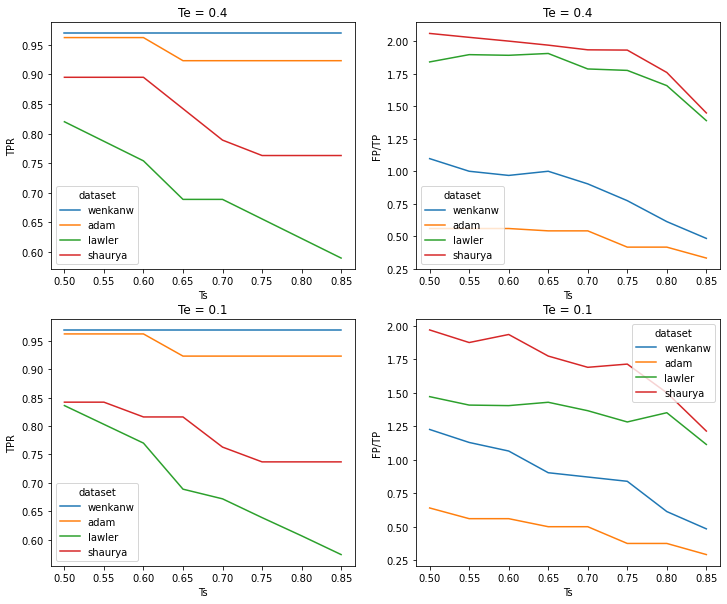

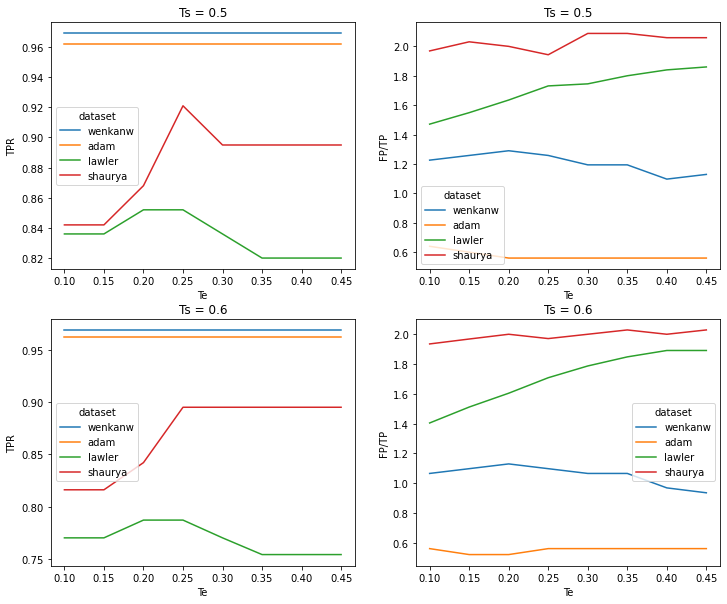

In [40]:
plot_threshold_results(threshold_results)

# Note:
Solved: there is a bug in get_episode_metrics() in cross validation. The GT segment input is for all days of data, but result is just partial days of results, the computation of TP,FP, FN is wrong!

# 4. Codes to update result tables when new data comes in

In [179]:
# import datetime
# # d1 = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')
# d1 = datetime.timedelta(hours=13,minutes=50,seconds=0,microseconds= 0)
# d2 = datetime.timedelta(hours=24,minutes=10,seconds=1,microseconds= 0)
# # d2 = datetime.datetime(2014, 10, 27, 9, 50, 16)
# # (d1-d2).seconds
# (d2-d1)

In [116]:
#  def loadEvents(filename ,debug_flag=False, print_file= True,root_path="../data-file-indices/CAD/"):
#     """
#     loads events data given the .shm filename
#     and parse the event.txt file to obtain meal duration
#     Input: 
#         filename:  <filename>-events.txt name of label file we want to load
#     output:
#         TotalEvents: amount of event loaded
#         EventStart: a list of starting moment of meals
#         EventEnd: a list of ending moment of meals
#         EventNames: name of meal in string
#     """
#     # Load the meals file to get any triaged meals.
#     SkippedMeals = []
#     if print_file:
#         print("Loading File: ", filename)
#     mealsfile = open( root_path +"meals-shimmer.txt", "r") 
    
#     for line in mealsfile:
#         #print(line)
#         data = line.split()
#         #print(data[0], data[1], data[13])
#         if(int(data[13]) == 0):
#             Mdata = [data[0][-9:], data[1], int(data[13])]
#             SkippedMeals.append(Mdata)
    
#     EventsFileName = filename.replace(".shm","-events.txt")
    
#     # Load the meals
#     e_s_ls = []
#     e_e_ls = []
#     EventNames = []
#     EventStart = (np.zeros((100))).astype(int)
#     EventEnd = (np.zeros((100))).astype(int)
#     TotalEvents = 0
#     TimeOffset = 0
#     EndTime = 0
#     file = open(EventsFileName, "r") 
#     for lines in file:
        
#         words = lines.split()
#         if debug_flag:
#             print("Words:", words)
            
#         if(len(words) == 0): continue # Skip empty lines
#         # Convert Start time to offset
#         if(words[0] == "START"): # Get Start Time (TimeOffset) from file
#             #print(words)
#             if words[2].count(":") <2:
#                 words[2] = words[2] +":00"
#             if debug_flag:
#                 print(words[2])
#             hours = int(words[2].split(":")[0])
#             minutes = int(words[2].split(":")[1])
#             seconds = int(words[2].split(":")[2])
#             print("Start:",datetime.timedelta(hours=hours,minutes=minutes,seconds=seconds,microseconds= 0))
#             #print("{}h:{}m:{}s".format(hours, minutes,seconds))
#             TimeOffset = (hours * 60 * 60) + (minutes * 60) + seconds
#             s_time = datetime.timedelta(hours=hours,minutes=minutes,seconds=seconds,microseconds= 0)#
#             continue
#         if(words[0] == "END"):
#             if words[2].count(":") <2:
#                 words[2] = words[2] +":00"
#             if debug_flag:
#                 print(words[2])
#             hours = int("24" if words[2].split(":")[0] == "00" else words[2].split(":")[0])
            
#             minutes = int(words[2].split(":")[1])
#             seconds = int(words[2].split(":")[2])
#             print("End: ",datetime.timedelta(hours=hours,minutes=minutes,seconds=seconds,microseconds= 0))
#             #print("{}h:{}m:{}s".format(hours, minutes,seconds))
#             EndTime = ((hours * 60 * 60) + (minutes * 60) + seconds ) 
#             e_time =datetime.timedelta(hours=hours,minutes=minutes,seconds=seconds,microseconds= 0) #
#             continue
         
#         # word index 
#         word_index = 0
#         count = 0
#         if debug_flag:
#             print("Debug: ",words)
#         while count <2 and word_index < len(words): # Process Events Data
#             # skip all not- numeric string
#             if words[word_index].replace(":","").isnumeric():
#                 count += 1
#                 # check if time format is correct, if not, add ":00"
#                 if words[word_index].count(":") <2:
#                     words[word_index] = words[word_index] +":00"
                    
#                 if debug_flag:
#                     print(words[word_index])

#                 hours = int(words[word_index].split(":")[0])
#                 minutes = int(words[word_index].split(":")[1])
#                 seconds = int(words[word_index].split(":")[2])
#                 event_time =datetime.timedelta(hours=hours,minutes=minutes,seconds=seconds,microseconds= 0) #
#                 #delta_time = event_time - s_time
#                 #print("Event time:",s_time,event_time,delta_time)
#                 EventTime = (hours * 60 * 60) + (minutes * 60) + seconds
#                 EventTime = EventTime - TimeOffset
#                 if(count == 1): 
#                     EventStart[TotalEvents] = EventTime * 15
#                     e_s_ls.append(event_time)
#                 if(count == 2): 
#                     e_e_ls.append(event_time)
#                     EventEnd[TotalEvents] = EventTime * 15
            
#             word_index += 1
            
#         if(TotalEvents>0):
#             if(EventStart[TotalEvents]<EventStart[TotalEvents-1]):
#                 EventStart[TotalEvents] = EventStart[TotalEvents] + (24*60*60*15)
#             if(EventEnd[TotalEvents]<EventEnd[TotalEvents-1]):
#                 EventEnd[TotalEvents] = EventEnd[TotalEvents] + (24*60*60*15)
        
        
#         # Check if meal was triaged out for too much walking or rest
#         ename = words[0]
#         fname = filename[-9:]
#         skipmeal = 0
#         #print(fname, ename)
#         for skippedmeal in SkippedMeals:
#             Pname, EventName, Keep = skippedmeal
#             if(Pname == fname and ename == EventName):
#                 #print(Pname, EventName, Keep, ename, fname, Pname == fname, ename == EventName)
#                 skipmeal = 1
#                 break
        
#         if(skipmeal == 1): continue
#         TotalEvents = TotalEvents + 1
#         EventNames.append(ename)
#     return TotalEvents, EventStart, EventEnd, EventNames, TimeOffset, EndTime, s_time, e_time, e_s_ls, e_e_ls
    
    
    
# def get_mealdataset_info(person_name = None,file_ls = [], file_ls_doc=None,root_path = "../data/",print_file=False):
#         """
#         if file_ls is not given, then get file_ls according to person_name
#         file path = root_path + file name in all_files_list.txt

#         return:
#             meal event count, total minutes of all meals, total hours of all meals,total day counts

#         """
#         if person_name !=None:
        
        
#             data_indices_file = "../data-file-indices/" +person_name+"/"+ file_ls_doc
#             fp = open(data_indices_file,"r")
            
#             txt = fp.read()
#             fp.close()
#             file_ls = txt.split("\n")
#             while '' in file_ls:
#                 file_ls.remove('')

#         meal_counts = 0
#         sec_counts = 0
#         min_counts = 0
#         hour_counts = 0
#         total_hours = 0
#         total_mins = 0
#         total_sec = 0
#         total_s = 0
#         sec_count = 0
#         day_counts = len(file_ls)
#         for file_name in file_ls:
#             file_name = root_path + file_name
#             TotalEvents, EventStart, EventEnd, EventNames, TimeOffset,EndTime,s_time, e_time,e_s_ls, e_e_ls = loadEvents(file_name, debug_flag = False, print_file=print_file)
#             meal_counts += TotalEvents
#             total_sec +=  (EndTime - TimeOffset)
#             total_s += (e_time-s_time).seconds
#             print("Day Hours: ",e_time-s_time)
# #             total_hours += (EndTime//(60*60) - TimeOffset//(60*60))
# #             total_mins  += (EndTime%(60*60) - TimeOffset//(60*60))
#             for i in range(len(EventStart)):
#                 sec_counts += ( EventEnd[i]- EventStart[i])//(15)
#             for i in range(len(e_s_ls)):
#                 sec_count += (e_e_ls[i] - e_s_ls[i]).seconds
#                 print("Second Difference",e_e_ls[i] - e_s_ls[i],(e_e_ls[i] - e_s_ls[i]).seconds)
#         total_hours = total_sec//(60*60)
#         min_counts = sec_counts//60
#         hour_counts = min_counts//60
#         print("total second: ",total_sec, total_s)
#         print("Second: ",sec_count,sec_count/(60*60))
        
#         return meal_counts, min_counts,hour_counts, day_counts, total_hours
    
    
# get_mealdataset_info(person_name = "adam",file_ls = [], file_ls_doc="all_files_list.txt",root_path = "../data/",print_file=False)

In [5]:
! ls ../results/possibility_results

adam_6min_5slide_proba.csv
cv_fold_0_adam_6min_5slide_proba.csv
cv_fold_0_group_adam_6min_5slide_proba.csv
cv_fold_0_group_lawler_6min_5slide_proba.csv
cv_fold_0_group_shaurya_6min_5slide_proba.csv
cv_fold_0_group_wenkanw_6min_5slide_proba.csv
cv_fold_0_lawler_6min_5slide_proba.csv
cv_fold_0_shaurya_6min_5slide_proba.csv
cv_fold_0_wenkanw_6min_5slide_proba.csv
cv_fold_1_adam_6min_5slide_proba.csv
cv_fold_1_group_adam_6min_5slide_proba.csv
cv_fold_1_group_lawler_6min_5slide_proba.csv
cv_fold_1_group_shaurya_6min_5slide_proba.csv
cv_fold_1_group_wenkanw_6min_5slide_proba.csv
cv_fold_1_lawler_6min_5slide_proba.csv
cv_fold_1_shaurya_6min_5slide_proba.csv
cv_fold_1_wenkanw_6min_5slide_proba.csv
cv_fold_2_adam_6min_5slide_proba.csv
cv_fold_2_group_adam_6min_5slide_proba.csv
cv_fold_2_group_lawler_6min_5slide_proba.csv
cv_fold_2_group_shaurya_6min_5slide_proba.csv
cv_fold_2_group_wenkanw_6min_5slide_proba.csv
cv_fold_2_lawler_6min_5slide_proba.csv
cv_fold_2_shaurya_6min_5slide_proba.csv
cv_fo